In [25]:
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import seaborn as sns
from scipy import signal
from mne.time_frequency import psd_array_multitaper
import optuna
import numpy as np  
import optuna.visualization as vis
from optuna.pruners import MedianPruner
import plotly
from scipy.stats import chisquare

In [26]:
low_cutoff = 0.01  # Low cut-off frequency (Hz)
high_cutoff = 70.0  # High cut-off frequency (Hz)
order = 4  # Order of the filter
sampling_rate_equipo= 500 
b, a = signal.butter(order, [low_cutoff / (0.5 * sampling_rate_equipo), high_cutoff / (0.5 * sampling_rate_equipo)], btype='band')

In [27]:
fs = 500  # Sampling rate
nperseg = 256  # Segment length
noverlap = 128 # Overlap between segments
sampling_rate = 2000 ### simulacion 

resultado_compilacion = subprocess.run("g++ -fopenmp -O3 main.cpp Matrix_conect.cpp -o main", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
if resultado_compilacion.returncode != 0:
    print("Error durante la compilación:")
    print(resultado_compilacion.stderr)

def Simulado_EGG(params,Normalizacion):
    L, P, inhibidoras, trest, trelative, alpha, tmax, type_matrix = params

    # Ejecución del programa
    resultado_ejecucion = subprocess.run(f" OMP_NUM_THREADS=4 ./main {L} {P} {inhibidoras} {trest} {trelative} {alpha} {tmax} {type_matrix}", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    if resultado_ejecucion.returncode != 0:
        print("Error durante la ejecución:")
        print(resultado_ejecucion.stderr)
        return None
    
    # Procesamiento de los datos
    lines = resultado_ejecucion.stdout.strip().split('\n')
    data_list = [[float(num) for num in line.split()] for line in lines]
    data = np.array(data_list)[50:, 1]  
     
    if(Normalizacion=="max_global"):    
        data=data / max(data)
    elif(Normalizacion=="max_global_abs"):
        data=data / max(abs(data))
    elif(Normalizacion=="zscore"):
        data=(data - np.mean(data)) / np.std(data)

    n_samples_resampled = int(len(data)*(fs/sampling_rate))
    data_resampled = signal.resample(data, n_samples_resampled)

    butter = signal.filtfilt(b, a,data_resampled)

    psd,frequencies = psd_array_multitaper(butter, fs, fmin=0, fmax=120, adaptive=True, normalization='full',n_jobs=3)
    frequencies=np.array(frequencies)

    welch_data = np.array([10 * np.log10(psd[i]) for i in range(len(frequencies))])
    
    delta = welch_data[np.logical_and(frequencies >= 0, frequencies <= 3)]
    theta = welch_data[np.logical_and(frequencies >= 3, frequencies <= 7)]
    alpha = welch_data[np.logical_and(frequencies >= 7, frequencies <= 14)]
    beta = welch_data[np.logical_and(frequencies >= 14, frequencies <= 30)]

    return {
        'data': data,"data_resample":data_resampled,"butter": butter,
        "frequencies": frequencies,"welch_data":welch_data,
        'delta':[delta.mean(),delta.std()],
        'theta':[theta.mean(), theta.std()],
        'alpha':[ alpha.mean(),alpha.std()],
        'beta': [beta.mean(), beta.std()]
    }



In [28]:
def Datos_reales(nombres,Normalizacion):
    Datos = np.empty(len(nombres), dtype=object)
    Butter = np.empty(len(nombres), dtype=object)
    welch_datos = np.empty(len(nombres), dtype=object)
    Frequencies = np.empty(len(nombres), dtype=object)
    Delta = np.empty(len(nombres), dtype=object)
    Theta = np.empty(len(nombres), dtype=object)
    Alpha = np.empty(len(nombres), dtype=object)
    Beta = np.empty(len(nombres), dtype=object)
    Nombres=np.empty(len(nombres), dtype="U100")

    mean_welch=np.zeros(481)
    mean_Delta = np.zeros(2)
    mean_Theta = np.zeros(2)
    mean_Alpha = np.zeros(2)
    mean_Beta = np.zeros(2)

    all_signals=np.empty_like(Datos)
    for i, nombre in enumerate(nombres): 
        all_signals[i]=np.loadtxt(nombre)

    all_values = np.concatenate(all_signals)  # Combinar todos los datos
    global_max = np.max(all_values)
    global_max_abs = np.max(abs(all_values))
    global_mean = np.mean(all_values)
    global_std = np.std(all_values)

    for i, nombre in enumerate(nombres):  
        Nombres[i]=nombre 
        data = np.loadtxt(nombre)

        if(Normalizacion=="max_global"):    
            data=data / global_max
        elif(Normalizacion=="max_global_abs"):
            data=data /global_max_abs
        elif(Normalizacion=="zscore"):
            data=(data -global_mean) / global_std

        Datos[i]=data
        Butter[i]=butter= signal.filtfilt(b, a,data)

        psd,frequencies = psd_array_multitaper(butter, fs, fmin=0, fmax=120, adaptive=True, normalization='full')
        Frequencies[i]=frequencies=np.array(frequencies)

        welch_data = np.array([10 * np.log10(psd[i]) for i in range(len(frequencies))])
        welch_datos[i]=welch_data
        mean_welch+=welch_data/len(nombres)

        delta = welch_data[np.logical_and(frequencies >= 1, frequencies <= 3)]
        theta = welch_data[np.logical_and(frequencies >= 4, frequencies <= 7)]
        alpha = welch_data[np.logical_and(frequencies >= 7, frequencies <= 13)]
        beta = welch_data[np.logical_and(frequencies >= 14, frequencies <= 30)]

        Delta[i]=[delta.mean(),delta.std()]
        Theta[i]=[theta.mean(),theta.std()]
        Alpha[i]=[alpha.mean(),alpha.std()]
        Beta[i]=[beta.mean(),beta.std()]

        mean_Delta += np.array([delta.mean(), delta.std()]) / len(nombres)
        mean_Theta += np.array([theta.mean(), theta.std()]) / len(nombres)
        mean_Alpha += np.array([alpha.mean(), alpha.std()]) / len(nombres)
        mean_Beta += np.array([beta.mean(), beta.std()]) / len(nombres)

    return {
        "Nombres":Nombres,
        'datos': Datos, "frequencies": Frequencies,  "welch_data":welch_datos,"mean_welch":mean_welch,
        'delta':Delta,'theta':Theta,'alpha':Alpha,'beta':Beta,
        'mean_Delta': mean_Delta,'mean_Theta':mean_Theta,"mean_Alpha":mean_Alpha,"mean_Beta":mean_Beta
    }


In [29]:
Params={'L': 49, 'P': 0.18480288512056137, 'Inh': 0.3568274238758705, 'Trest': 0.001388460705036468, 'Trelative': 0.1037062403200316, 'C_h': 0.8657675703460452, 'Tipo_red': 1}
initial_params = [Params["L"], Params["P"],Params["Inh"], Params["Trest"],Params["Trelative"], Params["C_h"] ,8050, Params["Tipo_red"]]

Normalizacion="zscore"###"max_global""max_global_abs" zscore
generated_data = Simulado_EGG(initial_params,Normalizacion)


reales_total = Datos_reales(["Datos_reales/P3_MNE.txt","Datos_reales/Pz_MNE.txt","Datos_reales/P4_MNE.txt"],Normalizacion)

    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


['Datos_reales/P3_MNE.txt' 'Datos_reales/Pz_MNE.txt'
 'Datos_reales/P4_MNE.txt']


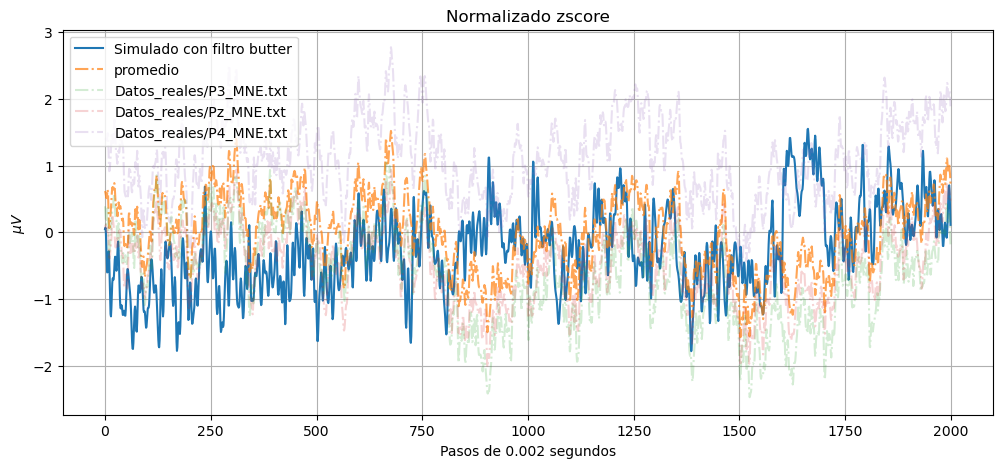

In [30]:
fig, ax = plt.subplots(figsize=[12, 5])


print(reales_total["Nombres"])
#ax.plot(generated_data["data_resample"],label="Simulado")

ax.plot(generated_data["butter"][:],label="Simulado con filtro butter")
grupos = np.array([reales_total["datos"][0], reales_total["datos"][1], reales_total["datos"][2]])
promedio = np.mean(grupos, axis=0) 

ax.plot(promedio,"-.", label="promedio",alpha=0.7)

for i in range(3):
    ax.plot(reales_total["datos"][i],"-.", label=reales_total["Nombres"][i],alpha=0.2)


plt.xlabel("Pasos de 0.002 segundos")
plt.ylabel(r"$\mu V$")
plt.legend()  # Esto añade una leyenda para identificar cada línea
plt.grid()
plt.title(f"Normalizado {Normalizacion}")
plt.show()  # Mostrar todos los gráficos en la misma figura


[0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.   2.25 2.5  2.75 3.   3.25
 3.5  3.75 4.   4.25 4.5  4.75 5.   5.25 5.5  5.75 6.   6.25 6.5  6.75
 7.   7.25 7.5  7.75]
481
481
241
['Datos_reales/P3_MNE.txt' 'Datos_reales/Pz_MNE.txt'
 'Datos_reales/P4_MNE.txt']
Delta [-12.801115611123468, 2.4877846762435696] ---- [-14.32164081   2.88721965]
Theta [-18.962736173192987, 1.5199388617926184] ---- [-18.96553014   1.24867868]
Alpha [-21.85690102020556, 1.3127050363973656] ---- [-21.50450614   1.65515045]
Beta [-27.23070239741755, 1.3439457260285024] ---- [-28.90417157   2.145858  ]


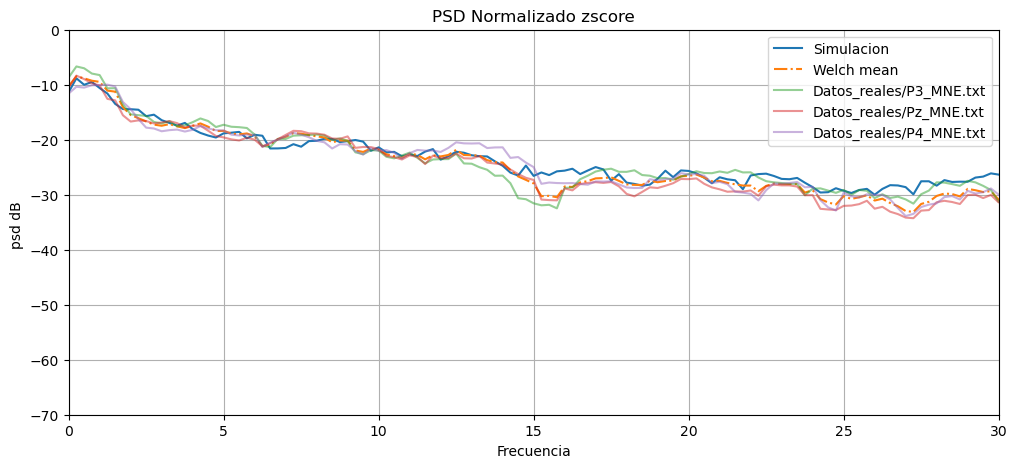

In [31]:
fig, ax = plt.subplots(figsize=[12, 5])
#print(generated_data["frequencies"])
print(generated_data["frequencies"][:32])
print(len(generated_data["frequencies"]))
print(len(reales_total["frequencies"][0]))
frequencies = reales_total["frequencies"][0]
count_in_range = np.sum((frequencies >= 0) & (frequencies <= 60))
print(count_in_range)

print(reales_total["Nombres"])
print("Delta",generated_data["delta"],"----",reales_total["mean_Delta"])
print("Theta",generated_data["theta"],"----",reales_total["mean_Theta"])
print("Alpha",generated_data["alpha"],"----",reales_total["mean_Alpha"])
print("Beta",generated_data["beta"],"----",reales_total["mean_Beta"])

ax.plot(generated_data["frequencies"],generated_data["welch_data"],label="Simulacion")
ax.plot(reales_total["frequencies"][0],reales_total["mean_welch"],label="Welch mean",linestyle="-.")
for i in range(3):
    ax.plot(reales_total["frequencies"][i],reales_total["welch_data"][i], label=reales_total["Nombres"][i],alpha=0.5)

plt.xlabel("Frecuencia")
plt.ylabel("psd dB ")
plt.grid()
plt.xlim(0,30)
plt.ylim(-70,0)
plt.title(f"PSD Normalizado {Normalizacion}")
plt.legend()  # Esto añade una leyenda para identificar cada línea
plt.show()  # Mostrar todos los gráficos en la misma figura


In [33]:

def objective(trial):
    params = np.zeros(8)
    params[0] = trial.suggest_int('L',10,20)
    params[1] = trial.suggest_float('P', 0.0, 1.0)
    params[2] = trial.suggest_float('Inh', 0.0, 1.0)
    
    params[3] = trial.suggest_float('Trest',0, 10.0)###, step=0.05 difernecia entre datos 
    params[4] = trial.suggest_float('Trelative',params[3],params[3]+10)  
    params[5] = trial.suggest_float('C_h', 0, 1)
    params[6] = 8050
    params[7] = trial.suggest_int('Tipo_red',3,4)

    
    generated_data_total = Simulado_EGG(params,Normalizacion)
    if generated_data_total["delta"][1]-generated_data_total["delta"][1]==0:
        
        hi2_stat, p_value = chisquare(generated_data_total["welch_data"][:121], f_exp=reales_total["mean_welch"][:121])
        trial.report(abs(hi2_stat), step=trial.number)### general
        
        
        return abs(hi2_stat)
    else:
        return float('inf')  
    
# Create and optimize the study
study = optuna.create_study(study_name=f"Chi30_{Normalizacion}_L10", 
                            storage=f"sqlite:///Estudios/Full/Chi30_{Normalizacion}_L10.db", 
                            load_if_exists=True,
                            direction="minimize",
                            pruner = optuna.pruners.HyperbandPruner(min_resource=10, max_resource=100, reduction_factor=3),
                            #sampler=optuna.samplers.RandomSampler(seed=42)
                            )
# Continúa con la optimización del estudio
study.optimize(objective, n_trials=300)


[I 2024-11-12 19:47:50,239] Using an existing study with name 'Chi30_zscore_L10' instead of creating a new one.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:47:52,667] Trial 2915 finished with value: 208.45252080453918 and parameters: {'L': 14, 'P': 0.4591532900616749, 'Inh': 0.5764462146727845, 'Trest': 5.89876834567186, 'Trelative': 6.121628438987859, 'C_h': 0.24557152734133833, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:47:53,677] Trial 2916 finished with value: 157.87032341306727 and parameters: {'L': 14, 'P': 0.4653110929970748, 'Inh': 0.5703291118640094, 'Trest': 5.821547007920686, 'Trelative': 6.067366808267093, 'C_h': 0.2506305508675064, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:47:54,892] Trial 2917 finished with value: 44.08696667526771 and parameters: {'L': 14, 'P': 0.4640346350775798, 'Inh': 0.5732483404029888, 'Trest': 5.757245447575856, 'Trelative': 5.9794789070531715, 'C_h': 0.25337674666867605, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:47:55,949] Trial 2918 finished with value: 123.88851417411696 and parameters: {'L': 14, 'P': 0.46247923685744347, 'Inh': 0.5759781957475473, 'Trest': 5.8696504425382106, 'Trelative': 6.1569116650789715, 'C_h': 0.2502433631981823, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:47:57,002] Trial 2919 finished with value: 71.30223850523099 and parameters: {'L': 14, 'P': 0.4628202176178525, 'Inh': 0.5834356027180689, 'Trest': 6.086467254027928, 'Trelative': 6.310399563400239, 'C_h': 0.2520861440281142, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:47:58,120] Trial 2920 finished with value: 81.27774031093357 and parameters: {'L': 14, 'P': 0.44781279678452435, 'Inh': 0.574603120264452, 'Trest': 5.843683456072594, 'Trelative': 6.089015798309949, 'C_h': 0.2631676954876863, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:47:59,091] Trial 2921 finished with value: 49.1906408092324 and parameters: {'L': 14, 'P': 0.45879925618670003, 'Inh': 0.5867018703152358, 'Trest': 6.06551911772598, 'Trelative': 6.293744511562787, 'C_h': 0.2548223489016446, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:48:00,233] Trial 2922 finished with value: 142.53169317348352 and parameters: {'L': 14, 'P': 0.4587080472876969, 'Inh': 0.5726294457072599, 'Trest': 6.13260202434897, 'Trelative': 6.3601639973250945, 'C_h': 0.251358184335346, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:48:01,201] Trial 2923 finished with value: 871.2456348103673 and parameters: {'L': 14, 'P': 0.46482913388440794, 'Inh': 0.5680695430750847, 'Trest': 6.098079295700565, 'Trelative': 6.331942237641139, 'C_h': 0.2468619213439637, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:48:02,049] Trial 2924 finished with value: 106.09387728563792 and parameters: {'L': 14, 'P': 0.46104342744775073, 'Inh': 0.5871684128928742, 'Trest': 6.156363345633181, 'Trelative': 6.35243991662918, 'C_h': 0.2456206924609059, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:48:03,066] Trial 2925 finished with value: 79087.86627337305 and parameters: {'L': 14, 'P': 0.4610318186534051, 'Inh': 0.5618655009212817, 'Trest': 6.116691498645377, 'Trelative': 6.353965183577684, 'C_h': 0.235891344146703, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:48:04,083] Trial 2926 finished with value: 76.4468434836421 and parameters: {'L': 14, 'P': 0.45774269788003596, 'Inh': 0.5772078112232941, 'Trest': 5.960096171636845, 'Trelative': 6.214443029244752, 'C_h': 0.2523743610913904, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:48:05,039] Trial 2927 finished with value: 226.66302801620608 and parameters: {'L': 14, 'P': 0.46638646901017955, 'Inh': 0.590098217573383, 'Trest': 6.154828514049487, 'Trelative': 6.3894690108008385, 'C_h': 0.24959654928028663, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:48:06,043] Trial 2928 finished with value: 79087.86627337305 and parameters: {'L': 14, 'P': 0.4473745732937396, 'Inh': 0.5594519730467526, 'Trest': 5.849029673244795, 'Trelative': 6.081497666207056, 'C_h': 0.2413554113553797, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:48:06,837] Trial 2929 finished with value: 424.4582224948882 and parameters: {'L': 14, 'P': 0.46997789172633947, 'Inh': 0.5870108945153776, 'Trest': 5.9738026279600565, 'Trelative': 6.199357704529473, 'C_h': 0.24135110438288215, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:48:07,836] Trial 2930 finished with value: 11799.249631728067 and parameters: {'L': 14, 'P': 0.44757870462380084, 'Inh': 0.5665307364478462, 'Trest': 5.767198882702169, 'Trelative': 6.028088382646433, 'C_h': 0.2520451551969324, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:48:08,628] Trial 2931 finished with value: 206.162596345234 and parameters: {'L': 14, 'P': 0.4682631008339619, 'Inh': 0.5911135225170052, 'Trest': 6.1462339059169295, 'Trelative': 6.367635094823204, 'C_h': 0.2526618670436184, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:48:09,619] Trial 2932 finished with value: 79087.86627337305 and parameters: {'L': 14, 'P': 0.44615563161622873, 'Inh': 0.5594264930453479, 'Trest': 5.941399575321336, 'Trelative': 6.162418544783315, 'C_h': 0.2309122644132455, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:48:10,825] Trial 2933 finished with value: 99.02528711427748 and parameters: {'L': 14, 'P': 0.4669237096080187, 'Inh': 0.5763577748053895, 'Trest': 5.737519606528075, 'Trelative': 5.99686365726878, 'C_h': 0.26511980374619154, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:48:11,833] Trial 2934 finished with value: 79087.86627337305 and parameters: {'L': 14, 'P': 0.44866553152723415, 'Inh': 0.5627828857545796, 'Trest': 6.167221893429193, 'Trelative': 6.3995930296056365, 'C_h': 0.23796272663807527, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:48:12,713] Trial 2935 finished with value: 95.49315321549653 and parameters: {'L': 14, 'P': 0.47204027008308713, 'Inh': 0.5848769122093458, 'Trest': 5.7800570852381625, 'Trelative': 6.000263153125154, 'C_h': 0.26423318861058576, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:48:13,720] Trial 2936 finished with value: 79087.86627337305 and parameters: {'L': 14, 'P': 0.4718092805377856, 'Inh': 0.5580707451596701, 'Trest': 5.992415592380809, 'Trelative': 6.213678802178852, 'C_h': 0.23188271821944192, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:48:14,491] Trial 2937 finished with value: 534.3203148920265 and parameters: {'L': 14, 'P': 0.44834215052697785, 'Inh': 0.5945706990723212, 'Trest': 5.785218338597546, 'Trelative': 6.037851267553183, 'C_h': 0.2502112890547009, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:48:15,446] Trial 2938 finished with value: 11372.851528760757 and parameters: {'L': 14, 'P': 0.437277756351682, 'Inh': 0.5742715172277396, 'Trest': 6.160900278869582, 'Trelative': 6.39526094223511, 'C_h': 0.23150684587173334, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:48:16,270] Trial 2939 finished with value: 748.579760983319 and parameters: {'L': 14, 'P': 0.4625421913699412, 'Inh': 0.5927210057385447, 'Trest': 5.958719734884639, 'Trelative': 6.189021365490704, 'C_h': 0.2504158705127597, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:48:17,280] Trial 2940 finished with value: 127.30462735684645 and parameters: {'L': 14, 'P': 0.4744763661466651, 'Inh': 0.56114756973687, 'Trest': 5.68878173475288, 'Trelative': 5.912386000160881, 'C_h': 0.22708940762236496, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:48:18,325] Trial 2941 finished with value: 256.74189891717714 and parameters: {'L': 14, 'P': 0.4519502113286831, 'Inh': 0.5788591545364268, 'Trest': 6.104942066893129, 'Trelative': 6.328095557913412, 'C_h': 0.26571576147884096, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:48:19,442] Trial 2942 finished with value: 79087.86627337305 and parameters: {'L': 14, 'P': 0.4432546202130119, 'Inh': 0.5576351781003654, 'Trest': 5.90291636786635, 'Trelative': 6.1269771226719705, 'C_h': 0.262499834139607, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:48:20,159] Trial 2943 finished with value: 939.2188719833688 and parameters: {'L': 14, 'P': 0.46755839608393457, 'Inh': 0.592194370232164, 'Trest': 5.762904702448784, 'Trelative': 5.9940481687566125, 'C_h': 0.23553385515726416, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:48:21,161] Trial 2944 finished with value: 284.86811003824073 and parameters: {'L': 14, 'P': 0.43509899692701803, 'Inh': 0.5737334358543805, 'Trest': 6.139312118743024, 'Trelative': 6.351535146427334, 'C_h': 0.26582040217052094, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:48:22,376] Trial 2945 finished with value: 132.97082988392884 and parameters: {'L': 14, 'P': 0.47571062775222006, 'Inh': 0.556051194099556, 'Trest': 5.68903120218498, 'Trelative': 5.947552530139951, 'C_h': 0.22778267086516546, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:48:23,089] Trial 2946 finished with value: 163.96612328398479 and parameters: {'L': 14, 'P': 0.4400367847642225, 'Inh': 0.5980332385943262, 'Trest': 5.9493968858235, 'Trelative': 6.178909935211545, 'C_h': 0.27406303582614716, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:48:24,121] Trial 2947 finished with value: 79087.86627337305 and parameters: {'L': 14, 'P': 0.46835607148808, 'Inh': 0.5555550191060996, 'Trest': 6.154885985921796, 'Trelative': 6.443819960983356, 'C_h': 0.25674556074556226, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:48:25,132] Trial 2948 finished with value: 80.61952259136476 and parameters: {'L': 14, 'P': 0.4753167017870621, 'Inh': 0.5762326864986569, 'Trest': 5.7661933941718155, 'Trelative': 5.983880650346554, 'C_h': 0.2311388613795015, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:48:25,879] Trial 2949 finished with value: 405.0262804726954 and parameters: {'L': 14, 'P': 0.4570081975274979, 'Inh': 0.5959750759411353, 'Trest': 5.637432513172045, 'Trelative': 5.805086392617968, 'C_h': 0.22417852543918088, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:48:27,011] Trial 2950 finished with value: 79087.86627337305 and parameters: {'L': 14, 'P': 0.4336358706958347, 'Inh': 0.5558973957538352, 'Trest': 6.01301793297951, 'Trelative': 6.256090854927121, 'C_h': 0.255459986746079, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:48:28,011] Trial 2951 finished with value: 508.02927566913064 and parameters: {'L': 14, 'P': 0.4561142098743164, 'Inh': 0.5753181112128077, 'Trest': 6.2048566144046875, 'Trelative': 6.41979709547901, 'C_h': 0.24331410969468947, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:48:28,763] Trial 2952 finished with value: 3351.854870102044 and parameters: {'L': 14, 'P': 0.4753485086494397, 'Inh': 0.5954044874878257, 'Trest': 5.870550097062176, 'Trelative': 6.140813530578354, 'C_h': 0.2774207125367647, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:48:29,762] Trial 2953 finished with value: 446.4726009224763 and parameters: {'L': 14, 'P': 0.44096607269560045, 'Inh': 0.5551204219441452, 'Trest': 5.647354197185884, 'Trelative': 5.865958959486802, 'C_h': 0.21547839864365137, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:48:30,749] Trial 2954 finished with value: 40.78959811460373 and parameters: {'L': 14, 'P': 0.4735967323151056, 'Inh': 0.5767702893453552, 'Trest': 6.0093900967210345, 'Trelative': 6.207927663326781, 'C_h': 0.24537469265995032, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:48:31,491] Trial 2955 finished with value: 1152.866672673952 and parameters: {'L': 14, 'P': 0.47888654594157126, 'Inh': 0.6012496369028824, 'Trest': 6.1993808967005375, 'Trelative': 6.496753285762146, 'C_h': 0.23434828195873628, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:48:32,361] Trial 2956 finished with value: 168.94215404794647 and parameters: {'L': 14, 'P': 0.4784826292956734, 'Inh': 0.596601500144938, 'Trest': 6.218203143544661, 'Trelative': 6.456966811021951, 'C_h': 0.2592098337540437, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:48:33,074] Trial 2957 finished with value: 1119.64822242823 and parameters: {'L': 14, 'P': 0.4649781415029274, 'Inh': 0.5970043968730787, 'Trest': 5.988133200685445, 'Trelative': 6.208976790772933, 'C_h': 0.24997319805828738, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:48:34,176] Trial 2958 finished with value: 77.44530952197496 and parameters: {'L': 14, 'P': 0.45644756398459335, 'Inh': 0.5796959684594375, 'Trest': 6.101111124127819, 'Trelative': 6.33474470288063, 'C_h': 0.2705591223556742, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:48:34,997] Trial 2959 finished with value: 2277.943117002249 and parameters: {'L': 14, 'P': 0.47632209732030373, 'Inh': 0.6036961147446128, 'Trest': 6.2381404460734355, 'Trelative': 6.4826897579325395, 'C_h': 0.24965838805942242, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:48:35,663] Trial 2960 finished with value: 31212.30327505755 and parameters: {'L': 14, 'P': 0.43908159618780823, 'Inh': 0.6198787310009364, 'Trest': 5.960322658946335, 'Trelative': 6.187785897960496, 'C_h': 0.21885956720706803, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:48:36,797] Trial 2961 finished with value: 45.03187700108854 and parameters: {'L': 14, 'P': 0.45993249560716903, 'Inh': 0.5819274516264028, 'Trest': 5.972116311957592, 'Trelative': 6.232000585490025, 'C_h': 0.27306075094237325, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:48:37,453] Trial 2962 finished with value: 3968.4353043142855 and parameters: {'L': 14, 'P': 0.4312893177546268, 'Inh': 0.6234000630520864, 'Trest': 6.195787093005335, 'Trelative': 6.459249274736396, 'C_h': 0.2722926251941893, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:48:38,153] Trial 2963 finished with value: 572.7548240842256 and parameters: {'L': 14, 'P': 0.43819239823851375, 'Inh': 0.601326569490245, 'Trest': 6.187317623534319, 'Trelative': 6.430532128045693, 'C_h': 0.2797738444992067, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:48:38,796] Trial 2964 finished with value: 8231.192658827444 and parameters: {'L': 14, 'P': 0.45811990867135827, 'Inh': 0.6196937591420547, 'Trest': 6.022862556567504, 'Trelative': 6.254397728415749, 'C_h': 0.26694677191709854, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:48:39,489] Trial 2965 finished with value: 608.8694150429217 and parameters: {'L': 14, 'P': 0.4492263716594279, 'Inh': 0.5966180884153706, 'Trest': 6.01041778875924, 'Trelative': 6.24405380363992, 'C_h': 0.276396678231448, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:48:40,500] Trial 2966 finished with value: 47.42789206470348 and parameters: {'L': 14, 'P': 0.4345238393609971, 'Inh': 0.5866344303759294, 'Trest': 5.900252861804257, 'Trelative': 6.136993938318277, 'C_h': 0.25091675015061504, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:48:41,257] Trial 2967 finished with value: 391.3950059491658 and parameters: {'L': 14, 'P': 0.4311811853774782, 'Inh': 0.6037125379788155, 'Trest': 5.8572150923371105, 'Trelative': 6.08388268054739, 'C_h': 0.23933580359197335, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:48:41,877] Trial 2968 finished with value: 3889.390650024102 and parameters: {'L': 14, 'P': 0.4322308657336049, 'Inh': 0.6262713889395388, 'Trest': 5.858089439747584, 'Trelative': 6.089305910032738, 'C_h': 0.26068974268108486, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:48:42,553] Trial 2969 finished with value: 36693.99007002136 and parameters: {'L': 14, 'P': 0.4326892991869596, 'Inh': 0.6198811322362223, 'Trest': 5.802979705770951, 'Trelative': 6.0558090778118165, 'C_h': 0.24833778792205402, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:48:43,284] Trial 2970 finished with value: 628.8622678056371 and parameters: {'L': 14, 'P': 0.45149061961761505, 'Inh': 0.6053159445312489, 'Trest': 6.011639677774241, 'Trelative': 6.2424014738592675, 'C_h': 0.2757799318663541, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:48:43,956] Trial 2971 finished with value: 4593.989828889742 and parameters: {'L': 14, 'P': 0.42934910897935286, 'Inh': 0.6233984645020729, 'Trest': 5.774978262490232, 'Trelative': 6.021338714807478, 'C_h': 0.25502133540663535, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:48:44,863] Trial 2972 finished with value: 217.06203158737964 and parameters: {'L': 14, 'P': 0.45276017406733093, 'Inh': 0.5907112574203773, 'Trest': 6.222683316010187, 'Trelative': 6.492453095193817, 'C_h': 0.2767074175628955, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:48:45,596] Trial 2973 finished with value: 224.974005117239 and parameters: {'L': 14, 'P': 0.4383868253563813, 'Inh': 0.6023810306789951, 'Trest': 5.930354111145786, 'Trelative': 6.17223847835243, 'C_h': 0.24671402346367916, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:48:46,426] Trial 2974 finished with value: 248.6116017375989 and parameters: {'L': 14, 'P': 0.4624922292975967, 'Inh': 0.5880606664941181, 'Trest': 5.7158113670146795, 'Trelative': 5.922237207591959, 'C_h': 0.2341521501654832, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:48:47,177] Trial 2975 finished with value: 219.6031133168395 and parameters: {'L': 14, 'P': 0.43013533756267786, 'Inh': 0.6148176068690581, 'Trest': 6.245497055572992, 'Trelative': 6.504261133225474, 'C_h': 0.26849214651924097, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:48:48,143] Trial 2976 finished with value: 102.38947315082963 and parameters: {'L': 14, 'P': 0.4513567389059527, 'Inh': 0.5860641574640303, 'Trest': 6.017226847417048, 'Trelative': 6.267089593488992, 'C_h': 0.24806270032892277, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:48:48,860] Trial 2977 finished with value: 1596.4058308409433 and parameters: {'L': 14, 'P': 0.45708390059381504, 'Inh': 0.6035022062018001, 'Trest': 5.707113281275261, 'Trelative': 5.927069738536034, 'C_h': 0.22407517333029156, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:48:50,121] Trial 2978 finished with value: 87.92108299635122 and parameters: {'L': 14, 'P': 0.4251628735153432, 'Inh': 0.583858206976858, 'Trest': 5.908354726431026, 'Trelative': 6.153589125842622, 'C_h': 0.27299249628568356, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:48:50,786] Trial 2979 finished with value: 33587.68172006084 and parameters: {'L': 14, 'P': 0.46460782595998357, 'Inh': 0.6222183751475838, 'Trest': 6.212504812467136, 'Trelative': 6.490669077827219, 'C_h': 0.2379553073687548, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:48:51,574] Trial 2980 finished with value: 296.9413839130249 and parameters: {'L': 14, 'P': 0.44705057968126166, 'Inh': 0.5849748106371874, 'Trest': 5.66120336435147, 'Trelative': 5.872154127589069, 'C_h': 0.2588234178181613, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:48:52,336] Trial 2981 finished with value: 5876.482325163345 and parameters: {'L': 14, 'P': 0.474635092181827, 'Inh': 0.6044323157042047, 'Trest': 6.033679986170968, 'Trelative': 6.2947728443437025, 'C_h': 0.23395794616696228, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:48:53,283] Trial 2982 finished with value: 45.73110524973406 and parameters: {'L': 14, 'P': 0.43951740711469345, 'Inh': 0.58077729423832, 'Trest': 5.847162855957097, 'Trelative': 6.078428649082947, 'C_h': 0.27762189878064575, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:48:54,044] Trial 2983 finished with value: 14004.003088087318 and parameters: {'L': 14, 'P': 0.4305016989556025, 'Inh': 0.6271712439160673, 'Trest': 6.208439931374015, 'Trelative': 6.4700985409539715, 'C_h': 0.3061158505336317, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:48:54,766] Trial 2984 finished with value: 705.2324527901601 and parameters: {'L': 14, 'P': 0.437970091614236, 'Inh': 0.6012926075473499, 'Trest': 6.060467839535917, 'Trelative': 6.336441347482304, 'C_h': 0.27248402301722713, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:48:55,397] Trial 2985 finished with value: 7870.737048563263 and parameters: {'L': 14, 'P': 0.43345865293936015, 'Inh': 0.6230747612207657, 'Trest': 6.249587126751138, 'Trelative': 6.4753953419029395, 'C_h': 0.2989923159066099, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:48:56,346] Trial 2986 finished with value: 272.7832948347428 and parameters: {'L': 14, 'P': 0.42381166428579076, 'Inh': 0.58303704207396, 'Trest': 5.895038352308064, 'Trelative': 6.11127602819371, 'C_h': 0.2841111609963516, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:48:57,040] Trial 2987 finished with value: 753.8971050028367 and parameters: {'L': 14, 'P': 0.4234667385815229, 'Inh': 0.5978959426398702, 'Trest': 6.102596212096349, 'Trelative': 6.329646781657217, 'C_h': 0.28487351208977296, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:48:57,988] Trial 2988 finished with value: 41.36942905639892 and parameters: {'L': 14, 'P': 0.4430387242496725, 'Inh': 0.5821641638880383, 'Trest': 5.8535776151658085, 'Trelative': 6.082475601458026, 'C_h': 0.2919128587343433, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:48:58,602] Trial 2989 finished with value: 5473.277846660233 and parameters: {'L': 14, 'P': 0.4245239324042663, 'Inh': 0.6288909903771484, 'Trest': 5.750690279619288, 'Trelative': 5.978237787267465, 'C_h': 0.2971545648563472, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:48:59,254] Trial 2990 finished with value: 12125.840301440936 and parameters: {'L': 14, 'P': 0.44888199983768406, 'Inh': 0.6170023075627801, 'Trest': 5.659805232555728, 'Trelative': 5.876771883576072, 'C_h': 0.28389657664182494, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:48:59,915] Trial 2991 finished with value: 692.2560669900122 and parameters: {'L': 14, 'P': 0.4281992956493974, 'Inh': 0.6048056060307757, 'Trest': 5.870480562922395, 'Trelative': 6.091888396650026, 'C_h': 0.29127776542451705, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:49:00,521] Trial 2992 finished with value: 31236.549066097356 and parameters: {'L': 14, 'P': 0.44425568213676403, 'Inh': 0.6316669783072117, 'Trest': 5.620130588116366, 'Trelative': 5.850584926635544, 'C_h': 0.2755989143458765, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:49:01,200] Trial 2993 finished with value: 1027.9607928995315 and parameters: {'L': 14, 'P': 0.4248115491754765, 'Inh': 0.6079715508681622, 'Trest': 5.730050610775228, 'Trelative': 5.984429628755249, 'C_h': 0.2620736063716671, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:49:02,135] Trial 2994 finished with value: 354.8219461671232 and parameters: {'L': 14, 'P': 0.4460364830641577, 'Inh': 0.586086754165079, 'Trest': 5.796097327401794, 'Trelative': 6.02311224285009, 'C_h': 0.3066323140379582, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:49:02,923] Trial 2995 finished with value: 159.1409925062755 and parameters: {'L': 14, 'P': 0.4458373259939042, 'Inh': 0.588880793246675, 'Trest': 5.860103825501808, 'Trelative': 6.110212515910752, 'C_h': 0.2834332574820524, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:49:03,601] Trial 2996 finished with value: 4967.392579496614 and parameters: {'L': 14, 'P': 0.4237506823860614, 'Inh': 0.6149720610426593, 'Trest': 5.575847046134126, 'Trelative': 5.7362969822717655, 'C_h': 0.3079383764239386, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:49:04,419] Trial 2997 finished with value: 127.79556387228229 and parameters: {'L': 14, 'P': 0.45564378036179165, 'Inh': 0.5862758255095573, 'Trest': 5.909837165054641, 'Trelative': 6.143458242838955, 'C_h': 0.2711125743884452, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:49:05,115] Trial 2998 finished with value: 19015.08073377968 and parameters: {'L': 14, 'P': 0.4563396723583891, 'Inh': 0.6030493131848494, 'Trest': 5.603725705138652, 'Trelative': 5.791351448966974, 'C_h': 0.3017689866839986, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:49:06,248] Trial 2999 finished with value: 205.44115367183093 and parameters: {'L': 14, 'P': 0.4314921352618322, 'Inh': 0.5753577797616127, 'Trest': 5.9600533037298336, 'Trelative': 6.189667135561937, 'C_h': 0.25695990089102627, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:49:06,970] Trial 3000 finished with value: 5006.581142041847 and parameters: {'L': 14, 'P': 0.411603817501545, 'Inh': 0.6245386949105782, 'Trest': 5.7645774855007685, 'Trelative': 6.005710090375197, 'C_h': 0.26656124580886237, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:49:07,754] Trial 3001 finished with value: 131.22807606995946 and parameters: {'L': 14, 'P': 0.4542556723608071, 'Inh': 0.5830471481199373, 'Trest': 5.522196667677938, 'Trelative': 5.743322254149543, 'C_h': 0.3002374980693008, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:49:08,496] Trial 3002 finished with value: 535.856867413352 and parameters: {'L': 14, 'P': 0.43667006585372836, 'Inh': 0.603075149130978, 'Trest': 5.932662307632658, 'Trelative': 6.15006728617371, 'C_h': 0.25089089838101036, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:49:09,129] Trial 3003 finished with value: 35494.36902267795 and parameters: {'L': 14, 'P': 0.45789506821805676, 'Inh': 0.6317430223901658, 'Trest': 5.595870217526983, 'Trelative': 5.8503289468613975, 'C_h': 0.2718721123724462, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:49:10,054] Trial 3004 finished with value: 127.01424116012409 and parameters: {'L': 14, 'P': 0.398589288694858, 'Inh': 0.5810713852460988, 'Trest': 5.803456211462982, 'Trelative': 6.0222548724954, 'C_h': 0.2575659647407972, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:49:10,825] Trial 3005 finished with value: 759.1378125031908 and parameters: {'L': 14, 'P': 0.41880909549939954, 'Inh': 0.610436540222173, 'Trest': 6.068621643318047, 'Trelative': 6.300804757281016, 'C_h': 0.28302868221263094, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:49:11,823] Trial 3006 finished with value: 362.13469301136047 and parameters: {'L': 14, 'P': 0.43867513470613345, 'Inh': 0.5796131892232149, 'Trest': 6.058178484265495, 'Trelative': 6.2833646888815355, 'C_h': 0.2464744940759218, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:49:12,539] Trial 3007 finished with value: 3460.8100509611704 and parameters: {'L': 14, 'P': 0.4672948676002795, 'Inh': 0.6001807608200265, 'Trest': 5.683024062387847, 'Trelative': 5.892196967691034, 'C_h': 0.30109159981418215, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:49:13,164] Trial 3008 finished with value: 32539.203149407476 and parameters: {'L': 14, 'P': 0.45929888646957884, 'Inh': 0.6372713496496514, 'Trest': 5.85545776132532, 'Trelative': 6.103894792718095, 'C_h': 0.23710150929631962, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:49:14,145] Trial 3009 finished with value: 79087.86627337305 and parameters: {'L': 14, 'P': 0.4189170113666355, 'Inh': 0.578332088837749, 'Trest': 6.240274549186103, 'Trelative': 6.5153958887846555, 'C_h': 0.28324697144167216, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:49:14,874] Trial 3010 finished with value: 1527.8009835438943 and parameters: {'L': 14, 'P': 0.44466541172916446, 'Inh': 0.5957334309757414, 'Trest': 5.538326770578705, 'Trelative': 5.757758757383579, 'C_h': 0.2612889502801038, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:49:16,004] Trial 3011 finished with value: 190.77509908650745 and parameters: {'L': 14, 'P': 0.46865644714612903, 'Inh': 0.5732252935307514, 'Trest': 6.077611076968927, 'Trelative': 6.317013043029425, 'C_h': 0.24016522250134037, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:49:16,679] Trial 3012 finished with value: 1455.0311899609358 and parameters: {'L': 14, 'P': 0.39887322101514344, 'Inh': 0.6157165976363408, 'Trest': 5.7894012758796665, 'Trelative': 6.024368656498451, 'C_h': 0.2808704511501917, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:49:17,472] Trial 3013 finished with value: 296.0453482653931 and parameters: {'L': 14, 'P': 0.4368910557372703, 'Inh': 0.5934519234507674, 'Trest': 5.619132427371288, 'Trelative': 5.885703735383739, 'C_h': 0.22724449929967208, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:49:18,415] Trial 3014 finished with value: 33.262020479230166 and parameters: {'L': 14, 'P': 0.4680777588850092, 'Inh': 0.5790841352865979, 'Trest': 5.937973936252049, 'Trelative': 6.205804922920311, 'C_h': 0.2560014218292374, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:49:19,399] Trial 3015 finished with value: 54.39983897283826 and parameters: {'L': 14, 'P': 0.45870894784659766, 'Inh': 0.5740097942889086, 'Trest': 5.60503922018124, 'Trelative': 5.834533961907154, 'C_h': 0.2275560464727325, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:49:20,564] Trial 3016 finished with value: 300.2073875984957 and parameters: {'L': 14, 'P': 0.4687136025094608, 'Inh': 0.576225719756505, 'Trest': 5.840733573216775, 'Trelative': 6.0524371320989445, 'C_h': 0.24958413693205364, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:49:21,572] Trial 3017 finished with value: 38.33397576554461 and parameters: {'L': 14, 'P': 0.4755710631857544, 'Inh': 0.5702918901662866, 'Trest': 5.517117268003516, 'Trelative': 5.784760461119842, 'C_h': 0.27030870454800804, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:49:22,311] Trial 3018 finished with value: 329.18904579304814 and parameters: {'L': 14, 'P': 0.4746858329333215, 'Inh': 0.5787370263725653, 'Trest': 5.46546537793341, 'Trelative': 5.6536327702191445, 'C_h': 0.2893723108706211, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:49:23,144] Trial 3019 finished with value: 345.6713344419313 and parameters: {'L': 14, 'P': 0.476229189912215, 'Inh': 0.5718127115147414, 'Trest': 5.482922366392484, 'Trelative': 5.720923811056484, 'C_h': 0.2966036900957034, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:49:24,050] Trial 3020 finished with value: 206.82147480443632 and parameters: {'L': 14, 'P': 0.46599628574390756, 'Inh': 0.5729538227819623, 'Trest': 5.4772068919358246, 'Trelative': 5.685069914621864, 'C_h': 0.2718963887442948, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:49:24,786] Trial 3021 finished with value: 1031.7374936891188 and parameters: {'L': 14, 'P': 0.47539457593208034, 'Inh': 0.5942696625351059, 'Trest': 5.473017859202491, 'Trelative': 5.688294479858824, 'C_h': 0.2588334683809652, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:49:26,021] Trial 3022 finished with value: 191.5436973383186 and parameters: {'L': 14, 'P': 0.45307976766199576, 'Inh': 0.5748330128886231, 'Trest': 5.482935579642118, 'Trelative': 5.81623579394665, 'C_h': 0.28005943200177214, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:49:26,723] Trial 3023 finished with value: 969.1668684638404 and parameters: {'L': 14, 'P': 0.4728490706021423, 'Inh': 0.5837746951744608, 'Trest': 5.6310455832630115, 'Trelative': 5.862786791771754, 'C_h': 0.27124921943484864, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:49:27,418] Trial 3024 finished with value: 5149.1360341478 and parameters: {'L': 14, 'P': 0.4563167235273657, 'Inh': 0.5968820232233103, 'Trest': 5.434949964980815, 'Trelative': 5.748381572465965, 'C_h': 0.30813105718515166, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:49:28,476] Trial 3025 finished with value: 119.91576160477399 and parameters: {'L': 14, 'P': 0.4769179013058148, 'Inh': 0.5675886948491856, 'Trest': 5.6298394401615095, 'Trelative': 5.8369515617228185, 'C_h': 0.25466405818671, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:49:29,475] Trial 3026 finished with value: 95.73739677169748 and parameters: {'L': 14, 'P': 0.44961218261291364, 'Inh': 0.5679979188311588, 'Trest': 5.700692770842358, 'Trelative': 5.935331675992596, 'C_h': 0.31157894444903833, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:49:30,202] Trial 3027 finished with value: 1376.2703266414787 and parameters: {'L': 14, 'P': 0.48048811809746533, 'Inh': 0.5912431593867498, 'Trest': 5.4945298289344215, 'Trelative': 5.675264876372068, 'C_h': 0.2446712897805302, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:49:31,029] Trial 3028 finished with value: 2720.8868650368886 and parameters: {'L': 14, 'P': 0.4617294536860569, 'Inh': 0.5968152473506984, 'Trest': 5.700621126162256, 'Trelative': 5.937456965274137, 'C_h': 0.2927275306562857, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:49:32,165] Trial 3029 finished with value: 105.15641169056155 and parameters: {'L': 14, 'P': 0.4504105747980597, 'Inh': 0.5687699517644524, 'Trest': 5.451899754896546, 'Trelative': 5.647338446280194, 'C_h': 0.2768503930018542, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:49:32,832] Trial 3030 finished with value: 30570.50753077566 and parameters: {'L': 14, 'P': 0.47836413614305434, 'Inh': 0.6144798345277237, 'Trest': 5.722421221195357, 'Trelative': 5.999492135076889, 'C_h': 0.22195838011482946, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:49:33,855] Trial 3031 finished with value: 123.09436336815756 and parameters: {'L': 14, 'P': 0.4473462366613737, 'Inh': 0.5690811706515059, 'Trest': 5.45847183392898, 'Trelative': 5.634622530639978, 'C_h': 0.25570012727458424, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:49:34,596] Trial 3032 finished with value: 2033.446767933732 and parameters: {'L': 14, 'P': 0.4703710620508657, 'Inh': 0.5922385720431991, 'Trest': 5.809176278240032, 'Trelative': 6.0430885712682, 'C_h': 0.2656337291055196, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:49:35,507] Trial 3033 finished with value: 143.3251722440845 and parameters: {'L': 14, 'P': 0.4377990970906463, 'Inh': 0.5835505190133539, 'Trest': 5.638568303441841, 'Trelative': 5.8708428179146415, 'C_h': 0.30197218630174283, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:49:36,560] Trial 3034 finished with value: 135.19579090053116 and parameters: {'L': 14, 'P': 0.4782429062941472, 'Inh': 0.5683735575464482, 'Trest': 5.809823163709641, 'Trelative': 6.042258006928378, 'C_h': 0.23569891087238928, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:49:37,340] Trial 3035 finished with value: 17285.799827622748 and parameters: {'L': 14, 'P': 0.4565225890892441, 'Inh': 0.6040409084722872, 'Trest': 5.445487616610979, 'Trelative': 5.657776446563982, 'C_h': 0.2801901730923115, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:49:38,341] Trial 3036 finished with value: 249.69582348246573 and parameters: {'L': 14, 'P': 0.4396330356710841, 'Inh': 0.5638106868689832, 'Trest': 5.6265317723943005, 'Trelative': 5.832663298688558, 'C_h': 0.22281021245650556, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:49:39,130] Trial 3037 finished with value: 166.89221222654535 and parameters: {'L': 14, 'P': 0.47961580372966356, 'Inh': 0.5886197470592538, 'Trest': 5.840742058971292, 'Trelative': 6.078235215229578, 'C_h': 0.2517401637967062, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:49:39,892] Trial 3038 finished with value: 12305.906873548201 and parameters: {'L': 14, 'P': 0.45858188030943664, 'Inh': 0.6155413701546815, 'Trest': 5.619322904251611, 'Trelative': 5.852355049190886, 'C_h': 0.24530378228278002, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:49:40,920] Trial 3039 finished with value: 79087.86627337305 and parameters: {'L': 14, 'P': 0.4793070219499984, 'Inh': 0.5607395337685194, 'Trest': 5.851696488752423, 'Trelative': 6.0695576273735155, 'C_h': 0.2911140315828485, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:49:41,721] Trial 3040 finished with value: 94.43290085012168 and parameters: {'L': 14, 'P': 0.43692371686247333, 'Inh': 0.5865465822751817, 'Trest': 5.442656880075735, 'Trelative': 5.647315959747999, 'C_h': 0.2673458517511965, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:49:42,410] Trial 3041 finished with value: 14509.886962543447 and parameters: {'L': 14, 'P': 0.4619875173851263, 'Inh': 0.6069827858815414, 'Trest': 5.903186566408643, 'Trelative': 6.162441425429978, 'C_h': 0.3103875399622877, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:49:43,506] Trial 3042 finished with value: 209.27982643977325 and parameters: {'L': 14, 'P': 0.48145609574151516, 'Inh': 0.5675625639920606, 'Trest': 5.675851997144632, 'Trelative': 5.929001752119307, 'C_h': 0.21959139425612875, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:49:44,305] Trial 3043 finished with value: 139.0321868121346 and parameters: {'L': 14, 'P': 0.4368654411246325, 'Inh': 0.5878904631331047, 'Trest': 5.442997163210021, 'Trelative': 5.702298684184186, 'C_h': 0.2422875263411684, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:49:45,125] Trial 3044 finished with value: 6652.844214960725 and parameters: {'L': 14, 'P': 0.4606430146897815, 'Inh': 0.6265160399845735, 'Trest': 5.757625508280673, 'Trelative': 5.999182675058222, 'C_h': 0.26694332767728235, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:49:46,100] Trial 3045 finished with value: 79087.86627337305 and parameters: {'L': 14, 'P': 0.4791415966852973, 'Inh': 0.5580331160950159, 'Trest': 5.920050806719097, 'Trelative': 6.151781074950893, 'C_h': 0.2400346518540083, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:49:46,776] Trial 3046 finished with value: 8982.394223724204 and parameters: {'L': 14, 'P': 0.4398393115914487, 'Inh': 0.6041544130218633, 'Trest': 5.627629574140223, 'Trelative': 5.812461182054612, 'C_h': 0.2965365692121428, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:49:47,593] Trial 3047 finished with value: 138.46353231763882 and parameters: {'L': 14, 'P': 0.45927701088804046, 'Inh': 0.5785684293488457, 'Trest': 5.4398438539519125, 'Trelative': 5.667479343125641, 'C_h': 0.2796882040562583, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:49:48,614] Trial 3048 finished with value: 4686.679535319306 and parameters: {'L': 14, 'P': 0.42465116091674693, 'Inh': 0.5614940894982635, 'Trest': 5.813516205338896, 'Trelative': 6.070750420271644, 'C_h': 0.2253350516702768, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:49:49,532] Trial 3049 finished with value: 424.54209825489795 and parameters: {'L': 14, 'P': 0.4841632516154469, 'Inh': 0.5876823248377349, 'Trest': 5.978311057898159, 'Trelative': 6.216798354182613, 'C_h': 0.2641879650647776, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:49:50,533] Trial 3050 finished with value: 410.9557123572856 and parameters: {'L': 14, 'P': 0.45698608602571983, 'Inh': 0.5592091641586951, 'Trest': 5.624933893978101, 'Trelative': 5.854853414672811, 'C_h': 0.24377552151076728, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:49:51,193] Trial 3051 finished with value: 30354.820919077847 and parameters: {'L': 14, 'P': 0.4418213227406056, 'Inh': 0.6151274651382681, 'Trest': 5.969209415869618, 'Trelative': 6.201875642866187, 'C_h': 0.22115908745815618, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:49:51,945] Trial 3052 finished with value: 729.7386670359971 and parameters: {'L': 14, 'P': 0.47815421699286276, 'Inh': 0.5779681463510553, 'Trest': 5.390936990091633, 'Trelative': 5.592220786037192, 'C_h': 0.2847955797603943, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:49:52,624] Trial 3053 finished with value: 1911.0259614732709 and parameters: {'L': 14, 'P': 0.4641193550245175, 'Inh': 0.5998776515974347, 'Trest': 5.742904983822285, 'Trelative': 5.970699618497412, 'C_h': 0.2602423800162527, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:49:53,554] Trial 3054 finished with value: 79087.86627337305 and parameters: {'L': 14, 'P': 0.42088166444279995, 'Inh': 0.5612767182236849, 'Trest': 5.600158948920709, 'Trelative': 5.83162482866034, 'C_h': 0.30377669783359906, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:49:54,298] Trial 3055 finished with value: 26055.868596539774 and parameters: {'L': 14, 'P': 0.4426094863688294, 'Inh': 0.6282576065455463, 'Trest': 5.968305639849845, 'Trelative': 6.209977666051678, 'C_h': 0.24216103723118151, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:49:55,209] Trial 3056 finished with value: 66.74750680806625 and parameters: {'L': 14, 'P': 0.48219888553589335, 'Inh': 0.5784841321037126, 'Trest': 5.805558891847207, 'Trelative': 6.006859722721323, 'C_h': 0.2178095429400172, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:49:55,900] Trial 3057 finished with value: 335.1478688938179 and parameters: {'L': 14, 'P': 0.4248208143449457, 'Inh': 0.6000213126030721, 'Trest': 5.514235970299379, 'Trelative': 5.718530114395817, 'C_h': 0.2793033448777999, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:49:56,849] Trial 3058 finished with value: 79087.86627337305 and parameters: {'L': 14, 'P': 0.4656159305563223, 'Inh': 0.5605924787052435, 'Trest': 6.002320335497108, 'Trelative': 6.246468129045429, 'C_h': 0.2595509936045169, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:49:57,588] Trial 3059 finished with value: 751.6923075284625 and parameters: {'L': 14, 'P': 0.4493382779941778, 'Inh': 0.5844110252625405, 'Trest': 5.4109522610349305, 'Trelative': 5.604638654259671, 'C_h': 0.3191456603999525, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:49:58,235] Trial 3060 finished with value: 5569.347102968583 and parameters: {'L': 14, 'P': 0.47626018261153136, 'Inh': 0.6147469805191537, 'Trest': 5.737192666172495, 'Trelative': 5.983003238783214, 'C_h': 0.2766803418987614, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:49:59,418] Trial 3061 finished with value: 79087.86627337305 and parameters: {'L': 14, 'P': 0.42864859335947936, 'Inh': 0.5540060317166474, 'Trest': 6.021214472441297, 'Trelative': 6.242940527976106, 'C_h': 0.243464772249509, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:50:00,462] Trial 3062 finished with value: 110.07065947018333 and parameters: {'L': 14, 'P': 0.4507688249065444, 'Inh': 0.5775954167901348, 'Trest': 5.700677379681943, 'Trelative': 5.953213333665041, 'C_h': 0.21819373361464312, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:50:01,158] Trial 3063 finished with value: 1464.0231662750732 and parameters: {'L': 14, 'P': 0.48347644673243456, 'Inh': 0.5968314417749028, 'Trest': 5.885599013937912, 'Trelative': 6.111967476057183, 'C_h': 0.25882982645348507, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:50:02,136] Trial 3064 finished with value: 12036.995449852711 and parameters: {'L': 14, 'P': 0.46217822698941796, 'Inh': 0.5556615492346059, 'Trest': 5.406281774339505, 'Trelative': 5.596194353424215, 'C_h': 0.29881866028597737, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:50:02,728] Trial 3065 finished with value: 30260.836569263858 and parameters: {'L': 14, 'P': 0.4257143368943068, 'Inh': 0.6371179897430267, 'Trest': 5.568573357121519, 'Trelative': 5.8545994449398515, 'C_h': 0.22057761292986416, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:50:03,855] Trial 3066 finished with value: 98.61772541671814 and parameters: {'L': 14, 'P': 0.4841085090533311, 'Inh': 0.5725288020950028, 'Trest': 6.016839003176878, 'Trelative': 6.256879825176928, 'C_h': 0.23951373775763676, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:50:04,548] Trial 3067 finished with value: 1345.0692246252263 and parameters: {'L': 14, 'P': 0.447426707375704, 'Inh': 0.6028604084482535, 'Trest': 5.843979926378026, 'Trelative': 6.069430172234056, 'C_h': 0.27393028391034335, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:50:05,259] Trial 3068 finished with value: 1880.3961759670883 and parameters: {'L': 14, 'P': 0.4835354214943072, 'Inh': 0.5849981464283859, 'Trest': 5.612524661179656, 'Trelative': 5.773801744729155, 'C_h': 0.3116951273942524, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:50:06,209] Trial 3069 finished with value: 79087.86627337305 and parameters: {'L': 14, 'P': 0.4418960092089479, 'Inh': 0.5565639853999337, 'Trest': 6.088254825234036, 'Trelative': 6.325814468514134, 'C_h': 0.25585361525415007, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:50:06,837] Trial 3070 finished with value: 32027.299740941573 and parameters: {'L': 14, 'P': 0.46600770624328386, 'Inh': 0.6181195881957544, 'Trest': 5.4272198853499285, 'Trelative': 5.666220506069245, 'C_h': 0.23591662046369297, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:50:07,578] Trial 3071 finished with value: 284.0014635943865 and parameters: {'L': 14, 'P': 0.42327770953508664, 'Inh': 0.5926627419294411, 'Trest': 5.725628619775552, 'Trelative': 5.958192373148665, 'C_h': 0.28946692284064474, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:50:08,765] Trial 3072 finished with value: 62.783755821258765 and parameters: {'L': 14, 'P': 0.46296611580137503, 'Inh': 0.5757387113381203, 'Trest': 5.884539815583625, 'Trelative': 6.124889913499405, 'C_h': 0.26689599919301543, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:50:09,753] Trial 3073 finished with value: 79087.86627337305 and parameters: {'L': 14, 'P': 0.48182512179237275, 'Inh': 0.5627926562786318, 'Trest': 6.146867106001898, 'Trelative': 6.377361973143303, 'C_h': 0.24565006043434717, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:50:10,431] Trial 3074 finished with value: 33043.86755566564 and parameters: {'L': 14, 'P': 0.4408925582300221, 'Inh': 0.6105865467490015, 'Trest': 5.60206548927616, 'Trelative': 5.8133945894463634, 'C_h': 0.21677822656539006, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:50:11,384] Trial 3075 finished with value: 79087.86627337305 and parameters: {'L': 14, 'P': 0.4213298881971404, 'Inh': 0.5549816391714106, 'Trest': 5.924397693372539, 'Trelative': 6.1504373486320105, 'C_h': 0.28272459964027397, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:50:12,090] Trial 3076 finished with value: 1959.1092030391842 and parameters: {'L': 14, 'P': 0.4600464965863465, 'Inh': 0.5925875490367025, 'Trest': 5.414391044520718, 'Trelative': 5.62761111935349, 'C_h': 0.2603544695795563, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:50:12,712] Trial 3077 finished with value: 34914.827145505566 and parameters: {'L': 14, 'P': 0.4839376134219196, 'Inh': 0.6359077355168885, 'Trest': 5.781152661086541, 'Trelative': 6.007118262867232, 'C_h': 0.30520179833984606, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:50:13,865] Trial 3078 finished with value: 79087.86627337305 and parameters: {'L': 14, 'P': 0.45038637545766474, 'Inh': 0.5526605350510547, 'Trest': 6.160135788111879, 'Trelative': 6.404220049042942, 'C_h': 0.2254817765762166, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:50:14,775] Trial 3079 finished with value: 6070.760623965491 and parameters: {'L': 14, 'P': 0.41325215444931646, 'Inh': 0.5703152708649495, 'Trest': 5.5969251296996, 'Trelative': 5.856707828395707, 'C_h': 0.2464374018159591, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:50:15,432] Trial 3080 finished with value: 1611.7888182542151 and parameters: {'L': 14, 'P': 0.4798885950520879, 'Inh': 0.603431546972514, 'Trest': 6.014061948195683, 'Trelative': 6.252538447543433, 'C_h': 0.2850939425339713, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:50:16,274] Trial 3081 finished with value: 35.161692601785944 and parameters: {'L': 14, 'P': 0.43600496945675504, 'Inh': 0.5789461150098361, 'Trest': 5.3786541880775545, 'Trelative': 5.572387652129824, 'C_h': 0.266911456802144, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:50:17,254] Trial 3082 finished with value: 11303.993207196789 and parameters: {'L': 14, 'P': 0.4697083983560054, 'Inh': 0.5506243297897374, 'Trest': 5.461719113478234, 'Trelative': 5.650865536806307, 'C_h': 0.2931462960494921, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:50:18,429] Trial 3083 finished with value: 79087.86627337305 and parameters: {'L': 14, 'P': 0.44551177009503407, 'Inh': 0.5539710842981906, 'Trest': 5.54900653455234, 'Trelative': 5.70693541805784, 'C_h': 0.31203572002626867, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:50:19,255] Trial 3084 finished with value: 155.96503827779475 and parameters: {'L': 14, 'P': 0.4628328866586015, 'Inh': 0.5754019210778459, 'Trest': 5.486889125620591, 'Trelative': 5.650058840792051, 'C_h': 0.26397172618419695, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:50:20,246] Trial 3085 finished with value: 260.90670397218645 and parameters: {'L': 14, 'P': 0.4865335497498096, 'Inh': 0.548693308013469, 'Trest': 5.333418554192215, 'Trelative': 5.5067392824631884, 'C_h': 0.234048764304093, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:50:21,267] Trial 3086 finished with value: 77.56777406344943 and parameters: {'L': 14, 'P': 0.43997175458432175, 'Inh': 0.5731522680601729, 'Trest': 5.476519735892563, 'Trelative': 5.713174769716807, 'C_h': 0.2773338139576632, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:50:22,225] Trial 3087 finished with value: 73.4048893510007 and parameters: {'L': 14, 'P': 0.4624261175105294, 'Inh': 0.5726807110687858, 'Trest': 5.344407948116956, 'Trelative': 5.66066720684989, 'C_h': 0.21184991220341326, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:50:23,330] Trial 3088 finished with value: 79087.86627337305 and parameters: {'L': 14, 'P': 0.48719822578334676, 'Inh': 0.5496918685126122, 'Trest': 5.449089734689752, 'Trelative': 5.648799232191922, 'C_h': 0.24812682079480083, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:50:24,322] Trial 3089 finished with value: 317.3952727950408 and parameters: {'L': 14, 'P': 0.43640097370850744, 'Inh': 0.5664494010607077, 'Trest': 5.3757330659179745, 'Trelative': 5.554622410054713, 'C_h': 0.31931389230793694, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:50:25,087] Trial 3090 finished with value: 776.5445590813486 and parameters: {'L': 14, 'P': 0.46420100918792445, 'Inh': 0.5832799434367053, 'Trest': 5.41605635368435, 'Trelative': 5.611842769713504, 'C_h': 0.27606283080626004, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:50:26,300] Trial 3091 finished with value: 119.84545642044002 and parameters: {'L': 14, 'P': 0.4887146605301059, 'Inh': 0.5540269130408438, 'Trest': 5.317000591894877, 'Trelative': 5.511353212917931, 'C_h': 0.21343554520808106, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:50:27,041] Trial 3092 finished with value: 243.15828051500318 and parameters: {'L': 14, 'P': 0.44849534543146025, 'Inh': 0.5853295714833302, 'Trest': 5.359295334045144, 'Trelative': 5.54219629534135, 'C_h': 0.29193403566111653, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:50:28,040] Trial 3093 finished with value: 11306.398202950659 and parameters: {'L': 14, 'P': 0.48445777867587875, 'Inh': 0.5508546095156853, 'Trest': 5.579503514708261, 'Trelative': 5.823021841886223, 'C_h': 0.25709388191440125, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:50:29,071] Trial 3094 finished with value: 56.16656901498923 and parameters: {'L': 14, 'P': 0.46525588573791404, 'Inh': 0.5741380012790298, 'Trest': 5.350395126593916, 'Trelative': 5.543299096964332, 'C_h': 0.2351170773082947, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:50:29,779] Trial 3095 finished with value: 405.5677431402351 and parameters: {'L': 14, 'P': 0.43243369251486036, 'Inh': 0.5886518329825157, 'Trest': 5.660630297380266, 'Trelative': 5.8833249746556975, 'C_h': 0.2642840456827996, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:50:30,715] Trial 3096 finished with value: 79087.86627337305 and parameters: {'L': 14, 'P': 0.44935197292880347, 'Inh': 0.5488572748901176, 'Trest': 5.636981951869594, 'Trelative': 5.835661899540848, 'C_h': 0.23512750438624813, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:50:31,658] Trial 3097 finished with value: 52.34597961087163 and parameters: {'L': 14, 'P': 0.46949476309749943, 'Inh': 0.569562531449614, 'Trest': 5.389708272239645, 'Trelative': 5.626958615695228, 'C_h': 0.2991671546886808, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:50:32,578] Trial 3098 finished with value: 79087.86627337305 and parameters: {'L': 14, 'P': 0.41935804660818093, 'Inh': 0.5484723507166303, 'Trest': 5.322895348288991, 'Trelative': 5.5340103319793155, 'C_h': 0.31802971362719007, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:50:33,625] Trial 3099 finished with value: 79087.86627337305 and parameters: {'L': 14, 'P': 0.43390040324593404, 'Inh': 0.5629039964001218, 'Trest': 5.30650311457028, 'Trelative': 5.524257651200734, 'C_h': 0.30467836010037413, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:50:34,568] Trial 3100 finished with value: 79087.86627337305 and parameters: {'L': 14, 'P': 0.4494611571690705, 'Inh': 0.5510455586484435, 'Trest': 5.263793316323361, 'Trelative': 5.508504851502635, 'C_h': 0.29945277160245976, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:50:35,376] Trial 3101 finished with value: 119.9658887582022 and parameters: {'L': 14, 'P': 0.4642779060644084, 'Inh': 0.5692285447275258, 'Trest': 5.344698372938808, 'Trelative': 5.516993339409326, 'C_h': 0.3274513620359741, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:50:36,345] Trial 3102 finished with value: 79087.86627337305 and parameters: {'L': 14, 'P': 0.4346123177184815, 'Inh': 0.5489355421903142, 'Trest': 5.303776814931104, 'Trelative': 5.523815216900621, 'C_h': 0.31753913369489295, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:50:37,045] Trial 3103 finished with value: 451.0951380760893 and parameters: {'L': 14, 'P': 0.45984195295639907, 'Inh': 0.5898131745306336, 'Trest': 5.437130552228475, 'Trelative': 5.655023204919649, 'C_h': 0.27788974270908934, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:50:37,987] Trial 3104 finished with value: 772.380095649968 and parameters: {'L': 14, 'P': 0.41574164913730427, 'Inh': 0.5707763022819925, 'Trest': 5.342803444309426, 'Trelative': 5.607884574345326, 'C_h': 0.2968962102683213, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:50:39,157] Trial 3105 finished with value: 79087.86627337305 and parameters: {'L': 14, 'P': 0.4462507853681768, 'Inh': 0.5444335679709859, 'Trest': 5.558386818397147, 'Trelative': 5.77660894397916, 'C_h': 0.29570812302159516, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:50:39,964] Trial 3106 finished with value: 1025.6751768427446 and parameters: {'L': 14, 'P': 0.473433156506521, 'Inh': 0.5706285073473086, 'Trest': 5.561246647419147, 'Trelative': 5.794874079031701, 'C_h': 0.3176646869951232, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:50:40,673] Trial 3107 finished with value: 778.9421519971092 and parameters: {'L': 14, 'P': 0.43450697352641354, 'Inh': 0.5963687316762012, 'Trest': 5.373125220070866, 'Trelative': 5.571627663856182, 'C_h': 0.2868172118633427, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:50:41,386] Trial 3108 finished with value: 405.70443148540755 and parameters: {'L': 14, 'P': 0.4809011104577371, 'Inh': 0.5855092817887868, 'Trest': 5.57059398413574, 'Trelative': 5.790016025280492, 'C_h': 0.2652569203772434, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:50:42,391] Trial 3109 finished with value: 45.68293461176585 and parameters: {'L': 14, 'P': 0.45821664790871014, 'Inh': 0.5698203635661835, 'Trest': 5.364075573965286, 'Trelative': 5.595733995694859, 'C_h': 0.27457164300786585, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:50:43,437] Trial 3110 finished with value: 79087.86627337305 and parameters: {'L': 14, 'P': 0.4197194678547717, 'Inh': 0.5464870711637728, 'Trest': 5.304207977578968, 'Trelative': 5.458604258199958, 'C_h': 0.2771439372672079, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:50:44,156] Trial 3111 finished with value: 4767.033442008855 and parameters: {'L': 14, 'P': 0.4448837652857021, 'Inh': 0.6064017185334551, 'Trest': 5.631698488312176, 'Trelative': 5.865721691621514, 'C_h': 0.2547579757333379, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:50:45,113] Trial 3112 finished with value: 11565.932503418782 and parameters: {'L': 14, 'P': 0.4261363893359994, 'Inh': 0.5694775735309279, 'Trest': 5.660135068037418, 'Trelative': 5.896823659682258, 'C_h': 0.25269966359782114, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:50:45,864] Trial 3113 finished with value: 735.9499027638433 and parameters: {'L': 14, 'P': 0.41155265433600113, 'Inh': 0.5959962462963526, 'Trest': 5.292360633343333, 'Trelative': 5.482424549221583, 'C_h': 0.28004659600478066, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:50:46,844] Trial 3114 finished with value: 79087.86627337305 and parameters: {'L': 14, 'P': 0.4520484398495609, 'Inh': 0.5537452465398516, 'Trest': 5.532761423951597, 'Trelative': 5.766365696602526, 'C_h': 0.23973176596542822, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:50:47,664] Trial 3115 finished with value: 14763.84676536176 and parameters: {'L': 14, 'P': 0.43843468671730984, 'Inh': 0.6148948730583684, 'Trest': 5.66863413701245, 'Trelative': 5.871460713048421, 'C_h': 0.26877717925729483, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:50:48,508] Trial 3116 finished with value: 34.28810838752819 and parameters: {'L': 14, 'P': 0.4592862946837261, 'Inh': 0.5837915212148616, 'Trest': 5.280777937007778, 'Trelative': 5.484199479042796, 'C_h': 0.22027011338343178, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:50:49,147] Trial 3117 finished with value: 18391.053815604802 and parameters: {'L': 14, 'P': 0.41303689232662527, 'Inh': 0.6175212528132885, 'Trest': 5.228480388246493, 'Trelative': 5.5524602775499, 'C_h': 0.22058962670354826, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:50:49,833] Trial 3118 finished with value: 1988.8179132396692 and parameters: {'L': 14, 'P': 0.4315010351481637, 'Inh': 0.5988829976392489, 'Trest': 5.239869452147359, 'Trelative': 5.465439130114772, 'C_h': 0.22930046286549374, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:50:50,439] Trial 3119 finished with value: 32578.974383959037 and parameters: {'L': 14, 'P': 0.4515670090237115, 'Inh': 0.6240366466151629, 'Trest': 5.24266898256618, 'Trelative': 5.430068871915442, 'C_h': 0.24093798557817947, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:50:51,308] Trial 3120 finished with value: 1140.0924246559525 and parameters: {'L': 14, 'P': 0.4061740963473378, 'Inh': 0.5908219487818449, 'Trest': 5.287068630514743, 'Trelative': 5.451191341394597, 'C_h': 0.2206774190801541, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:50:52,018] Trial 3121 finished with value: 5550.559698389508 and parameters: {'L': 14, 'P': 0.43792241038274377, 'Inh': 0.6066192123129968, 'Trest': 5.47241874325508, 'Trelative': 5.681903445716221, 'C_h': 0.2535637768934446, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:50:52,875] Trial 3122 finished with value: 53.160968504759786 and parameters: {'L': 14, 'P': 0.4602834675721319, 'Inh': 0.5801592631414931, 'Trest': 5.302355863392413, 'Trelative': 5.42518092611226, 'C_h': 0.24000989091384073, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:50:53,598] Trial 3123 finished with value: 695.3550403729282 and parameters: {'L': 14, 'P': 0.4298127366698057, 'Inh': 0.5915080014298422, 'Trest': 5.26558033674877, 'Trelative': 5.466380262344603, 'C_h': 0.21833007903144816, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:50:54,252] Trial 3124 finished with value: 30681.80350878889 and parameters: {'L': 14, 'P': 0.4591962152721783, 'Inh': 0.6138617372899542, 'Trest': 5.3755112793365605, 'Trelative': 5.5646869833577215, 'C_h': 0.25836024295667626, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:50:55,291] Trial 3125 finished with value: 129.81955268802054 and parameters: {'L': 14, 'P': 0.4440638819216252, 'Inh': 0.5781436990959491, 'Trest': 5.470766599220902, 'Trelative': 5.62784839819417, 'C_h': 0.2412321484527823, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:50:55,863] Trial 3126 finished with value: 34289.297764963994 and parameters: {'L': 14, 'P': 0.4066501144355979, 'Inh': 0.6419769282987161, 'Trest': 5.35117854828012, 'Trelative': 5.5786926153110095, 'C_h': 0.2723110472660541, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:50:56,555] Trial 3127 finished with value: 685.9671306482187 and parameters: {'L': 14, 'P': 0.426716126207422, 'Inh': 0.5986399238349368, 'Trest': 5.199907322875778, 'Trelative': 5.4578346220874705, 'C_h': 0.22698367829621488, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:50:57,554] Trial 3128 finished with value: 160.90674859593017 and parameters: {'L': 14, 'P': 0.46068805689169573, 'Inh': 0.5689708516111895, 'Trest': 5.533727265121872, 'Trelative': 5.745230245092501, 'C_h': 0.21328384639293244, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:50:58,252] Trial 3129 finished with value: 31577.191842351596 and parameters: {'L': 14, 'P': 0.4470205835222806, 'Inh': 0.6250388451381368, 'Trest': 5.720916661607481, 'Trelative': 5.9525496438255106, 'C_h': 0.25693099614013826, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:50:59,201] Trial 3130 finished with value: 79087.86627337305 and parameters: {'L': 14, 'P': 0.4629886623426205, 'Inh': 0.5463531031886362, 'Trest': 5.0897217704341, 'Trelative': 5.5015135380959155, 'C_h': 0.2771597768021916, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:51:00,172] Trial 3131 finished with value: 71.16991150748598 and parameters: {'L': 14, 'P': 0.40354114729867535, 'Inh': 0.5889171600212149, 'Trest': 5.494195797527399, 'Trelative': 5.695125339060651, 'C_h': 0.24204793293714444, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:51:01,138] Trial 3132 finished with value: 11166.172612673501 and parameters: {'L': 14, 'P': 0.42637223378021427, 'Inh': 0.567926153897653, 'Trest': 5.7226890691297685, 'Trelative': 5.95356388062372, 'C_h': 0.25831080993124383, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:51:01,808] Trial 3133 finished with value: 21163.04733593337 and parameters: {'L': 14, 'P': 0.47131201881686696, 'Inh': 0.6078185827283342, 'Trest': 5.2549234600403345, 'Trelative': 5.438656418600868, 'C_h': 0.21273200777268308, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:51:02,540] Trial 3134 finished with value: 498.1561895807346 and parameters: {'L': 14, 'P': 0.4504557690678834, 'Inh': 0.5848973518241787, 'Trest': 5.4557395910252815, 'Trelative': 5.668596937898728, 'C_h': 0.28687838209846084, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:51:03,493] Trial 3135 finished with value: 79087.86627337305 and parameters: {'L': 14, 'P': 0.42521942959726855, 'Inh': 0.5478782093742747, 'Trest': 5.733685999571097, 'Trelative': 5.958318531763657, 'C_h': 0.2321284948653629, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:51:04,657] Trial 3136 finished with value: 131.1960835597984 and parameters: {'L': 14, 'P': 0.44364338409369697, 'Inh': 0.5648305117020957, 'Trest': 5.013909910246038, 'Trelative': 5.244244012708667, 'C_h': 0.26373538713935674, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:51:05,357] Trial 3137 finished with value: 12797.825954027872 and parameters: {'L': 14, 'P': 0.4644659874232657, 'Inh': 0.606297188439968, 'Trest': 5.573981752985956, 'Trelative': 5.795354560591494, 'C_h': 0.24016596839522203, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:51:06,071] Trial 3138 finished with value: 835.6046270147251 and parameters: {'L': 14, 'P': 0.4776710111723603, 'Inh': 0.5846294617184756, 'Trest': 5.2805471884686215, 'Trelative': 5.472754881263395, 'C_h': 0.2825328104125306, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:51:07,066] Trial 3139 finished with value: 79087.86627337305 and parameters: {'L': 14, 'P': 0.41285300245494955, 'Inh': 0.5463151895167055, 'Trest': 5.8064460291663895, 'Trelative': 6.042944224226143, 'C_h': 0.21192929632769006, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:51:07,716] Trial 3140 finished with value: 25163.130890168923 and parameters: {'L': 14, 'P': 0.43554908564237443, 'Inh': 0.625725433765842, 'Trest': 5.4997264598130435, 'Trelative': 5.714049260045839, 'C_h': 0.25337979472950317, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:51:08,830] Trial 3141 finished with value: 10960.136710298399 and parameters: {'L': 14, 'P': 0.45405939366364134, 'Inh': 0.5650267137708708, 'Trest': 5.774427077397474, 'Trelative': 5.991996508877381, 'C_h': 0.29841769885498126, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:51:09,596] Trial 3142 finished with value: 2156.477444256443 and parameters: {'L': 14, 'P': 0.4867653542986137, 'Inh': 0.587954929483437, 'Trest': 5.263344916484416, 'Trelative': 5.479653657000267, 'C_h': 0.270151873070436, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:51:10,539] Trial 3143 finished with value: 10115.09609663795 and parameters: {'L': 14, 'P': 0.40306467497251625, 'Inh': 0.5645926026032072, 'Trest': 5.762714149363297, 'Trelative': 5.995024338601405, 'C_h': 0.24014053530426113, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:51:11,267] Trial 3144 finished with value: 3218.7349584409208 and parameters: {'L': 14, 'P': 0.469371030418445, 'Inh': 0.5986492241965681, 'Trest': 5.488562418803253, 'Trelative': 5.766675068995902, 'C_h': 0.21521205014162698, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:51:12,261] Trial 3145 finished with value: 79087.86627337305 and parameters: {'L': 14, 'P': 0.43054803307382156, 'Inh': 0.5487946519745778, 'Trest': 5.662361777837016, 'Trelative': 5.902331520326097, 'C_h': 0.2698911550936737, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:51:13,222] Trial 3146 finished with value: 54.629185356210094 and parameters: {'L': 14, 'P': 0.44809859562044807, 'Inh': 0.5795732754082576, 'Trest': 5.029392292112731, 'Trelative': 5.242763480541425, 'C_h': 0.22822002421801899, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:51:13,861] Trial 3147 finished with value: 8995.632429480409 and parameters: {'L': 14, 'P': 0.48302066554285455, 'Inh': 0.6219480107857247, 'Trest': 5.373197629156315, 'Trelative': 5.621127944937319, 'C_h': 0.28723403796346203, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:51:14,861] Trial 3148 finished with value: 79087.86627337305 and parameters: {'L': 14, 'P': 0.4659617288682396, 'Inh': 0.5455924641483901, 'Trest': 5.840085580607298, 'Trelative': 6.032718297344103, 'C_h': 0.26512861268238286, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:51:15,458] Trial 3149 finished with value: 34907.35405975368 and parameters: {'L': 14, 'P': 0.4172048821109794, 'Inh': 0.6409307159358079, 'Trest': 5.6247115338801015, 'Trelative': 5.845837505824586, 'C_h': 0.24461160314887087, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:51:16,369] Trial 3150 finished with value: 51.63290474565735 and parameters: {'L': 14, 'P': 0.4485234296582189, 'Inh': 0.5776517885640643, 'Trest': 5.184172971334511, 'Trelative': 5.497766641658095, 'C_h': 0.2540925188730707, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:51:17,186] Trial 3151 finished with value: 8303.795531072612 and parameters: {'L': 14, 'P': 0.4839723893506625, 'Inh': 0.6070168383611244, 'Trest': 5.848198221109034, 'Trelative': 6.069129665390299, 'C_h': 0.21244926566748512, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:51:18,156] Trial 3152 finished with value: 154.5670090674271 and parameters: {'L': 14, 'P': 0.4289182218515151, 'Inh': 0.5630467269479399, 'Trest': 5.498647221433052, 'Trelative': 5.73408445031969, 'C_h': 0.2315140507859946, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:51:18,854] Trial 3153 finished with value: 1958.7940449689802 and parameters: {'L': 14, 'P': 0.4673107048362884, 'Inh': 0.5945425570530685, 'Trest': 4.969082089908377, 'Trelative': 5.2125798761589754, 'C_h': 0.2968037682997568, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:51:19,794] Trial 3154 finished with value: 79087.86627337305 and parameters: {'L': 14, 'P': 0.39372281089074074, 'Inh': 0.5420271213353006, 'Trest': 5.781601115142809, 'Trelative': 6.013251087512056, 'C_h': 0.3085204213193667, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:51:20,590] Trial 3155 finished with value: 72.12429899885485 and parameters: {'L': 14, 'P': 0.44662991726183654, 'Inh': 0.5766856038977963, 'Trest': 5.362740212949513, 'Trelative': 5.560147197616416, 'C_h': 0.2786030444543528, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:51:21,419] Trial 3156 finished with value: 3899.272375814768 and parameters: {'L': 14, 'P': 0.4894931379827391, 'Inh': 0.6029442916678754, 'Trest': 5.602692198186434, 'Trelative': 5.832014552373228, 'C_h': 0.2516749342832355, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:51:22,190] Trial 3157 finished with value: 79087.86627337305 and parameters: {'L': 13, 'P': 0.4644439360952702, 'Inh': 0.5598182660157688, 'Trest': 5.834145300082809, 'Trelative': 6.072282655623871, 'C_h': 0.2772809050447728, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:51:22,769] Trial 3158 finished with value: 6122.830738449774 and parameters: {'L': 13, 'P': 0.4307679742574503, 'Inh': 0.6201355720809062, 'Trest': 5.18549998132526, 'Trelative': 5.374151057220753, 'C_h': 0.23025279381628233, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:51:23,613] Trial 3159 finished with value: 108.44536176369921 and parameters: {'L': 14, 'P': 0.41583311914774906, 'Inh': 0.5854948759466009, 'Trest': 5.51925954573313, 'Trelative': 5.717486244828786, 'C_h': 0.21006452652214305, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:51:24,552] Trial 3160 finished with value: 79087.86627337305 and parameters: {'L': 14, 'P': 0.45137450611665847, 'Inh': 0.5415354547407988, 'Trest': 5.873507207246836, 'Trelative': 6.136973349421443, 'C_h': 0.25421138616769545, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:51:25,475] Trial 3161 finished with value: 192.13038487136012 and parameters: {'L': 14, 'P': 0.4888795037590169, 'Inh': 0.5696275366450619, 'Trest': 5.388827976092752, 'Trelative': 5.592253440809948, 'C_h': 0.2917476339037534, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:51:26,193] Trial 3162 finished with value: 515.1223147759139 and parameters: {'L': 14, 'P': 0.4390641286376103, 'Inh': 0.5917124802075683, 'Trest': 5.952488519359367, 'Trelative': 6.190439612301386, 'C_h': 0.2703682926899605, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:51:27,191] Trial 3163 finished with value: 309.93089605667217 and parameters: {'L': 14, 'P': 0.4693395021820481, 'Inh': 0.563321778245253, 'Trest': 5.632821695286685, 'Trelative': 5.85684561626858, 'C_h': 0.24435060374169804, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:51:27,820] Trial 3164 finished with value: 2697.539059341441 and parameters: {'L': 13, 'P': 0.4683333260108613, 'Inh': 0.6116607711446367, 'Trest': 5.094002109150936, 'Trelative': 5.450686040184271, 'C_h': 0.31906987530662323, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:51:28,756] Trial 3165 finished with value: 79087.86627337305 and parameters: {'L': 14, 'P': 0.40921016424211515, 'Inh': 0.5392676990165861, 'Trest': 5.715594272700586, 'Trelative': 5.937017203504361, 'C_h': 0.23015113343579585, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:51:29,736] Trial 3166 finished with value: 84.9977273546736 and parameters: {'L': 14, 'P': 0.45164041632244667, 'Inh': 0.5790464877943191, 'Trest': 5.371515327939379, 'Trelative': 5.573422573360604, 'C_h': 0.20780642396361734, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:51:30,336] Trial 3167 finished with value: 35863.545760918474 and parameters: {'L': 14, 'P': 0.48727698058791075, 'Inh': 0.6425549805309594, 'Trest': 5.975614457119048, 'Trelative': 6.2103389962751665, 'C_h': 0.26265086786339364, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:51:30,978] Trial 3168 finished with value: 205.9475253152728 and parameters: {'L': 13, 'P': 0.4251963958016338, 'Inh': 0.599426901959912, 'Trest': 5.591557501904944, 'Trelative': 5.807854395400969, 'C_h': 0.29194717722142033, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:51:31,998] Trial 3169 finished with value: 464.2329998026451 and parameters: {'L': 14, 'P': 0.3987547665716934, 'Inh': 0.5604499575215978, 'Trest': 5.241294176721878, 'Trelative': 5.445921500990463, 'C_h': 0.2467449312238929, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:51:33,142] Trial 3170 finished with value: 79087.86627337305 and parameters: {'L': 14, 'P': 0.4397160443394168, 'Inh': 0.5449020243954205, 'Trest': 5.7692882290455625, 'Trelative': 6.012722929495912, 'C_h': 0.2661904941060254, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:51:33,805] Trial 3171 finished with value: 43032.0976728979 and parameters: {'L': 14, 'P': 0.4863849844170437, 'Inh': 0.6230047652763113, 'Trest': 6.0202967811875485, 'Trelative': 6.241869586472066, 'C_h': 0.30687163519186084, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:51:34,548] Trial 3172 finished with value: 957.3157588227186 and parameters: {'L': 14, 'P': 0.4668822889258661, 'Inh': 0.5868676594192732, 'Trest': 5.000615688756865, 'Trelative': 5.249572160607289, 'C_h': 0.22953534846422347, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:51:35,561] Trial 3173 finished with value: 130.2332401058392 and parameters: {'L': 14, 'P': 0.45131992766630913, 'Inh': 0.5685697433694888, 'Trest': 5.452176848037127, 'Trelative': 5.71982561689768, 'C_h': 0.2107750739387431, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:51:36,296] Trial 3174 finished with value: 546.0544018952371 and parameters: {'L': 14, 'P': 0.4293626743071529, 'Inh': 0.6059497594840112, 'Trest': 5.731785933921613, 'Trelative': 5.9544190852352195, 'C_h': 0.2733642862097002, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:51:37,349] Trial 3175 finished with value: 66.14435116111227 and parameters: {'L': 14, 'P': 0.4723239510736562, 'Inh': 0.5823761606026285, 'Trest': 5.931335552485252, 'Trelative': 6.16386555536906, 'C_h': 0.24799676472053592, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:51:38,157] Trial 3176 finished with value: 79087.86627337305 and parameters: {'L': 13, 'P': 0.487317719566435, 'Inh': 0.5585421443391823, 'Trest': 5.542728492157002, 'Trelative': 5.780986087569878, 'C_h': 0.28165138340226187, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:51:39,099] Trial 3177 finished with value: 79087.86627337305 and parameters: {'L': 14, 'P': 0.457826614908355, 'Inh': 0.5444605982011769, 'Trest': 5.16437960454451, 'Trelative': 5.42652028929233, 'C_h': 0.2281064072854877, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:51:39,975] Trial 3178 finished with value: 30.42135549016818 and parameters: {'L': 14, 'P': 0.4185465384662518, 'Inh': 0.5917763374774813, 'Trest': 5.923039338539666, 'Trelative': 6.167850476052134, 'C_h': 0.24675648576779644, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:51:40,545] Trial 3179 finished with value: 30554.474442540493 and parameters: {'L': 14, 'P': 0.3951577066827593, 'Inh': 0.6469836327824265, 'Trest': 5.312763572144334, 'Trelative': 5.580830649188116, 'C_h': 0.24621562011580955, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:51:41,267] Trial 3180 finished with value: 30927.996213844584 and parameters: {'L': 14, 'P': 0.3886822970459559, 'Inh': 0.6384093260609034, 'Trest': 5.7196397925521305, 'Trelative': 5.965971359727712, 'C_h': 0.21304817718298869, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:51:41,875] Trial 3181 finished with value: 31307.87244894921 and parameters: {'L': 14, 'P': 0.39125268899166793, 'Inh': 0.6300138969871677, 'Trest': 4.937040220463122, 'Trelative': 5.088096702957469, 'C_h': 0.2326442744285442, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:51:42,565] Trial 3182 finished with value: 35928.06429630226 and parameters: {'L': 14, 'P': 0.40930762052848796, 'Inh': 0.6230196080998376, 'Trest': 5.499831193027672, 'Trelative': 5.82772059949362, 'C_h': 0.2590618192383559, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:51:43,299] Trial 3183 finished with value: 2388.296456256119 and parameters: {'L': 14, 'P': 0.4156452265657988, 'Inh': 0.612557009920072, 'Trest': 6.046817095370939, 'Trelative': 6.275219152160699, 'C_h': 0.2542606024782453, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:51:44,093] Trial 3184 finished with value: 31568.99749460439 and parameters: {'L': 14, 'P': 0.40864077469155086, 'Inh': 0.6166551071758243, 'Trest': 5.820052322791501, 'Trelative': 6.035142084405661, 'C_h': 0.22502960916047782, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:51:44,706] Trial 3185 finished with value: 554.0644322569286 and parameters: {'L': 13, 'P': 0.39862296270640085, 'Inh': 0.6091067847433353, 'Trest': 5.620430092926433, 'Trelative': 5.847693476774348, 'C_h': 0.27885385815246977, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:51:45,402] Trial 3186 finished with value: 378.71175786080977 and parameters: {'L': 14, 'P': 0.42758291505026474, 'Inh': 0.6032759988210799, 'Trest': 6.027606169334439, 'Trelative': 6.261861890239939, 'C_h': 0.24348536362208104, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:51:45,985] Trial 3187 finished with value: 31153.406858279373 and parameters: {'L': 14, 'P': 0.4199413146157158, 'Inh': 0.6429374326078112, 'Trest': 5.2826641793005065, 'Trelative': 5.4694583201495295, 'C_h': 0.2690777332772599, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:51:46,855] Trial 3188 finished with value: 82.31551489524766 and parameters: {'L': 14, 'P': 0.3944285870892486, 'Inh': 0.5967720028895918, 'Trest': 5.819338721814563, 'Trelative': 6.044491640734816, 'C_h': 0.20743687993861895, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:51:47,609] Trial 3189 finished with value: 29371.327060542357 and parameters: {'L': 14, 'P': 0.4201163005557885, 'Inh': 0.6279309118283914, 'Trest': 5.4822228364181615, 'Trelative': 5.789353731802136, 'C_h': 0.301944431092042, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:51:48,322] Trial 3190 finished with value: 650.3827346897107 and parameters: {'L': 14, 'P': 0.42904459804441447, 'Inh': 0.5955058404951743, 'Trest': 5.69035726624947, 'Trelative': 5.926160528649868, 'C_h': 0.2296112030756254, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:51:49,063] Trial 3191 finished with value: 1076.75840415574 and parameters: {'L': 14, 'P': 0.4376473575849559, 'Inh': 0.6121260097479225, 'Trest': 6.037537893070198, 'Trelative': 6.268625087409756, 'C_h': 0.25175726077373517, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:51:49,811] Trial 3192 finished with value: 548.8716705819509 and parameters: {'L': 14, 'P': 0.41079861836114834, 'Inh': 0.5902736682846695, 'Trest': 5.120230447153028, 'Trelative': 5.341782863574963, 'C_h': 0.2869243864977159, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:51:50,708] Trial 3193 finished with value: 116.84368230470116 and parameters: {'L': 14, 'P': 0.43397986827506674, 'Inh': 0.5858166516489894, 'Trest': 5.386424549699837, 'Trelative': 5.588586804410086, 'C_h': 0.2630174552168192, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:51:51,372] Trial 3194 finished with value: 20049.86533069012 and parameters: {'L': 14, 'P': 0.40011493702985995, 'Inh': 0.6198734710658319, 'Trest': 5.886868973813655, 'Trelative': 6.113132718554009, 'C_h': 0.2074187162331225, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:51:52,154] Trial 3195 finished with value: 87.48827018514991 and parameters: {'L': 14, 'P': 0.43866593252938635, 'Inh': 0.5911847523413736, 'Trest': 5.6431700889315906, 'Trelative': 5.857834309581024, 'C_h': 0.24486607641024033, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:51:52,946] Trial 3196 finished with value: 79087.86627337305 and parameters: {'L': 13, 'P': 0.38606056919935827, 'Inh': 0.6051811545576797, 'Trest': 6.11717516886569, 'Trelative': 6.354154166593168, 'C_h': 0.28686291585236134, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:51:53,720] Trial 3197 finished with value: 67.84389260436265 and parameters: {'L': 14, 'P': 0.4170590002898884, 'Inh': 0.5794112125313505, 'Trest': 4.954512967691145, 'Trelative': 5.206023884560162, 'C_h': 0.3254237955575503, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:51:54,440] Trial 3198 finished with value: 29742.72334071146 and parameters: {'L': 14, 'P': 0.44706380583383915, 'Inh': 0.6509466570660435, 'Trest': 5.536375092653809, 'Trelative': 5.742301359036455, 'C_h': 0.22379013703395226, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:51:55,062] Trial 3199 finished with value: 24859.278847757585 and parameters: {'L': 14, 'P': 0.4443426478304841, 'Inh': 0.6299256145609197, 'Trest': 5.855216234493444, 'Trelative': 6.11781869007674, 'C_h': 0.26779557265688725, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:51:55,929] Trial 3200 finished with value: 79.33859650845136 and parameters: {'L': 14, 'P': 0.42305476630089006, 'Inh': 0.5798626537049328, 'Trest': 5.29507734803125, 'Trelative': 5.520229390800142, 'C_h': 0.20880513642166615, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:51:56,586] Trial 3201 finished with value: 79.70747993371866 and parameters: {'L': 13, 'P': 0.4512120722813835, 'Inh': 0.6025029740371818, 'Trest': 5.764532816680483, 'Trelative': 5.965581681937759, 'C_h': 0.2400857494462026, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:51:57,540] Trial 3202 finished with value: 79087.86627337305 and parameters: {'L': 14, 'P': 0.40583535597460013, 'Inh': 0.5769409401922841, 'Trest': 6.043567590196094, 'Trelative': 6.281199723599393, 'C_h': 0.30571649577612586, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:51:58,445] Trial 3203 finished with value: 327.9005147676937 and parameters: {'L': 14, 'P': 0.43497321805034783, 'Inh': 0.6013704058806346, 'Trest': 5.48207707263035, 'Trelative': 5.698094767792685, 'C_h': 0.26674852986235376, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:51:59,448] Trial 3204 finished with value: 128.92031512158934 and parameters: {'L': 14, 'P': 0.4565005243538844, 'Inh': 0.574170344820747, 'Trest': 5.717874642358538, 'Trelative': 5.917958316921282, 'C_h': 0.2311130475216865, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:52:00,089] Trial 3205 finished with value: 5978.423458006237 and parameters: {'L': 14, 'P': 0.4211744366838545, 'Inh': 0.6129464487114601, 'Trest': 5.167817593440811, 'Trelative': 5.385788690537162, 'C_h': 0.253730904069184, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:52:00,836] Trial 3206 finished with value: 447.5761810365609 and parameters: {'L': 14, 'P': 0.4509272695188151, 'Inh': 0.589953260055082, 'Trest': 6.134542332566544, 'Trelative': 6.379208419974514, 'C_h': 0.28604713734721965, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:52:01,571] Trial 3207 finished with value: 30571.90880461985 and parameters: {'L': 14, 'P': 0.39391838230321063, 'Inh': 0.6303086665141358, 'Trest': 5.898797506039111, 'Trelative': 6.131193143924039, 'C_h': 0.20442675836843513, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:52:02,344] Trial 3208 finished with value: 79087.86627337305 and parameters: {'L': 13, 'P': 0.43754847917073214, 'Inh': 0.5674557352468526, 'Trest': 5.564402452411459, 'Trelative': 5.771560249733211, 'C_h': 0.2496668267185095, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:52:03,102] Trial 3209 finished with value: 1512.6174145281996 and parameters: {'L': 14, 'P': 0.45627368121796225, 'Inh': 0.5862070136989843, 'Trest': 5.283515325305894, 'Trelative': 5.50610453975383, 'C_h': 0.27445043306068534, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:52:03,857] Trial 3210 finished with value: 170.61385872516934 and parameters: {'L': 14, 'P': 0.4320557017233118, 'Inh': 0.5997751685160704, 'Trest': 5.9257390487273724, 'Trelative': 6.162000839402827, 'C_h': 0.23061940847618145, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:52:04,815] Trial 3211 finished with value: 79087.86627337305 and parameters: {'L': 14, 'P': 0.4061939967211405, 'Inh': 0.5700370048551942, 'Trest': 6.211499049251343, 'Trelative': 6.445874810320533, 'C_h': 0.3223451933027086, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:52:05,545] Trial 3212 finished with value: 35585.68947823587 and parameters: {'L': 13, 'P': 0.46625640602089113, 'Inh': 0.6234518423808569, 'Trest': 5.623662511802614, 'Trelative': 5.842013375635955, 'C_h': 0.3018963506789351, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:52:06,467] Trial 3213 finished with value: 570.0865146863475 and parameters: {'L': 14, 'P': 0.420688248408795, 'Inh': 0.5631807193096273, 'Trest': 5.306555387088161, 'Trelative': 5.509772434115759, 'C_h': 0.25561094805829915, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:52:07,182] Trial 3214 finished with value: 530.3076263521277 and parameters: {'L': 14, 'P': 0.4661612164277626, 'Inh': 0.5891384710771634, 'Trest': 5.729783909095024, 'Trelative': 5.939402173725747, 'C_h': 0.2844602328803468, 'Tipo_red': 4}. Best is trial 2064 with value: 29.490740869361698.


In [35]:

def objective(trial):
    params = np.zeros(8)
    params[0] = trial.suggest_int('L',20,30)
    params[1] = trial.suggest_float('P', 0.0, 1.0)
    params[2] = trial.suggest_float('Inh', 0.0, 1.0)
    params[3] = trial.suggest_float('Trest',0, 10.0)###, step=0.05 difernecia entre datos 
    params[4] = trial.suggest_float('Trelative',params[3],params[3]+10)  
    params[5] = trial.suggest_float('C_h', 0, 1)
    params[6] = 8050
    params[7] = trial.suggest_int('Tipo_red',3,4)

    
    generated_data_total = Simulado_EGG(params,Normalizacion)
    if generated_data_total["delta"][1]-generated_data_total["delta"][1]==0:
        
        hi2_stat, p_value = chisquare(generated_data_total["welch_data"][:121], f_exp=reales_total["mean_welch"][:121])
        trial.report(abs(hi2_stat), step=trial.number)### general
        
        
        return abs(hi2_stat)
    else:
        return float('inf')  
    
# Create and optimize the study
study = optuna.create_study(study_name=f"Chi30_{Normalizacion}_L20", 
                            storage=f"sqlite:///Estudios/Full/Chi30_{Normalizacion}_L20.db", 
                            load_if_exists=True,
                            direction="minimize",
                            pruner = optuna.pruners.HyperbandPruner(min_resource=10, max_resource=100, reduction_factor=3),
                            #sampler=optuna.samplers.RandomSampler(seed=42)
                            )

# Continúa con la optimización del estudio
study.optimize(objective, n_trials=400)

[I 2024-11-12 19:58:33,473] Using an existing study with name 'Chi30_zscore_L20' instead of creating a new one.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:58:36,308] Trial 2560 finished with value: 34228.43577691154 and parameters: {'L': 30, 'P': 0.0004753726252265302, 'Inh': 0.4471882463454287, 'Trest': 0.5516553844884352, 'Trelative': 0.823592652338167, 'C_h': 0.9842184537957764, 'Tipo_red': 3}. Best is trial 1422 with value: 21.132845404341456.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:58:38,518] Trial 2561 finished with value: 29962.76565023529 and parameters: {'L': 29, 'P': 0.033413681484960024, 'Inh': 0.4832920844687136, 'Trest': 0.00609510554649904, 'Trelative': 0.1772813097874559, 'C_h': 0.9549940679268174, 'Tipo_red': 3}. Best is trial 1422 with value: 21.132845404341456.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:58:40,677] Trial 2562 finished with value: 26779.46090334574 and parameters: {'L': 30, 'P': 0.0005803247223257121, 'Inh': 0.4620210652232437, 'Trest': 0.2983321848262388, 'Trelative': 0.5134577285215767, 'C_h': 0.9990493984126858, 'Tipo_red': 3}. Best is trial 1422 with value: 21.132845404341456.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:58:42,615] Trial 2563 finished with value: 27486.177147346756 and parameters: {'L': 29, 'P': 0.03389083860179542, 'Inh': 0.5229266251933496, 'Trest': 0.5830253468286126, 'Trelative': 0.8440940323039117, 'C_h': 0.9015009640076019, 'Tipo_red': 3}. Best is trial 1422 with value: 21.132845404341456.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:58:45,408] Trial 2564 finished with value: 12406.675536247669 and parameters: {'L': 30, 'P': 0.020062532114787892, 'Inh': 0.38976663296603603, 'Trest': 0.9150994441092155, 'Trelative': 1.1945118929610603, 'C_h': 0.9259031954303238, 'Tipo_red': 3}. Best is trial 1422 with value: 21.132845404341456.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:58:50,882] Trial 2565 finished with value: 599.6151052961255 and parameters: {'L': 29, 'P': 0.06788388314716669, 'Inh': 0.4145189613353715, 'Trest': 0.4193494441140561, 'Trelative': 0.6844796149188945, 'C_h': 0.9681124361729841, 'Tipo_red': 3}. Best is trial 1422 with value: 21.132845404341456.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:58:52,878] Trial 2566 finished with value: 28556.452176983003 and parameters: {'L': 30, 'P': 0.0474016497538811, 'Inh': 0.5546859794483485, 'Trest': 0.1677809348712065, 'Trelative': 0.40888380551256953, 'C_h': 0.9475522836961281, 'Tipo_red': 3}. Best is trial 1422 with value: 21.132845404341456.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:58:54,469] Trial 2567 finished with value: 31017.878000562214 and parameters: {'L': 29, 'P': 0.01901750231597187, 'Inh': 0.4952413176799997, 'Trest': 0.7950208742899918, 'Trelative': 1.0909567505302002, 'C_h': 0.8954328495904623, 'Tipo_red': 3}. Best is trial 1422 with value: 21.132845404341456.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:58:57,268] Trial 2568 finished with value: 27647.637142526277 and parameters: {'L': 30, 'P': 0.030755213354172337, 'Inh': 0.4425247293565458, 'Trest': 0.31954499912160766, 'Trelative': 0.555391394102758, 'C_h': 0.9259393339790963, 'Tipo_red': 3}. Best is trial 1422 with value: 21.132845404341456.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:58:59,119] Trial 2569 finished with value: 29831.462354375264 and parameters: {'L': 29, 'P': 2.2207181743424183e-05, 'Inh': 0.46939979877100996, 'Trest': 0.5735944115092607, 'Trelative': 0.8539770179821962, 'C_h': 0.9993082458382763, 'Tipo_red': 3}. Best is trial 1422 with value: 21.132845404341456.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:59:00,766] Trial 2570 finished with value: 25042.946129331103 and parameters: {'L': 30, 'P': 0.020336510110706398, 'Inh': 0.5094616523674768, 'Trest': 0.2065951812504393, 'Trelative': 0.42296476562632657, 'C_h': 0.9685645823115743, 'Tipo_red': 3}. Best is trial 1422 with value: 21.132845404341456.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:59:06,248] Trial 2571 finished with value: 402.34988763304744 and parameters: {'L': 30, 'P': 0.05873409232072918, 'Inh': 0.49080910468510863, 'Trest': 0.45230495990061115, 'Trelative': 0.7398226002963147, 'C_h': 0.9470689698456877, 'Tipo_red': 3}. Best is trial 1422 with value: 21.132845404341456.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:59:09,215] Trial 2572 finished with value: 1080.6128946659421 and parameters: {'L': 29, 'P': 0.03407044429075057, 'Inh': 0.42927033798704, 'Trest': 0.6842700715322847, 'Trelative': 0.9886845495494018, 'C_h': 0.9742507034007554, 'Tipo_red': 3}. Best is trial 1422 with value: 21.132845404341456.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:59:11,033] Trial 2573 finished with value: 79087.86627337305 and parameters: {'L': 29, 'P': 7.790206490812299e-05, 'Inh': 0.5325581079621836, 'Trest': 1.1096690840561072, 'Trelative': 1.3460474966894858, 'C_h': 0.9157151152339216, 'Tipo_red': 3}. Best is trial 1422 with value: 21.132845404341456.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:59:12,999] Trial 2574 finished with value: 5772.976039609954 and parameters: {'L': 30, 'P': 0.017344606500919416, 'Inh': 0.46974394904854816, 'Trest': 0.21467790498678946, 'Trelative': 0.43162355314031403, 'C_h': 0.9370091237851492, 'Tipo_red': 3}. Best is trial 1422 with value: 21.132845404341456.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:59:17,488] Trial 2575 finished with value: 336.74958540801197 and parameters: {'L': 29, 'P': 0.05098472549315434, 'Inh': 0.45210539851169596, 'Trest': 0.45259761270752047, 'Trelative': 0.7119700860475655, 'C_h': 0.9823643609312476, 'Tipo_red': 3}. Best is trial 1422 with value: 21.132845404341456.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:59:19,452] Trial 2576 finished with value: 11283.5728815451 and parameters: {'L': 30, 'P': 4.7074166208992563e-05, 'Inh': 0.55305225413226, 'Trest': 0.18733735442561703, 'Trelative': 0.37507436363271107, 'C_h': 0.9545925178148391, 'Tipo_red': 3}. Best is trial 1422 with value: 21.132845404341456.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:59:21,415] Trial 2577 finished with value: 29778.778011939557 and parameters: {'L': 29, 'P': 0.0326772489974533, 'Inh': 0.5063473367374314, 'Trest': 0.7994257174288381, 'Trelative': 1.0970656215676304, 'C_h': 0.9137773779307428, 'Tipo_red': 3}. Best is trial 1422 with value: 21.132845404341456.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:59:23,535] Trial 2578 finished with value: 31635.082218088948 and parameters: {'L': 30, 'P': 0.00013365191862094714, 'Inh': 0.39583288346708223, 'Trest': 0.6010077601566803, 'Trelative': 0.8835521779027364, 'C_h': 0.9588302346975288, 'Tipo_red': 3}. Best is trial 1422 with value: 21.132845404341456.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:59:25,511] Trial 2579 finished with value: 19748.365551408147 and parameters: {'L': 29, 'P': 0.019240089348039727, 'Inh': 0.4762628744316558, 'Trest': 0.3455149983566239, 'Trelative': 0.6079201445040024, 'C_h': 0.9371961545791377, 'Tipo_red': 3}. Best is trial 1422 with value: 21.132845404341456.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:59:29,687] Trial 2580 finished with value: 1571.3384233599108 and parameters: {'L': 30, 'P': 0.048450462449552235, 'Inh': 0.4215893153564954, 'Trest': 0.0005482595835375748, 'Trelative': 0.16989571889960847, 'C_h': 0.8946753371385195, 'Tipo_red': 3}. Best is trial 1422 with value: 21.132845404341456.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:59:31,206] Trial 2581 finished with value: 27154.83233276582 and parameters: {'L': 29, 'P': 0.02053776689045477, 'Inh': 0.526389608616509, 'Trest': 0.44505050789587786, 'Trelative': 0.7121265367067964, 'C_h': 0.9995521759835367, 'Tipo_red': 3}. Best is trial 1422 with value: 21.132845404341456.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:59:36,982] Trial 2582 finished with value: 6634.5273269818035 and parameters: {'L': 29, 'P': 0.07311199304230462, 'Inh': 0.4922518771765794, 'Trest': 0.9624019751079753, 'Trelative': 1.2454427797026009, 'C_h': 0.9731310636042336, 'Tipo_red': 3}. Best is trial 1422 with value: 21.132845404341456.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:59:40,456] Trial 2583 finished with value: 6324.874333792454 and parameters: {'L': 30, 'P': 0.03569865869499966, 'Inh': 0.4426207679774389, 'Trest': 0.0009814983349938355, 'Trelative': 0.017234045682769206, 'C_h': 0.9214767326125723, 'Tipo_red': 3}. Best is trial 1422 with value: 21.132845404341456.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:59:42,167] Trial 2584 finished with value: 17180.049995360027 and parameters: {'L': 29, 'P': 0.018307153400953142, 'Inh': 0.4638611057988169, 'Trest': 0.6260608880167069, 'Trelative': 0.9148373191019334, 'C_h': 0.9543348026676582, 'Tipo_red': 3}. Best is trial 1422 with value: 21.132845404341456.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:59:44,055] Trial 2585 finished with value: 27063.52553275274 and parameters: {'L': 30, 'P': 0.018052561070145984, 'Inh': 0.48739888179985985, 'Trest': 0.1807299632435534, 'Trelative': 0.38354218334815215, 'C_h': 0.9836332174975779, 'Tipo_red': 3}. Best is trial 1422 with value: 21.132845404341456.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:59:46,613] Trial 2586 finished with value: 7922.931457963341 and parameters: {'L': 29, 'P': 0.06256096059111313, 'Inh': 0.5134446793842735, 'Trest': 0.3161478083675322, 'Trelative': 0.530603753257415, 'C_h': 0.9391202198352384, 'Tipo_red': 3}. Best is trial 1422 with value: 21.132845404341456.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:59:48,733] Trial 2587 finished with value: 29587.1778164583 and parameters: {'L': 30, 'P': 0.04588406280451061, 'Inh': 0.5518998004063495, 'Trest': 0.7249999283633215, 'Trelative': 0.9900843077749975, 'C_h': 0.8975813203004824, 'Tipo_red': 3}. Best is trial 1422 with value: 21.132845404341456.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:59:51,808] Trial 2588 finished with value: 3209.1194782159746 and parameters: {'L': 29, 'P': 0.03187698957665943, 'Inh': 0.4162915844035895, 'Trest': 0.5196058440429511, 'Trelative': 0.8303227816502379, 'C_h': 0.9632157663229102, 'Tipo_red': 3}. Best is trial 1422 with value: 21.132845404341456.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:59:53,775] Trial 2589 finished with value: 6260.871099797233 and parameters: {'L': 30, 'P': 0.0006919757218966885, 'Inh': 0.4502748008192898, 'Trest': 0.000808362267103957, 'Trelative': 0.1836564170724327, 'C_h': 0.9315695055637959, 'Tipo_red': 3}. Best is trial 1422 with value: 21.132845404341456.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:59:55,147] Trial 2590 finished with value: 26443.29442796658 and parameters: {'L': 29, 'P': 0.01843853574181657, 'Inh': 0.53164694532006, 'Trest': 0.34509693911964245, 'Trelative': 0.6122283409852556, 'C_h': 0.9998771052772413, 'Tipo_red': 3}. Best is trial 1422 with value: 21.132845404341456.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:59:57,817] Trial 2591 finished with value: 16881.30411916384 and parameters: {'L': 30, 'P': 0.034181544198334884, 'Inh': 0.47748330080586776, 'Trest': 0.9765440348055396, 'Trelative': 1.2334024085176727, 'C_h': 0.9139629503551103, 'Tipo_red': 3}. Best is trial 1422 with value: 21.132845404341456.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:59:59,489] Trial 2592 finished with value: 18812.965782353942 and parameters: {'L': 29, 'P': 0.018383797881584767, 'Inh': 0.5133811008047965, 'Trest': 0.1847758819494287, 'Trelative': 0.3835838899846723, 'C_h': 0.9671543261732864, 'Tipo_red': 3}. Best is trial 1422 with value: 21.132845404341456.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 20:00:05,343] Trial 2593 finished with value: 2431.7517256799833 and parameters: {'L': 30, 'P': 0.04883821658068688, 'Inh': 0.4420518515718923, 'Trest': 0.7740471047429589, 'Trelative': 1.0595409769199446, 'C_h': 0.9487699110322765, 'Tipo_red': 3}. Best is trial 1422 with value: 21.132845404341456.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 20:00:08,867] Trial 2594 finished with value: 29958.29044888316 and parameters: {'L': 29, 'P': 0.020685173682426932, 'Inh': 0.49065752530130957, 'Trest': 0.46523407786610227, 'Trelative': 0.7470693230073755, 'C_h': 0.9760798701047293, 'Tipo_red': 3}. Best is trial 1422 with value: 21.132845404341456.
[W 2024-11-12 20:00:12,064] Trial 2595 failed with parameters: {'L': 30, 'P': 3.732853581369755e-05, 'Inh': 0.46429473907212543, 'Trest': 0.19701367908958678, 'Trelative': 0.3976281743807819, 'C_h': 0.9472183543812095, 'Tipo_red': 3} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
   

KeyboardInterrupt: 

In [ ]:

def objective(trial):
    params = np.zeros(8)
    params[0] = trial.suggest_int('L',30,40)
    params[1] = trial.suggest_float('P', 0.0, 1.0)
    params[2] = trial.suggest_float('Inh', 0.0, 1.0)
    params[3] = trial.suggest_float('Trest',0, 10.0)###, step=0.05 difernecia entre datos 
    params[4] = trial.suggest_float('Trelative',params[3],params[3]+10)  
    params[5] = trial.suggest_float('C_h', 0, 1)
    params[6] = 8050
    params[7] = trial.suggest_int('Tipo_red',3,4)

    
    generated_data_total = Simulado_EGG(params,Normalizacion)
    if generated_data_total["delta"][1]-generated_data_total["delta"][1]==0:
        
        hi2_stat, p_value = chisquare(generated_data_total["welch_data"][:121], f_exp=reales_total["mean_welch"][:121])
        trial.report(abs(hi2_stat), step=trial.number)### general
        
        
        return abs(hi2_stat)
    else:
        return float('inf')  
    
# Create and optimize the study
study = optuna.create_study(study_name=f"Chi30_{Normalizacion}_L30", 
                            storage=f"sqlite:///Estudios/Full/Chi30_{Normalizacion}_L30.db", 
                            load_if_exists=True,
                            direction="minimize",
                            pruner = optuna.pruners.HyperbandPruner(min_resource=10, max_resource=100, reduction_factor=3),
                            #sampler=optuna.samplers.RandomSampler(seed=42)
                            )

# Continúa con la optimización del estudio
study.optimize(objective, n_trials=400)

[I 2024-11-12 18:31:10,929] Using an existing study with name 'Chi30_zscore_L30' instead of creating a new one.


    Using multitaper spectrum estimation with 7 DPSS windows


/tmp/ipykernel_108781/865467853.py:31: RuntimeWarning: invalid value encountered in divide
  data=(data - np.mean(data)) / np.std(data)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:31:14,703] Trial 2000 finished with value: inf and parameters: {'L': 34, 'P': 0.9507143064099162, 'Inh': 0.7319939418114051, 'Trest': 5.986584841970366, 'Trelative': 7.546771246394731, 'C_h': 0.15599452033620265, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 18:31:18,389] Trial 2001 finished with value: 402.9597320438514 and parameters: {'L': 39, 'P': 0.6011150117432088, 'Inh': 0.7080725777960455, 'Trest': 0.20584494295802447, 'Trelative': 9.904943464577968, 'C_h': 0.8324426408004217, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:31:35,314] Trial 2002 finished with value: 79087.86627337305 and parameters: {'L': 32, 'P': 0.18340450985343382, 'Inh': 0.3042422429595377, 'Trest': 5.247564316322379, 'Trelative': 9.567014502743536, 'C_h': 0.2912291401980419, 'Tipo_red': 3}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:31:37,784] Trial 2003 finished with value: inf and parameters: {'L': 31, 'P': 0.29214464853521815, 'Inh': 0.3663618432936917, 'Trest': 4.56069984217036, 'Trelative': 12.412459456100496, 'C_h': 0.19967378215835974, 'Tipo_red': 2}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:31:40,189] Trial 2004 finished with value: 21120.46476223476 and parameters: {'L': 36, 'P': 0.046450412719997725, 'Inh': 0.6075448519014384, 'Trest': 1.7052412368729153, 'Trelative': 2.3557571667257102, 'C_h': 0.9488855372533332, 'Tipo_red': 4}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:31:45,084] Trial 2005 finished with value: 79087.86627337305 and parameters: {'L': 38, 'P': 0.3046137691733707, 'Inh': 0.09767211400638387, 'Trest': 6.842330265121569, 'Trelative': 11.243855202517583, 'C_h': 0.12203823484477883, 'Tipo_red': 2}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:31:47,456] Trial 2006 finished with value: inf and parameters: {'L': 30, 'P': 0.9093204020787821, 'Inh': 0.2587799816000169, 'Trest': 6.62522284353982, 'Trelative': 9.74233360443393, 'C_h': 0.5200680211778108, 'Tipo_red': 2}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 18:31:51,433] Trial 2007 finished with value: 30260.90339082656 and parameters: {'L': 32, 'P': 0.9695846277645586, 'Inh': 0.7751328233611146, 'Trest': 9.394989415641891, 'Trelative': 18.34326291991838, 'C_h': 0.5978999788110851, 'Tipo_red': 4}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:31:59,996] Trial 2008 finished with value: inf and parameters: {'L': 30, 'P': 0.1959828624191452, 'Inh': 0.045227288910538066, 'Trest': 3.2533033076326436, 'Trelative': 7.140076204527464, 'C_h': 0.2713490317738959, 'Tipo_red': 4}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 18:32:07,473] Trial 2009 finished with value: 294.75497915143063 and parameters: {'L': 33, 'P': 0.28093450968738076, 'Inh': 0.5426960831582485, 'Trest': 1.4092422497476265, 'Trelative': 9.431212057288024, 'C_h': 0.07455064367977082, 'Tipo_red': 4}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:32:40,955] Trial 2010 finished with value: 79087.86627337305 and parameters: {'L': 38, 'P': 0.1987156815341724, 'Inh': 0.005522117123602399, 'Trest': 8.154614284548341, 'Trelative': 15.223187723024513, 'C_h': 0.7290071680409873, 'Tipo_red': 3}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:32:43,015] Trial 2011 finished with value: inf and parameters: {'L': 30, 'P': 0.3584657285442726, 'Inh': 0.11586905952512971, 'Trest': 8.631034258755935, 'Trelative': 14.864015527031516, 'C_h': 0.3308980248526492, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:32:45,707] Trial 2012 finished with value: inf and parameters: {'L': 33, 'P': 0.32518332202674705, 'Inh': 0.7296061783380641, 'Trest': 6.3755747135521315, 'Trelative': 15.247702139315399, 'C_h': 0.4722149251619493, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:32:49,848] Trial 2013 finished with value: 79087.86627337305 and parameters: {'L': 37, 'P': 0.7607850486168974, 'Inh': 0.5612771975694962, 'Trest': 7.70967179954561, 'Trelative': 12.647627763189519, 'C_h': 0.5227328293819941, 'Tipo_red': 2}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:32:55,378] Trial 2014 finished with value: inf and parameters: {'L': 30, 'P': 0.10789142699330445, 'Inh': 0.03142918568673425, 'Trest': 6.364104112637804, 'Trelative': 9.507663923401072, 'C_h': 0.5085706911647028, 'Tipo_red': 4}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:32:57,791] Trial 2015 finished with value: 79087.86627337305 and parameters: {'L': 32, 'P': 0.41038292303562973, 'Inh': 0.7555511385430487, 'Trest': 2.2879816549162246, 'Trelative': 3.0577807532041543, 'C_h': 0.289751452913768, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 18:33:10,532] Trial 2016 finished with value: 30305.85255838412 and parameters: {'L': 40, 'P': 0.808120379564417, 'Inh': 0.6334037565104235, 'Trest': 8.714605901877178, 'Trelative': 16.751326670868323, 'C_h': 0.18657005888603584, 'Tipo_red': 4}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:33:13,638] Trial 2017 finished with value: inf and parameters: {'L': 35, 'P': 0.8074401551640625, 'Inh': 0.8960912999234932, 'Trest': 3.1800347497186388, 'Trelative': 4.280553994995406, 'C_h': 0.22793516254194168, 'Tipo_red': 2}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:33:18,596] Trial 2018 finished with value: 79087.86627337305 and parameters: {'L': 38, 'P': 0.8607305832563434, 'Inh': 0.006952130531190703, 'Trest': 5.107473025775658, 'Trelative': 9.281583057263447, 'C_h': 0.22210781047073025, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:33:24,883] Trial 2019 finished with value: inf and parameters: {'L': 33, 'P': 0.9429097039125192, 'Inh': 0.32320293202075523, 'Trest': 5.187906217433661, 'Trelative': 12.218095806385438, 'C_h': 0.363629602379294, 'Tipo_red': 4}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 18:33:56,574] Trial 2020 finished with value: 925.4657024687335 and parameters: {'L': 40, 'P': 0.25178229582536416, 'Inh': 0.49724850589238545, 'Trest': 3.0087830981676964, 'Trelative': 5.857188041942372, 'C_h': 0.036886947354532795, 'Tipo_red': 3}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:34:00,158] Trial 2021 finished with value: inf and parameters: {'L': 35, 'P': 0.05147875124998935, 'Inh': 0.27864646423661144, 'Trest': 9.082658859666537, 'Trelative': 11.478277766336262, 'C_h': 0.1448948720912231, 'Tipo_red': 2}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:34:05,988] Trial 2022 finished with value: inf and parameters: {'L': 40, 'P': 0.2420552715115004, 'Inh': 0.6721355474058786, 'Trest': 7.616196153287175, 'Trelative': 9.992571593211172, 'C_h': 0.7282163486118596, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 18:34:08,990] Trial 2023 finished with value: 282.23934907854476 and parameters: {'L': 36, 'P': 0.6335297107608947, 'Inh': 0.5357746840747585, 'Trest': 0.902897700544083, 'Trelative': 9.255922656436463, 'C_h': 0.32078006497173583, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 18:34:13,003] Trial 2024 finished with value: 30176.08246617691 and parameters: {'L': 30, 'P': 0.5908929431882418, 'Inh': 0.6775643618422824, 'Trest': 0.16587828927856152, 'Trelative': 5.286808872271371, 'C_h': 0.22649577519793795, 'Tipo_red': 3}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:34:15,560] Trial 2025 finished with value: inf and parameters: {'L': 31, 'P': 0.690937738102466, 'Inh': 0.3867353463005374, 'Trest': 9.367299887367345, 'Trelative': 10.742509328827278, 'C_h': 0.3410663510502585, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:34:22,435] Trial 2026 finished with value: inf and parameters: {'L': 40, 'P': 0.877339353380981, 'Inh': 0.2579416277151556, 'Trest': 6.59984046034179, 'Trelative': 14.772062462353947, 'C_h': 0.5552008115994623, 'Tipo_red': 2}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:34:25,217] Trial 2027 finished with value: 79087.86627337305 and parameters: {'L': 32, 'P': 0.09310276780589921, 'Inh': 0.8972157579533268, 'Trest': 9.004180571633304, 'Trelative': 15.335195144365985, 'C_h': 0.3390297910487007, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:34:29,672] Trial 2028 finished with value: 79087.86627337305 and parameters: {'L': 37, 'P': 0.8971102599525771, 'Inh': 0.8870864242651173, 'Trest': 7.798755458576238, 'Trelative': 14.219071920119116, 'C_h': 0.08413996499504883, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:34:34,580] Trial 2029 finished with value: 79087.86627337305 and parameters: {'L': 39, 'P': 0.6064290596595899, 'Inh': 0.009197051616629648, 'Trest': 1.014715428660321, 'Trelative': 7.649733119740879, 'C_h': 0.005061583846218687, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:34:38,043] Trial 2030 finished with value: 79087.86627337305 and parameters: {'L': 36, 'P': 0.6918951976926933, 'Inh': 0.6519612595026005, 'Trest': 2.242693094605598, 'Trelative': 9.364485308080956, 'C_h': 0.23724908749680007, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:34:42,538] Trial 2031 finished with value: 79087.86627337305 and parameters: {'L': 38, 'P': 0.6496328990472147, 'Inh': 0.8492234104941779, 'Trest': 6.576128923003433, 'Trelative': 12.25921495635815, 'C_h': 0.09367476782809248, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 18:34:47,279] Trial 2032 finished with value: 30260.90339082656 and parameters: {'L': 32, 'P': 0.24398964337908358, 'Inh': 0.9730105547524456, 'Trest': 3.930977246667604, 'Trelative': 12.851442798438738, 'C_h': 0.6311386259972629, 'Tipo_red': 3}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:34:50,565] Trial 2033 finished with value: inf and parameters: {'L': 35, 'P': 0.5769038846263591, 'Inh': 0.4925176938188639, 'Trest': 1.952429877980445, 'Trelative': 9.176951030595498, 'C_h': 0.2807723624408558, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:34:55,055] Trial 2034 finished with value: 79087.86627337305 and parameters: {'L': 37, 'P': 0.17711067940704894, 'Inh': 0.9404585843529143, 'Trest': 9.539285770025874, 'Trelative': 18.68792967223036, 'C_h': 0.3701587002554444, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:35:00,147] Trial 2035 finished with value: inf and parameters: {'L': 40, 'P': 0.42818414831731433, 'Inh': 0.9666548190436696, 'Trest': 9.636199770892528, 'Trelative': 18.166294325566128, 'C_h': 0.2944488920695857, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:35:05,498] Trial 2036 finished with value: 79087.86627337305 and parameters: {'L': 39, 'P': 0.31692200515627766, 'Inh': 0.1694927466860925, 'Trest': 5.568012624583502, 'Trelative': 14.92956036619131, 'C_h': 0.696029796674973, 'Tipo_red': 2}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 18:35:08,806] Trial 2037 finished with value: 30225.698337411544 and parameters: {'L': 31, 'P': 0.6150072266991697, 'Inh': 0.9900538501042633, 'Trest': 1.4008401523652403, 'Trelative': 6.584136676002608, 'C_h': 0.8773730719279554, 'Tipo_red': 3}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:35:36,597] Trial 2038 finished with value: 79087.86627337305 and parameters: {'L': 37, 'P': 0.7024840839871093, 'Inh': 0.35949115121975517, 'Trest': 2.9359184426449336, 'Trelative': 11.02952999743007, 'C_h': 0.8101133946791808, 'Tipo_red': 4}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:36:10,934] Trial 2039 finished with value: inf and parameters: {'L': 40, 'P': 0.5113423988609378, 'Inh': 0.5015162946871996, 'Trest': 7.9829517896677515, 'Trelative': 14.482591097445404, 'C_h': 0.7019668772577033, 'Tipo_red': 3}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:36:15,252] Trial 2040 finished with value: 1625.1850066314062 and parameters: {'L': 39, 'P': 0.3379951568515358, 'Inh': 0.375582952639944, 'Trest': 0.93981939840869, 'Trelative': 6.72262080837043, 'C_h': 0.035942273796742086, 'Tipo_red': 2}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 18:36:17,442] Trial 2041 finished with value: 218.53793325270502 and parameters: {'L': 35, 'P': 0.2865412521282844, 'Inh': 0.5908332605690108, 'Trest': 0.3050024993904943, 'Trelative': 0.6784843868826385, 'C_h': 0.8226005606596583, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:36:19,396] Trial 2042 finished with value: inf and parameters: {'L': 31, 'P': 0.5222432600548044, 'Inh': 0.7699935530986108, 'Trest': 2.1582102749684315, 'Trelative': 8.387115033158434, 'C_h': 0.085347464993768, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:36:22,988] Trial 2043 finished with value: inf and parameters: {'L': 35, 'P': 0.5406351216101065, 'Inh': 0.6374299014982066, 'Trest': 7.260913337226615, 'Trelative': 17.01943413185196, 'C_h': 0.5163003483011953, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:36:50,553] Trial 2044 finished with value: 79087.86627337305 and parameters: {'L': 38, 'P': 0.2708322512620742, 'Inh': 0.4389714207056361, 'Trest': 0.7845638134226596, 'Trelative': 1.0380712475772347, 'C_h': 0.9626484146779251, 'Tipo_red': 4}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:37:20,096] Trial 2045 finished with value: 79087.86627337305 and parameters: {'L': 37, 'P': 0.4089529444142699, 'Inh': 0.17329432007084578, 'Trest': 1.5643704267108605, 'Trelative': 4.066799408356814, 'C_h': 0.5492266647061205, 'Tipo_red': 3}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:37:23,658] Trial 2046 finished with value: 79087.86627337305 and parameters: {'L': 37, 'P': 0.27993389694594284, 'Inh': 0.9548652806631941, 'Trest': 7.378969166957685, 'Trelative': 12.922509692071692, 'C_h': 0.6117207462343522, 'Tipo_red': 2}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:37:25,195] Trial 2047 finished with value: 3004.5218499007765 and parameters: {'L': 32, 'P': 0.3559726786512616, 'Inh': 0.7578461104643691, 'Trest': 0.14393488629755868, 'Trelative': 1.304661291366721, 'C_h': 0.04600264202175275, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 18:37:28,872] Trial 2048 finished with value: 40.34067144892018 and parameters: {'L': 39, 'P': 0.7036578593800237, 'Inh': 0.4741738290873252, 'Trest': 0.9783416065100148, 'Trelative': 5.894500357678338, 'C_h': 0.4734717707805657, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 18:37:49,200] Trial 2049 finished with value: 6421.550357950103 and parameters: {'L': 34, 'P': 0.39850473439737344, 'Inh': 0.6158500980522165, 'Trest': 6.350936508676438, 'Trelative': 6.803976606396883, 'C_h': 0.3746126146264712, 'Tipo_red': 3}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:37:52,055] Trial 2050 finished with value: inf and parameters: {'L': 35, 'P': 0.8564898411883223, 'Inh': 0.658693631618945, 'Trest': 1.629344270814297, 'Trelative': 2.335031744818595, 'C_h': 0.6424192782063156, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:37:55,158] Trial 2051 finished with value: 79087.86627337305 and parameters: {'L': 36, 'P': 0.9402302414249576, 'Inh': 0.575474177875879, 'Trest': 3.881699262065219, 'Trelative': 10.31458144648875, 'C_h': 0.45825289049151663, 'Tipo_red': 2}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:38:00,186] Trial 2052 finished with value: inf and parameters: {'L': 40, 'P': 0.38610263780077425, 'Inh': 0.9611905638239142, 'Trest': 9.053506419560637, 'Trelative': 11.011417767453601, 'C_h': 0.06936130087516545, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 18:38:01,503] Trial 2053 finished with value: 204.9397548773439 and parameters: {'L': 30, 'P': 0.0944429607559284, 'Inh': 0.6830067734163568, 'Trest': 0.7118864846022899, 'Trelative': 3.9016427875399025, 'C_h': 0.8448753109694546, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:38:37,206] Trial 2054 finished with value: 79087.86627337305 and parameters: {'L': 38, 'P': 0.28185477477339993, 'Inh': 0.11816482762165625, 'Trest': 6.967371653641506, 'Trelative': 13.256800121440346, 'C_h': 0.877472013527053, 'Tipo_red': 3}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:38:41,085] Trial 2055 finished with value: 79087.86627337305 and parameters: {'L': 38, 'P': 0.2820345725713065, 'Inh': 0.17743954377972282, 'Trest': 7.506147516408584, 'Trelative': 15.574494909081222, 'C_h': 0.9905051420006733, 'Tipo_red': 2}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:38:46,988] Trial 2056 finished with value: inf and parameters: {'L': 34, 'P': 0.7764129607419968, 'Inh': 0.34080354025301784, 'Trest': 9.307573256035647, 'Trelative': 17.891700774465765, 'C_h': 0.42899402737501835, 'Tipo_red': 3}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:38:50,006] Trial 2057 finished with value: 30287.89439510821 and parameters: {'L': 38, 'P': 0.10312386883593261, 'Inh': 0.9025529066795667, 'Trest': 5.052523724478571, 'Trelative': 13.317098385555987, 'C_h': 0.32004960103061175, 'Tipo_red': 4}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 18:38:52,932] Trial 2058 finished with value: 8343.299441637444 and parameters: {'L': 34, 'P': 0.01083765148029836, 'Inh': 0.9053819764192637, 'Trest': 0.9128667678613356, 'Trelative': 4.106003143765484, 'C_h': 0.9500619670508049, 'Tipo_red': 4}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:39:07,480] Trial 2059 finished with value: 79087.86627337305 and parameters: {'L': 36, 'P': 0.6318372121697993, 'Inh': 0.44844552197831977, 'Trest': 2.9321077169806453, 'Trelative': 6.218753170679805, 'C_h': 0.6725184560770384, 'Tipo_red': 3}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:39:11,266] Trial 2060 finished with value: 79087.86627337305 and parameters: {'L': 38, 'P': 0.7896181427945539, 'Inh': 0.09120610304869037, 'Trest': 4.944203047025814, 'Trelative': 5.5197906471922575, 'C_h': 0.5495288823237355, 'Tipo_red': 2}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:39:15,596] Trial 2061 finished with value: 79087.86627337305 and parameters: {'L': 39, 'P': 0.3509150125520787, 'Inh': 0.11706701642760586, 'Trest': 1.4299168205283586, 'Trelative': 9.045023137703081, 'C_h': 0.6182180633162611, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:39:17,400] Trial 2062 finished with value: inf and parameters: {'L': 30, 'P': 0.70096913145912, 'Inh': 0.07276300636419353, 'Trest': 8.218600592903563, 'Trelative': 15.281022864468525, 'C_h': 0.08134878064189976, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:39:57,695] Trial 2063 finished with value: inf and parameters: {'L': 40, 'P': 0.3742707957561203, 'Inh': 0.3706421470668909, 'Trest': 8.127995672575025, 'Trelative': 17.60048144641361, 'C_h': 0.9860010638228709, 'Tipo_red': 3}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:40:00,425] Trial 2064 finished with value: inf and parameters: {'L': 34, 'P': 0.08350071669866876, 'Inh': 0.7771469159274368, 'Trest': 5.58404249735805, 'Trelative': 9.826262589827813, 'C_h': 0.906354385094736, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 18:40:02,995] Trial 2065 finished with value: 607.0132082545365 and parameters: {'L': 35, 'P': 0.011353644767419069, 'Inh': 0.46866064199412627, 'Trest': 0.5630327568183735, 'Trelative': 1.7512119194990927, 'C_h': 0.11752624677710488, 'Tipo_red': 3}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:40:06,891] Trial 2066 finished with value: 79087.86627337305 and parameters: {'L': 38, 'P': 0.5833687650971596, 'Inh': 0.9621725484745419, 'Trest': 3.748705795237041, 'Trelative': 6.605826658055648, 'C_h': 0.8685991281894603, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:40:12,667] Trial 2067 finished with value: 12509.027163271738 and parameters: {'L': 40, 'P': 0.012154474689816341, 'Inh': 0.969878826707639, 'Trest': 0.43159911950576113, 'Trelative': 9.343030256486472, 'C_h': 0.5277011090862999, 'Tipo_red': 4}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:40:14,443] Trial 2068 finished with value: inf and parameters: {'L': 30, 'P': 0.5538542844013208, 'Inh': 0.969302535619099, 'Trest': 5.230978441701488, 'Trelative': 11.524964823054113, 'C_h': 0.6957486889846172, 'Tipo_red': 2}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 18:40:22,396] Trial 2069 finished with value: 30291.08198761523 and parameters: {'L': 36, 'P': 0.5843143119231002, 'Inh': 0.901158010490989, 'Trest': 0.4544638034145787, 'Trelative': 3.264095699336882, 'C_h': 0.9504114840765587, 'Tipo_red': 4}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:40:25,184] Trial 2070 finished with value: inf and parameters: {'L': 35, 'P': 0.6201325978015367, 'Inh': 0.2773811829811327, 'Trest': 1.881211597237613, 'Trelative': 6.518195646637434, 'C_h': 0.3533522280260528, 'Tipo_red': 2}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 18:40:27,372] Trial 2071 finished with value: 30202.95533787525 and parameters: {'L': 30, 'P': 0.9743948076661665, 'Inh': 0.9862107444796029, 'Trest': 6.981617140197452, 'Trelative': 12.342580803638654, 'C_h': 0.30952761628632774, 'Tipo_red': 4}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 18:40:33,129] Trial 2072 finished with value: 30259.978650267625 and parameters: {'L': 37, 'P': 0.1626169393448913, 'Inh': 0.9109271844938425, 'Trest': 8.22537242923169, 'Trelative': 17.72337156215093, 'C_h': 0.72571950838836, 'Tipo_red': 3}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 18:40:38,316] Trial 2073 finished with value: 30281.64311496714 and parameters: {'L': 34, 'P': 0.9327284833540133, 'Inh': 0.8660638895004084, 'Trest': 0.45218670106189407, 'Trelative': 0.7158564460344141, 'C_h': 0.3764633668780496, 'Tipo_red': 4}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:40:57,484] Trial 2074 finished with value: inf and parameters: {'L': 40, 'P': 0.15041689110352818, 'Inh': 0.5941307153521351, 'Trest': 3.8089085663102153, 'Trelative': 13.508052544456248, 'C_h': 0.8421189231357087, 'Tipo_red': 4}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:41:20,139] Trial 2075 finished with value: inf and parameters: {'L': 35, 'P': 0.4148195023376652, 'Inh': 0.27340707193070624, 'Trest': 0.5637549665092711, 'Trelative': 9.210978729059804, 'C_h': 0.8129010091300776, 'Tipo_red': 4}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:41:24,778] Trial 2076 finished with value: inf and parameters: {'L': 40, 'P': 0.5554317056026274, 'Inh': 0.7689874151805105, 'Trest': 9.44765729882428, 'Trelative': 17.944131205598396, 'C_h': 0.24734810174319766, 'Tipo_red': 2}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:41:26,811] Trial 2077 finished with value: inf and parameters: {'L': 31, 'P': 0.9540510272587224, 'Inh': 0.60617463445088, 'Trest': 2.2864280550346274, 'Trelative': 9.003434899093195, 'C_h': 0.6181282404578958, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:41:28,890] Trial 2078 finished with value: inf and parameters: {'L': 31, 'P': 0.6715731955927996, 'Inh': 0.5203077009037933, 'Trest': 7.723183917356393, 'Trelative': 12.924818928476327, 'C_h': 0.8521815003185401, 'Tipo_red': 2}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:41:33,775] Trial 2079 finished with value: 79087.86627337305 and parameters: {'L': 36, 'P': 0.876653602658345, 'Inh': 0.40348286621239704, 'Trest': 1.3401522845064073, 'Trelative': 1.627979047639797, 'C_h': 0.755137255673619, 'Tipo_red': 3}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 18:41:37,172] Trial 2080 finished with value: 287.94407189060007 and parameters: {'L': 37, 'P': 0.21296416150891073, 'Inh': 0.13637147558676976, 'Trest': 0.14544665667881929, 'Trelative': 3.6513222447447893, 'C_h': 0.5899176868546331, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:41:41,134] Trial 2081 finished with value: inf and parameters: {'L': 34, 'P': 0.9041586944937484, 'Inh': 0.34825546702330035, 'Trest': 5.139894891598108, 'Trelative': 12.97642501900954, 'C_h': 0.39654278232127016, 'Tipo_red': 3}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:41:45,664] Trial 2082 finished with value: 79087.86627337305 and parameters: {'L': 39, 'P': 0.9495206236576421, 'Inh': 0.14707348092903794, 'Trest': 9.265876251614944, 'Trelative': 14.187039182410327, 'C_h': 0.25824438829895835, 'Tipo_red': 2}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:41:50,552] Trial 2083 finished with value: inf and parameters: {'L': 40, 'P': 0.4926180939928696, 'Inh': 0.3287516102875082, 'Trest': 6.334008543167258, 'Trelative': 8.73546473094919, 'C_h': 0.07586332810866392, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:41:57,643] Trial 2084 finished with value: inf and parameters: {'L': 31, 'P': 0.15190269351229435, 'Inh': 0.13882717264941014, 'Trest': 6.4087474480321465, 'Trelative': 8.227548292023595, 'C_h': 0.3456672833238632, 'Tipo_red': 4}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:42:00,829] Trial 2085 finished with value: inf and parameters: {'L': 35, 'P': 0.6675577385210272, 'Inh': 0.17231987120162984, 'Trest': 1.9228901880867078, 'Trelative': 2.3315763507514964, 'C_h': 0.16893506307216455, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:42:02,813] Trial 2086 finished with value: inf and parameters: {'L': 31, 'P': 0.08870253375705561, 'Inh': 0.12063587110060081, 'Trest': 4.607787680327258, 'Trelative': 6.671124864385183, 'C_h': 0.36426986104807546, 'Tipo_red': 2}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:42:09,702] Trial 2087 finished with value: 79087.86627337305 and parameters: {'L': 37, 'P': 0.039312139841098936, 'Inh': 0.7994103989090426, 'Trest': 6.279003894909078, 'Trelative': 7.096594214397797, 'C_h': 0.8735786241067772, 'Tipo_red': 4}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:42:11,391] Trial 2088 finished with value: inf and parameters: {'L': 30, 'P': 0.2768776481472037, 'Inh': 0.8062012797930613, 'Trest': 7.482596903836583, 'Trelative': 9.327807097400356, 'C_h': 0.2093493233367103, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:42:14,178] Trial 2089 finished with value: inf and parameters: {'L': 35, 'P': 0.618254771530296, 'Inh': 0.3689136395697724, 'Trest': 4.625347161331479, 'Trelative': 12.100056542669044, 'C_h': 0.0366832028905979, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:42:17,674] Trial 2090 finished with value: 79087.86627337305 and parameters: {'L': 37, 'P': 0.8952068376871993, 'Inh': 0.5116774421156661, 'Trest': 5.321134852653157, 'Trelative': 6.392854966050917, 'C_h': 0.44741236682345464, 'Tipo_red': 2}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:42:19,328] Trial 2091 finished with value: 3629.252679537677 and parameters: {'L': 32, 'P': 0.26924323094938096, 'Inh': 0.37728416310462265, 'Trest': 0.20071197777726368, 'Trelative': 3.4215036336090465, 'C_h': 0.21144800699654465, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:42:21,355] Trial 2092 finished with value: inf and parameters: {'L': 31, 'P': 0.890527280739895, 'Inh': 0.5935924535540487, 'Trest': 6.791023191444896, 'Trelative': 14.68273557751828, 'C_h': 0.4984421989290573, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:42:24,170] Trial 2093 finished with value: inf and parameters: {'L': 35, 'P': 0.5868411180208791, 'Inh': 0.74543947418433, 'Trest': 4.316595462296794, 'Trelative': 5.592398490252432, 'C_h': 0.28377590579872447, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:42:28,077] Trial 2094 finished with value: 79087.86627337305 and parameters: {'L': 37, 'P': 0.5707783046689119, 'Inh': 0.35609672589784624, 'Trest': 9.865152487929796, 'Trelative': 15.922900681498668, 'C_h': 0.23722679173599448, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:42:38,862] Trial 2095 finished with value: inf and parameters: {'L': 31, 'P': 0.24595772838450813, 'Inh': 0.16068137325955567, 'Trest': 1.8656702405130576, 'Trelative': 4.716621927451529, 'C_h': 0.17337359529475482, 'Tipo_red': 4}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:42:51,766] Trial 2096 finished with value: inf and parameters: {'L': 30, 'P': 0.5245113895702547, 'Inh': 0.4103968269896615, 'Trest': 9.823786169086064, 'Trelative': 10.944175190766588, 'C_h': 0.39785559904574164, 'Tipo_red': 4}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:42:55,875] Trial 2097 finished with value: 79087.86627337305 and parameters: {'L': 39, 'P': 0.8170720709492799, 'Inh': 0.25790282704493983, 'Trest': 1.7088758739006582, 'Trelative': 8.395308073144967, 'C_h': 0.9293759891275858, 'Tipo_red': 2}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:42:59,037] Trial 2098 finished with value: 79087.86627337305 and parameters: {'L': 36, 'P': 0.2799790936602842, 'Inh': 0.7694929331919369, 'Trest': 1.8704374855752337, 'Trelative': 5.107229849617671, 'C_h': 0.4254364386164168, 'Tipo_red': 2}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:43:01,297] Trial 2099 finished with value: 79087.86627337305 and parameters: {'L': 32, 'P': 0.11483682473920354, 'Inh': 0.6106200424416326, 'Trest': 2.8863055324025577, 'Trelative': 8.69868774662868, 'C_h': 0.1543627152742023, 'Tipo_red': 2}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:43:04,143] Trial 2100 finished with value: inf and parameters: {'L': 35, 'P': 0.05182353682242691, 'Inh': 0.3366042781939206, 'Trest': 1.3441467693897424, 'Trelative': 1.9778964741174199, 'C_h': 0.9899602323899452, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:43:08,378] Trial 2101 finished with value: 79087.86627337305 and parameters: {'L': 38, 'P': 0.25464065476376385, 'Inh': 0.6815027222239293, 'Trest': 7.6022785988968655, 'Trelative': 13.558666004975308, 'C_h': 0.47157618855015837, 'Tipo_red': 2}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 18:43:12,549] Trial 2102 finished with value: 30281.66706722673 and parameters: {'L': 33, 'P': 0.9295291442478258, 'Inh': 0.8306194077877291, 'Trest': 9.650269106665126, 'Trelative': 10.893241341520573, 'C_h': 0.7308674752036443, 'Tipo_red': 4}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:43:14,434] Trial 2103 finished with value: 28803.944988552248 and parameters: {'L': 31, 'P': 0.0664962673667775, 'Inh': 0.741120649290059, 'Trest': 5.744731131799119, 'Trelative': 14.16301889938184, 'C_h': 0.1397723766262895, 'Tipo_red': 3}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:43:16,603] Trial 2104 finished with value: 79087.86627337305 and parameters: {'L': 32, 'P': 0.1636559428657045, 'Inh': 0.16426579793099294, 'Trest': 8.14574720231382, 'Trelative': 14.797719409275821, 'C_h': 0.5230654247691193, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:43:20,779] Trial 2105 finished with value: 79087.86627337305 and parameters: {'L': 39, 'P': 0.3924451074226354, 'Inh': 0.8165994394715771, 'Trest': 4.391349085702184, 'Trelative': 8.16079337995126, 'C_h': 0.46267978566960644, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:43:53,997] Trial 2106 finished with value: 79087.86627337305 and parameters: {'L': 38, 'P': 0.5027203900924792, 'Inh': 0.2322126951468173, 'Trest': 8.995745732745684, 'Trelative': 12.834657946477797, 'C_h': 0.5435528611139886, 'Tipo_red': 4}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 18:43:58,191] Trial 2107 finished with value: 30331.316478558223 and parameters: {'L': 36, 'P': 0.11689804070836407, 'Inh': 0.9398321236134751, 'Trest': 6.277080530714178, 'Trelative': 9.62613667728504, 'C_h': 0.13927207266338726, 'Tipo_red': 3}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:44:01,434] Trial 2108 finished with value: 79087.86627337305 and parameters: {'L': 36, 'P': 0.5334610919763215, 'Inh': 0.8938925830509576, 'Trest': 7.885972112245307, 'Trelative': 9.40272090957282, 'C_h': 0.31172206779554823, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:44:08,094] Trial 2109 finished with value: 79087.86627337305 and parameters: {'L': 38, 'P': 0.03353243473577938, 'Inh': 0.5698896848713165, 'Trest': 7.624586857406905, 'Trelative': 16.392243225024398, 'C_h': 0.34208174871590746, 'Tipo_red': 4}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:44:10,012] Trial 2110 finished with value: inf and parameters: {'L': 31, 'P': 0.8464522917345182, 'Inh': 0.12748866233198242, 'Trest': 3.9728729056036727, 'Trelative': 11.945826563399208, 'C_h': 0.14991742734877378, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:44:13,543] Trial 2111 finished with value: 79087.86627337305 and parameters: {'L': 37, 'P': 0.7200365365460744, 'Inh': 0.6411476328852973, 'Trest': 6.939484444671001, 'Trelative': 12.366728878146963, 'C_h': 0.25179905890695276, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:44:15,609] Trial 2112 finished with value: inf and parameters: {'L': 31, 'P': 0.9084505613336283, 'Inh': 0.5833917947661205, 'Trest': 4.008514167636399, 'Trelative': 8.628572204077726, 'C_h': 0.9472833396118153, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 18:44:18,117] Trial 2113 finished with value: 703.084469787427 and parameters: {'L': 36, 'P': 0.505888678884466, 'Inh': 0.6114542354346478, 'Trest': 0.18110183820840509, 'Trelative': 8.90234092764992, 'C_h': 0.9321182824836124, 'Tipo_red': 2}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:44:21,560] Trial 2114 finished with value: 79087.86627337305 and parameters: {'L': 37, 'P': 0.9224993811772957, 'Inh': 0.7072386343133986, 'Trest': 1.5253904291426135, 'Trelative': 7.288274030810745, 'C_h': 0.6067150463828559, 'Tipo_red': 2}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 18:44:28,026] Trial 2115 finished with value: 30282.272178494302 and parameters: {'L': 38, 'P': 0.9343670147690148, 'Inh': 0.9255685129067763, 'Trest': 4.508393714041321, 'Trelative': 5.640774172448873, 'C_h': 0.9848411989623346, 'Tipo_red': 4}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:44:30,062] Trial 2116 finished with value: inf and parameters: {'L': 31, 'P': 0.9208418826173723, 'Inh': 0.8698963620621283, 'Trest': 5.188380571260721, 'Trelative': 11.101134928710014, 'C_h': 0.39900270387013026, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:44:43,823] Trial 2117 finished with value: inf and parameters: {'L': 33, 'P': 0.8028534485980114, 'Inh': 0.004632023004602859, 'Trest': 3.334991716911442, 'Trelative': 7.316678652820875, 'C_h': 0.5373956029379229, 'Tipo_red': 4}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:44:46,119] Trial 2118 finished with value: inf and parameters: {'L': 33, 'P': 0.3469532018962277, 'Inh': 0.7375012481097484, 'Trest': 4.522179408898071, 'Trelative': 6.7682276382978905, 'C_h': 0.4524395161326934, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:44:57,768] Trial 2119 finished with value: inf and parameters: {'L': 31, 'P': 0.49836777273947974, 'Inh': 0.4189254495045479, 'Trest': 9.148459010681, 'Trelative': 12.772398001847332, 'C_h': 0.5805883502780435, 'Tipo_red': 3}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:44:59,593] Trial 2120 finished with value: inf and parameters: {'L': 30, 'P': 0.6635373720167106, 'Inh': 0.17803596686975143, 'Trest': 9.610703174694551, 'Trelative': 11.09733045222568, 'C_h': 0.41462412372702373, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 18:45:11,015] Trial 2121 finished with value: 30145.72041628153 and parameters: {'L': 40, 'P': 0.5021950103312426, 'Inh': 0.5953850173200438, 'Trest': 0.6707647738842748, 'Trelative': 8.170369477876052, 'C_h': 0.20990559309558576, 'Tipo_red': 4}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:45:25,458] Trial 2122 finished with value: 79087.86627337305 and parameters: {'L': 32, 'P': 0.19068772066366657, 'Inh': 0.03654966784809488, 'Trest': 4.720669451099992, 'Trelative': 10.369080783726156, 'C_h': 0.06570863942835237, 'Tipo_red': 3}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:45:28,055] Trial 2123 finished with value: inf and parameters: {'L': 34, 'P': 0.52439026932758, 'Inh': 0.44076274693822814, 'Trest': 4.00763060875326, 'Trelative': 9.60403392183544, 'C_h': 0.1552402459307125, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:45:32,551] Trial 2124 finished with value: 79087.86627337305 and parameters: {'L': 39, 'P': 0.9461154621336327, 'Inh': 0.37330931627975295, 'Trest': 2.707446731435538, 'Trelative': 9.147442163825694, 'C_h': 0.4087341710980964, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 18:45:36,208] Trial 2125 finished with value: 30225.766265710663 and parameters: {'L': 31, 'P': 0.7159722288473975, 'Inh': 0.6589239419101514, 'Trest': 0.2709599250348349, 'Trelative': 2.490681544364329, 'C_h': 0.2310747965880714, 'Tipo_red': 3}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:45:38,038] Trial 2126 finished with value: inf and parameters: {'L': 30, 'P': 0.10410858198457384, 'Inh': 0.7999160853731894, 'Trest': 1.7854466205433361, 'Trelative': 8.312907699062084, 'C_h': 0.23818278104672652, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:45:40,167] Trial 2127 finished with value: 79087.86627337305 and parameters: {'L': 32, 'P': 0.7222669318556592, 'Inh': 0.8556964681062857, 'Trest': 8.302198645669916, 'Trelative': 12.274033941854466, 'C_h': 0.6680851365706462, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:45:42,429] Trial 2128 finished with value: 34147.59459836618 and parameters: {'L': 33, 'P': 0.8963358185211198, 'Inh': 0.013001923510736035, 'Trest': 0.8550853085446808, 'Trelative': 2.933947860004954, 'C_h': 0.026532203873819715, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:45:45,599] Trial 2129 finished with value: 79087.86627337305 and parameters: {'L': 36, 'P': 0.42142455059249795, 'Inh': 0.8926717110769748, 'Trest': 8.17443561738441, 'Trelative': 11.592609134363169, 'C_h': 0.2594234334312925, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:45:48,849] Trial 2130 finished with value: 79087.86627337305 and parameters: {'L': 36, 'P': 0.26806364082287626, 'Inh': 0.624148907849134, 'Trest': 4.0941165219124045, 'Trelative': 9.614588330432207, 'C_h': 0.4361265291353167, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:46:00,658] Trial 2131 finished with value: inf and parameters: {'L': 40, 'P': 0.7636057941597608, 'Inh': 0.14011317576645255, 'Trest': 8.684679758979128, 'Trelative': 13.558991741474266, 'C_h': 0.8945522268940914, 'Tipo_red': 3}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:46:03,311] Trial 2132 finished with value: inf and parameters: {'L': 34, 'P': 0.022469308320117398, 'Inh': 0.2686773593849461, 'Trest': 5.416342146608669, 'Trelative': 11.751124344870142, 'C_h': 0.2578876854332023, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:46:14,568] Trial 2133 finished with value: 29097.7162476445 and parameters: {'L': 39, 'P': 0.9844021807035521, 'Inh': 0.5256901823026858, 'Trest': 1.716792858483035, 'Trelative': 4.439866123676724, 'C_h': 0.018390676547466733, 'Tipo_red': 4}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:46:16,555] Trial 2134 finished with value: inf and parameters: {'L': 31, 'P': 0.5765164755142536, 'Inh': 0.274055220687206, 'Trest': 5.541780025157934, 'Trelative': 12.055983908676577, 'C_h': 0.8297418037072016, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 18:46:18,873] Trial 2135 finished with value: 30178.405513984184 and parameters: {'L': 30, 'P': 0.13688563006880727, 'Inh': 0.9000186418481051, 'Trest': 8.738900775625153, 'Trelative': 14.713031797328236, 'C_h': 0.6005168604336534, 'Tipo_red': 3}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:46:20,760] Trial 2136 finished with value: inf and parameters: {'L': 31, 'P': 0.9144119459249598, 'Inh': 0.4187705248920731, 'Trest': 3.8313852824949746, 'Trelative': 9.02056233532335, 'C_h': 0.046965966775055046, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:46:24,805] Trial 2137 finished with value: 79087.86627337305 and parameters: {'L': 38, 'P': 0.08279866792512647, 'Inh': 0.6031521094663882, 'Trest': 2.4534910968132095, 'Trelative': 6.346447237232975, 'C_h': 0.28869373677069987, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:46:57,114] Trial 2138 finished with value: 79087.86627337305 and parameters: {'L': 37, 'P': 0.297121715623175, 'Inh': 0.5664046402968972, 'Trest': 4.760504021990997, 'Trelative': 11.397215675617478, 'C_h': 0.936829739324758, 'Tipo_red': 3}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:46:59,203] Trial 2139 finished with value: 79087.86627337305 and parameters: {'L': 32, 'P': 0.031183135061284672, 'Inh': 0.2622640442998251, 'Trest': 5.9507793070025485, 'Trelative': 6.465037441845052, 'C_h': 0.49636624720123634, 'Tipo_red': 2}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:47:05,048] Trial 2140 finished with value: inf and parameters: {'L': 33, 'P': 0.7709122037458219, 'Inh': 0.1065982531337718, 'Trest': 0.7513778173580876, 'Trelative': 8.03326537939412, 'C_h': 0.49549131620619846, 'Tipo_red': 3}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:47:07,564] Trial 2141 finished with value: inf and parameters: {'L': 34, 'P': 0.2464020332391068, 'Inh': 0.8191023176741997, 'Trest': 7.994158789689792, 'Trelative': 14.94112349823406, 'C_h': 0.2721451372299627, 'Tipo_red': 2}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:47:09,906] Trial 2142 finished with value: inf and parameters: {'L': 33, 'P': 0.09158207332663415, 'Inh': 0.9173135754622428, 'Trest': 1.368186309189614, 'Trelative': 10.870559847397638, 'C_h': 0.44600577295795574, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 18:47:15,677] Trial 2143 finished with value: 30287.81249289408 and parameters: {'L': 35, 'P': 0.8729458358764083, 'Inh': 0.7322248864095612, 'Trest': 8.065611478614498, 'Trelative': 14.653445145721673, 'C_h': 0.6922765645178525, 'Tipo_red': 4}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:47:29,234] Trial 2144 finished with value: 79087.86627337305 and parameters: {'L': 32, 'P': 0.4894249636431405, 'Inh': 0.22120944181960223, 'Trest': 9.87668007996647, 'Trelative': 19.317273476832604, 'C_h': 0.0394268113685059, 'Tipo_red': 3}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:47:34,014] Trial 2145 finished with value: inf and parameters: {'L': 40, 'P': 0.18057534512733353, 'Inh': 0.5679452305526295, 'Trest': 9.154882975880419, 'Trelative': 9.494342761738407, 'C_h': 0.6974202672468399, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:47:38,488] Trial 2146 finished with value: inf and parameters: {'L': 40, 'P': 0.9710582451653678, 'Inh': 0.9442664891134339, 'Trest': 4.742142166574638, 'Trelative': 13.362568676467772, 'C_h': 0.8445493985350704, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:47:41,665] Trial 2147 finished with value: 29440.74136396168 and parameters: {'L': 39, 'P': 0.03700763471549262, 'Inh': 0.596269878482053, 'Trest': 2.3000883728770303, 'Trelative': 3.5057572306498184, 'C_h': 0.07695320162920916, 'Tipo_red': 3}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:47:43,989] Trial 2148 finished with value: inf and parameters: {'L': 33, 'P': 0.7247667715287615, 'Inh': 0.06535634079894237, 'Trest': 3.152903378306103, 'Trelative': 8.547816302059475, 'C_h': 0.7907231648389635, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:47:47,120] Trial 2149 finished with value: 79087.86627337305 and parameters: {'L': 36, 'P': 0.8859777482361871, 'Inh': 0.6158631881823046, 'Trest': 2.329594747536338, 'Trelative': 2.5736025631017183, 'C_h': 0.8700988739009299, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 18:47:56,952] Trial 2150 finished with value: 30336.76182870693 and parameters: {'L': 39, 'P': 0.528937134027212, 'Inh': 0.9390676985128962, 'Trest': 7.987832357736654, 'Trelative': 17.96717346307003, 'C_h': 0.35071181545171015, 'Tipo_red': 3}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:47:59,752] Trial 2151 finished with value: inf and parameters: {'L': 34, 'P': 0.47987562030390885, 'Inh': 0.6275054632183701, 'Trest': 8.736771141863388, 'Trelative': 18.57760583385634, 'C_h': 0.7682734138645182, 'Tipo_red': 2}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:48:02,205] Trial 2152 finished with value: inf and parameters: {'L': 34, 'P': 0.7375823015888915, 'Inh': 0.23877714576830233, 'Trest': 1.1047411313139466, 'Trelative': 4.650962707721712, 'C_h': 0.28723899165408173, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:48:07,581] Trial 2153 finished with value: 79087.86627337305 and parameters: {'L': 32, 'P': 0.04209318963636188, 'Inh': 0.01787393473341381, 'Trest': 9.877223897360315, 'Trelative': 14.154955234718939, 'C_h': 0.3843266471596817, 'Tipo_red': 3}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 18:48:11,251] Trial 2154 finished with value: 30260.90339082656 and parameters: {'L': 32, 'P': 0.9499611839502253, 'Inh': 0.786345014415552, 'Trest': 0.8941100231225951, 'Trelative': 5.0699177809718785, 'C_h': 0.8791183075621647, 'Tipo_red': 4}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:48:23,975] Trial 2155 finished with value: inf and parameters: {'L': 35, 'P': 0.6134113892107077, 'Inh': 0.16703394609207523, 'Trest': 9.911686261369766, 'Trelative': 12.228403275204201, 'C_h': 0.9427317741351257, 'Tipo_red': 3}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:48:44,144] Trial 2156 finished with value: 79087.86627337305 and parameters: {'L': 36, 'P': 0.5126885110165086, 'Inh': 0.2306698117177587, 'Trest': 1.7652803200550826, 'Trelative': 3.970142410756836, 'C_h': 0.18643826214425452, 'Tipo_red': 3}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:48:46,539] Trial 2157 finished with value: inf and parameters: {'L': 33, 'P': 0.05784267656339637, 'Inh': 0.9691026301408113, 'Trest': 8.837858849634257, 'Trelative': 18.11538168158639, 'C_h': 0.9949078226464353, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:48:49,326] Trial 2158 finished with value: inf and parameters: {'L': 34, 'P': 0.7582384757040913, 'Inh': 0.6960206180537922, 'Trest': 1.5389590633985506, 'Trelative': 9.697290313304729, 'C_h': 0.22444057183666066, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 18:48:51,581] Trial 2159 finished with value: 70.93689779133265 and parameters: {'L': 35, 'P': 0.5929399348417032, 'Inh': 0.5800862078378112, 'Trest': 0.9148683739775487, 'Trelative': 9.689477000281354, 'C_h': 0.26560004258870606, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:48:56,356] Trial 2160 finished with value: 79087.86627337305 and parameters: {'L': 39, 'P': 0.9556514982297534, 'Inh': 0.8621276172654506, 'Trest': 8.09516074724878, 'Trelative': 14.647580553638997, 'C_h': 0.5508573706091393, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:48:58,844] Trial 2161 finished with value: inf and parameters: {'L': 34, 'P': 0.372688517012314, 'Inh': 0.2597537837603262, 'Trest': 7.234201136885849, 'Trelative': 12.192958487673557, 'C_h': 0.08104621590764793, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:49:07,766] Trial 2162 finished with value: 1101.3773446770995 and parameters: {'L': 37, 'P': 0.07613085949030018, 'Inh': 0.8512069140487687, 'Trest': 4.951465270139743, 'Trelative': 9.757331043406223, 'C_h': 0.5924077846595176, 'Tipo_red': 4}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:49:15,702] Trial 2163 finished with value: inf and parameters: {'L': 33, 'P': 0.6780161525590636, 'Inh': 0.5657319639957911, 'Trest': 2.6702827016942132, 'Trelative': 11.456582565245792, 'C_h': 0.7974260216069281, 'Tipo_red': 3}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 18:49:23,712] Trial 2164 finished with value: 30293.110423799506 and parameters: {'L': 39, 'P': 0.8672942009598024, 'Inh': 0.7083629767150348, 'Trest': 8.37013328363672, 'Trelative': 15.344847900329555, 'C_h': 0.6801407717603004, 'Tipo_red': 3}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:49:27,834] Trial 2165 finished with value: 79087.86627337305 and parameters: {'L': 38, 'P': 0.1586051052930737, 'Inh': 0.8808707591989284, 'Trest': 8.71843527745232, 'Trelative': 9.010908107797912, 'C_h': 0.8258167505647627, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:49:30,184] Trial 2166 finished with value: inf and parameters: {'L': 33, 'P': 0.7435082562916078, 'Inh': 0.1607598960483082, 'Trest': 8.179670241190621, 'Trelative': 16.50101202076804, 'C_h': 0.5074677337608362, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:49:32,548] Trial 2167 finished with value: inf and parameters: {'L': 33, 'P': 0.6169269183757422, 'Inh': 0.9811861780274235, 'Trest': 6.3181352701666835, 'Trelative': 8.916171080808283, 'C_h': 0.6340057030996114, 'Tipo_red': 2}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 18:49:37,440] Trial 2168 finished with value: 30282.031579681498 and parameters: {'L': 38, 'P': 0.10698063882695841, 'Inh': 0.761027902502028, 'Trest': 5.412665786761103, 'Trelative': 15.042585825351049, 'C_h': 0.3418721660386861, 'Tipo_red': 3}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 18:49:43,221] Trial 2169 finished with value: 30351.82993924657 and parameters: {'L': 40, 'P': 0.10250972799067926, 'Inh': 0.9372284872364511, 'Trest': 6.878857223008134, 'Trelative': 7.5572278140598526, 'C_h': 0.30096356694681625, 'Tipo_red': 3}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:49:55,969] Trial 2170 finished with value: inf and parameters: {'L': 30, 'P': 0.5821704601762733, 'Inh': 0.34588305695295674, 'Trest': 6.209155177674771, 'Trelative': 6.6665755157999, 'C_h': 0.8715368061523763, 'Tipo_red': 4}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:50:00,647] Trial 2171 finished with value: inf and parameters: {'L': 40, 'P': 0.7496518317429247, 'Inh': 0.13008624013063197, 'Trest': 7.582631959290226, 'Trelative': 7.828501123878241, 'C_h': 0.022123551528997254, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:50:03,321] Trial 2172 finished with value: inf and parameters: {'L': 35, 'P': 0.7704074178077932, 'Inh': 0.6832953766065052, 'Trest': 4.459027063767484, 'Trelative': 7.195293726584143, 'C_h': 0.9971245001577111, 'Tipo_red': 2}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 18:50:07,707] Trial 2173 finished with value: 30281.64311496714 and parameters: {'L': 34, 'P': 0.16362382119166918, 'Inh': 0.7948095487499294, 'Trest': 6.936822257814886, 'Trelative': 9.14451838570249, 'C_h': 0.0823810456158427, 'Tipo_red': 3}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:50:11,176] Trial 2174 finished with value: 79087.86627337305 and parameters: {'L': 37, 'P': 0.2732595269982093, 'Inh': 0.9508635622504104, 'Trest': 1.5105789178090023, 'Trelative': 5.833926928235021, 'C_h': 0.9436159201675989, 'Tipo_red': 2}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:50:14,605] Trial 2175 finished with value: 79087.86627337305 and parameters: {'L': 37, 'P': 0.3975943979627943, 'Inh': 0.27421520234867003, 'Trest': 9.839776479598282, 'Trelative': 13.933116542748712, 'C_h': 0.8940992036791344, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:50:17,930] Trial 2176 finished with value: 79087.86627337305 and parameters: {'L': 32, 'P': 0.03113408288451136, 'Inh': 0.651666825375885, 'Trest': 3.6852634372376114, 'Trelative': 12.328845935633982, 'C_h': 0.47320990669155716, 'Tipo_red': 4}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 18:50:21,421] Trial 2177 finished with value: 30260.90339082656 and parameters: {'L': 32, 'P': 0.8686231679556108, 'Inh': 0.7765968527917417, 'Trest': 7.70921844644052, 'Trelative': 16.157050727609395, 'C_h': 0.7610239909429989, 'Tipo_red': 3}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:50:23,372] Trial 2178 finished with value: inf and parameters: {'L': 31, 'P': 0.032526179491251916, 'Inh': 0.9208478478156868, 'Trest': 6.166503145207381, 'Trelative': 14.131876054969142, 'C_h': 0.4815223515125501, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:50:25,373] Trial 2179 finished with value: inf and parameters: {'L': 31, 'P': 0.6855652872289714, 'Inh': 0.4303058948994627, 'Trest': 2.005247267003367, 'Trelative': 6.921192734417737, 'C_h': 0.06420893707513409, 'Tipo_red': 2}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:50:27,449] Trial 2180 finished with value: 79087.86627337305 and parameters: {'L': 32, 'P': 0.7975591006371882, 'Inh': 0.31036195892357377, 'Trest': 4.552201490818012, 'Trelative': 4.6684068898990185, 'C_h': 0.07244688779455888, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:50:30,334] Trial 2181 finished with value: inf and parameters: {'L': 35, 'P': 0.6000205481193037, 'Inh': 0.29166257870930323, 'Trest': 6.949818861265426, 'Trelative': 15.551042833157473, 'C_h': 0.7798509888933498, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:50:44,949] Trial 2182 finished with value: inf and parameters: {'L': 35, 'P': 0.10493017841817487, 'Inh': 0.24204501586252747, 'Trest': 9.866625932671464, 'Trelative': 11.291581361686596, 'C_h': 0.49888815345135606, 'Tipo_red': 3}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:50:48,216] Trial 2183 finished with value: 79087.86627337305 and parameters: {'L': 37, 'P': 0.5596486834869141, 'Inh': 0.00977084741918366, 'Trest': 3.2646130824399187, 'Trelative': 8.441729516287033, 'C_h': 0.08786649914483335, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 18:50:52,659] Trial 2184 finished with value: 627.4550412476407 and parameters: {'L': 30, 'P': 0.07857849715502074, 'Inh': 0.39692327620159606, 'Trest': 1.3271575404306035, 'Trelative': 7.002566023046185, 'C_h': 0.6894649691372657, 'Tipo_red': 4}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:51:01,049] Trial 2185 finished with value: 79087.86627337305 and parameters: {'L': 32, 'P': 0.16748258225906976, 'Inh': 0.10456784033440025, 'Trest': 6.364302495436367, 'Trelative': 13.429059760305378, 'C_h': 0.03158614482564204, 'Tipo_red': 4}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:51:02,681] Trial 2186 finished with value: inf and parameters: {'L': 30, 'P': 0.5412963353010705, 'Inh': 0.7090605194509164, 'Trest': 8.709691237460856, 'Trelative': 15.850560558785133, 'C_h': 0.8017280830697918, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 18:51:06,493] Trial 2187 finished with value: 30280.963830425775 and parameters: {'L': 38, 'P': 0.08011484638467514, 'Inh': 0.8948166560605276, 'Trest': 5.475923761537363, 'Trelative': 13.6489014611623, 'C_h': 0.45231828451830014, 'Tipo_red': 3}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:51:26,121] Trial 2188 finished with value: inf and parameters: {'L': 35, 'P': 0.7315895217553319, 'Inh': 0.08162998203058958, 'Trest': 0.603520839905638, 'Trelative': 3.0745531800071024, 'C_h': 0.15954468011318834, 'Tipo_red': 4}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:51:28,322] Trial 2189 finished with value: 79087.86627337305 and parameters: {'L': 32, 'P': 0.9758652558191313, 'Inh': 0.33689579177110685, 'Trest': 1.8211791568869928, 'Trelative': 9.718164228311784, 'C_h': 0.6587077755008761, 'Tipo_red': 2}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:51:31,600] Trial 2190 finished with value: 79087.86627337305 and parameters: {'L': 36, 'P': 0.7192017782722638, 'Inh': 0.22845474133129873, 'Trest': 9.963339160567418, 'Trelative': 19.71127078203525, 'C_h': 0.6503256863469369, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:51:44,867] Trial 2191 finished with value: 79087.86627337305 and parameters: {'L': 37, 'P': 0.07219840897917584, 'Inh': 0.030652502205806065, 'Trest': 2.576828885112137, 'Trelative': 7.203058452505299, 'C_h': 0.8682725054083805, 'Tipo_red': 3}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:52:17,567] Trial 2192 finished with value: 79087.86627337305 and parameters: {'L': 38, 'P': 0.42549333444807536, 'Inh': 0.3459349925469629, 'Trest': 3.7103876298460268, 'Trelative': 13.586883267206606, 'C_h': 0.04010919141248248, 'Tipo_red': 4}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:52:21,282] Trial 2193 finished with value: 79087.86627337305 and parameters: {'L': 36, 'P': 0.43861541918959046, 'Inh': 0.7252576604151365, 'Trest': 4.866689414247029, 'Trelative': 13.600921795063634, 'C_h': 0.9007018640112585, 'Tipo_red': 2}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 18:52:26,250] Trial 2194 finished with value: 30281.66706722673 and parameters: {'L': 33, 'P': 0.5923503285933622, 'Inh': 0.912363345616691, 'Trest': 2.106621890056666, 'Trelative': 8.336287725691493, 'C_h': 0.6315602200925206, 'Tipo_red': 3}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:52:28,839] Trial 2195 finished with value: inf and parameters: {'L': 31, 'P': 0.7158249646820886, 'Inh': 0.909032520665641, 'Trest': 1.7968310887024197, 'Trelative': 4.172264337941196, 'C_h': 0.9713950940416396, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:52:33,912] Trial 2196 finished with value: 79087.86627337305 and parameters: {'L': 39, 'P': 0.4922778564480348, 'Inh': 0.24723107440317704, 'Trest': 8.707499012725114, 'Trelative': 13.16055156275177, 'C_h': 0.5148173539296902, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:52:37,839] Trial 2197 finished with value: 79087.86627337305 and parameters: {'L': 36, 'P': 0.16352387258502277, 'Inh': 0.3910815366517607, 'Trest': 9.694123223352875, 'Trelative': 12.27545755036415, 'C_h': 0.6567366645412922, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:52:42,939] Trial 2198 finished with value: 79087.86627337305 and parameters: {'L': 38, 'P': 0.13087366071834983, 'Inh': 0.9698210450785447, 'Trest': 4.5378954138363925, 'Trelative': 6.898400047301032, 'C_h': 0.07349674733001266, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 18:52:49,955] Trial 2199 finished with value: 30287.81249289408 and parameters: {'L': 35, 'P': 0.3370031764312863, 'Inh': 0.8288833658826095, 'Trest': 4.308875236618059, 'Trelative': 6.796017962494358, 'C_h': 0.61714498660403, 'Tipo_red': 3}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:52:59,351] Trial 2200 finished with value: inf and parameters: {'L': 31, 'P': 0.16761921628831766, 'Inh': 0.03667142693354297, 'Trest': 7.364020150656405, 'Trelative': 14.002065426874456, 'C_h': 0.4746308757498139, 'Tipo_red': 4}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:53:04,358] Trial 2201 finished with value: 79087.86627337305 and parameters: {'L': 38, 'P': 0.5853543643967521, 'Inh': 0.8682712805132586, 'Trest': 2.0584121003676827, 'Trelative': 3.1776082943449615, 'C_h': 0.2697496115169896, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:53:07,384] Trial 2202 finished with value: inf and parameters: {'L': 35, 'P': 0.9366056922949615, 'Inh': 0.03934354066850965, 'Trest': 1.221099140100268, 'Trelative': 5.743089422934621, 'C_h': 0.9338750175279049, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:53:13,008] Trial 2203 finished with value: inf and parameters: {'L': 35, 'P': 0.0415728590503921, 'Inh': 0.14834320096208886, 'Trest': 9.86630122958847, 'Trelative': 19.517488193948925, 'C_h': 0.004939980934409616, 'Tipo_red': 4}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:53:17,186] Trial 2204 finished with value: 79087.86627337305 and parameters: {'L': 37, 'P': 0.8679182945200221, 'Inh': 0.4547398556338591, 'Trest': 5.155960285792503, 'Trelative': 10.044426088361705, 'C_h': 0.6668642575461043, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:53:19,063] Trial 2205 finished with value: inf and parameters: {'L': 30, 'P': 0.3079299415911909, 'Inh': 0.7046807627366467, 'Trest': 2.0185345212294834, 'Trelative': 8.752858854478657, 'C_h': 0.9699120461072704, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 18:53:27,347] Trial 2206 finished with value: 30259.978650267625 and parameters: {'L': 37, 'P': 0.44375021930457115, 'Inh': 0.8681422543775054, 'Trest': 1.771497894473859, 'Trelative': 8.697757416735504, 'C_h': 0.8381152896481102, 'Tipo_red': 4}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 18:53:36,901] Trial 2207 finished with value: 30273.906994913865 and parameters: {'L': 37, 'P': 0.4971747640084273, 'Inh': 0.6178472402012138, 'Trest': 8.689049844787181, 'Trelative': 14.395147311175478, 'C_h': 0.03038705969683686, 'Tipo_red': 4}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:53:41,054] Trial 2208 finished with value: 79087.86627337305 and parameters: {'L': 37, 'P': 0.6765133857772465, 'Inh': 0.21567515239771717, 'Trest': 6.5888547023265716, 'Trelative': 10.527498758868155, 'C_h': 0.6512329770414921, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:53:46,254] Trial 2209 finished with value: 79087.86627337305 and parameters: {'L': 37, 'P': 0.9994137257706666, 'Inh': 0.04821203886055603, 'Trest': 9.771741842213173, 'Trelative': 13.84082144944188, 'C_h': 0.8707534503372591, 'Tipo_red': 3}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 18:53:54,215] Trial 2210 finished with value: 30291.08198761523 and parameters: {'L': 36, 'P': 0.7384492092513265, 'Inh': 0.8785155613013479, 'Trest': 4.0414032165103295, 'Trelative': 7.311734832142717, 'C_h': 0.6675933855635847, 'Tipo_red': 4}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:53:59,073] Trial 2211 finished with value: 79087.86627337305 and parameters: {'L': 38, 'P': 0.7978136488586345, 'Inh': 0.435583314812933, 'Trest': 8.178342161750216, 'Trelative': 9.3804327154563, 'C_h': 0.5444890979608495, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:54:01,833] Trial 2212 finished with value: inf and parameters: {'L': 33, 'P': 0.3664615348713979, 'Inh': 0.3961726916092554, 'Trest': 6.954672066898622, 'Trelative': 10.84025307960208, 'C_h': 0.44869362262253065, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:54:04,806] Trial 2213 finished with value: inf and parameters: {'L': 34, 'P': 0.22726962726315147, 'Inh': 0.07319592376844364, 'Trest': 6.034485933813779, 'Trelative': 12.716613919363942, 'C_h': 0.6194903460096145, 'Tipo_red': 2}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:54:07,675] Trial 2214 finished with value: inf and parameters: {'L': 34, 'P': 0.8633336495718252, 'Inh': 0.519081785136218, 'Trest': 4.79181877629731, 'Trelative': 5.048239434361667, 'C_h': 0.34124782762615635, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:54:21,939] Trial 2215 finished with value: inf and parameters: {'L': 34, 'P': 0.5801723692273323, 'Inh': 0.5336025467268785, 'Trest': 6.079050927934446, 'Trelative': 13.727883543355729, 'C_h': 0.8129857387160935, 'Tipo_red': 3}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:54:27,771] Trial 2216 finished with value: 1730.7445960335385 and parameters: {'L': 40, 'P': 0.01823258267636163, 'Inh': 0.1957779856835461, 'Trest': 0.0756287497814212, 'Trelative': 6.550375891327451, 'C_h': 0.8980305489499869, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:54:33,854] Trial 2217 finished with value: inf and parameters: {'L': 40, 'P': 0.06026739028956085, 'Inh': 0.9344360268055143, 'Trest': 3.516226872396344, 'Trelative': 4.530435156888509, 'C_h': 0.48587175918632564, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 18:54:39,521] Trial 2218 finished with value: 30281.66706722673 and parameters: {'L': 33, 'P': 0.3072899649262866, 'Inh': 0.8030258978326634, 'Trest': 5.391612766752544, 'Trelative': 8.50468975831258, 'C_h': 0.6103337833109184, 'Tipo_red': 3}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:54:41,973] Trial 2219 finished with value: 79087.86627337305 and parameters: {'L': 32, 'P': 0.4135491015253515, 'Inh': 0.12188609333694755, 'Trest': 1.8114934953468032, 'Trelative': 8.622672034996631, 'C_h': 0.18143834769562694, 'Tipo_red': 2}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:54:53,874] Trial 2220 finished with value: 79087.86627337305 and parameters: {'L': 37, 'P': 0.10687692309474384, 'Inh': 0.5673122196289035, 'Trest': 2.5656278370136376, 'Trelative': 12.194896589389437, 'C_h': 0.4835456467199247, 'Tipo_red': 4}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:55:00,281] Trial 2221 finished with value: 79087.86627337305 and parameters: {'L': 36, 'P': 0.043412532854819164, 'Inh': 0.6331513755940223, 'Trest': 9.51403342206657, 'Trelative': 15.53015162352988, 'C_h': 0.8191888594267902, 'Tipo_red': 4}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:55:02,522] Trial 2222 finished with value: 79087.86627337305 and parameters: {'L': 32, 'P': 0.21204483990822665, 'Inh': 0.6109809888509917, 'Trest': 4.110284698067047, 'Trelative': 12.50889772673425, 'C_h': 0.9000231233980112, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:55:04,759] Trial 2223 finished with value: 79087.86627337305 and parameters: {'L': 32, 'P': 0.7805255152438618, 'Inh': 0.2748060355481361, 'Trest': 8.226143185136785, 'Trelative': 12.463525721624412, 'C_h': 0.6675498992914705, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:55:08,905] Trial 2224 finished with value: 79087.86627337305 and parameters: {'L': 36, 'P': 0.4517676787372291, 'Inh': 0.5866084631754741, 'Trest': 1.6801420774486342, 'Trelative': 9.048879526890456, 'C_h': 0.8627970775432285, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:55:11,054] Trial 2225 finished with value: inf and parameters: {'L': 31, 'P': 0.023638586046336396, 'Inh': 0.641971500443266, 'Trest': 6.070940360887808, 'Trelative': 11.537914488028509, 'C_h': 0.23194709611597542, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:55:14,876] Trial 2226 finished with value: 79087.86627337305 and parameters: {'L': 36, 'P': 0.4967668588591694, 'Inh': 0.9877855202148873, 'Trest': 1.3643975255673313, 'Trelative': 8.315843066043268, 'C_h': 0.4043187681042921, 'Tipo_red': 2}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:55:18,744] Trial 2227 finished with value: 79087.86627337305 and parameters: {'L': 37, 'P': 0.6924361513243696, 'Inh': 0.9912559937021883, 'Trest': 1.2839428945412523, 'Trelative': 2.3250393883829155, 'C_h': 0.7243388171287412, 'Tipo_red': 2}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:55:21,384] Trial 2228 finished with value: inf and parameters: {'L': 33, 'P': 0.0794193689889866, 'Inh': 0.08565824959643054, 'Trest': 8.941908746641182, 'Trelative': 10.860581993828612, 'C_h': 0.32337156211552076, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 18:55:23,579] Trial 2229 finished with value: 23587.140731626376 and parameters: {'L': 33, 'P': 0.06942384274609337, 'Inh': 0.5190597909082704, 'Trest': 0.676125635922149, 'Trelative': 8.679690714145766, 'C_h': 0.23371208191043302, 'Tipo_red': 2}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:56:01,689] Trial 2230 finished with value: 79087.86627337305 and parameters: {'L': 39, 'P': 0.6508773690471942, 'Inh': 0.5329577865513353, 'Trest': 3.243337531153756, 'Trelative': 6.573356661735735, 'C_h': 0.6694869551981901, 'Tipo_red': 4}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 18:56:11,104] Trial 2231 finished with value: 30259.978650267625 and parameters: {'L': 37, 'P': 0.5577834173700249, 'Inh': 0.7306505102392461, 'Trest': 4.652056122837181, 'Trelative': 5.253479548845034, 'C_h': 0.5622968158779098, 'Tipo_red': 4}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:56:17,832] Trial 2232 finished with value: inf and parameters: {'L': 31, 'P': 0.6900048908206657, 'Inh': 0.20093368865905648, 'Trest': 5.3582768447308124, 'Trelative': 6.325041341198009, 'C_h': 0.45037093625818514, 'Tipo_red': 3}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:56:20,854] Trial 2233 finished with value: inf and parameters: {'L': 33, 'P': 0.664911724487218, 'Inh': 0.7954499607897292, 'Trest': 9.271778194794527, 'Trelative': 11.618199013349063, 'C_h': 0.39931591580930814, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:56:27,629] Trial 2234 finished with value: inf and parameters: {'L': 40, 'P': 0.9270009679242953, 'Inh': 0.5399571302805596, 'Trest': 8.420332943764212, 'Trelative': 13.629912716484633, 'C_h': 0.6235856880027597, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:56:32,617] Trial 2235 finished with value: 79087.86627337305 and parameters: {'L': 38, 'P': 0.12771348363523483, 'Inh': 0.8260676302525284, 'Trest': 7.820280876703859, 'Trelative': 14.907727854133624, 'C_h': 0.036160380524762115, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:56:35,231] Trial 2236 finished with value: 79087.86627337305 and parameters: {'L': 32, 'P': 0.3601364074715191, 'Inh': 0.08764274676383854, 'Trest': 9.369578230310628, 'Trelative': 14.907600637434392, 'C_h': 0.30552431065802355, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:56:58,838] Trial 2237 finished with value: inf and parameters: {'L': 34, 'P': 0.6005943333606173, 'Inh': 0.5156794276964978, 'Trest': 9.193919732144174, 'Trelative': 14.163554561202476, 'C_h': 0.9921580148233127, 'Tipo_red': 4}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:57:05,332] Trial 2238 finished with value: 79087.86627337305 and parameters: {'L': 32, 'P': 0.9305952146439163, 'Inh': 0.11636639788547609, 'Trest': 8.174497084911916, 'Trelative': 11.980730019677717, 'C_h': 0.8779743204450695, 'Tipo_red': 4}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:57:15,153] Trial 2239 finished with value: 79087.86627337305 and parameters: {'L': 38, 'P': 0.7900304363070614, 'Inh': 0.3046791390980408, 'Trest': 0.8091928305125218, 'Trelative': 4.838994618164136, 'C_h': 0.17352451498650867, 'Tipo_red': 3}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:57:19,559] Trial 2240 finished with value: inf and parameters: {'L': 33, 'P': 0.9756102008599149, 'Inh': 0.640972077345332, 'Trest': 8.224805636343609, 'Trelative': 9.550052363762093, 'C_h': 0.8620144822726226, 'Tipo_red': 4}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:57:22,885] Trial 2241 finished with value: inf and parameters: {'L': 35, 'P': 0.6062529377509774, 'Inh': 0.7648098009029954, 'Trest': 1.7483862726041255, 'Trelative': 6.7740470372385495, 'C_h': 0.3986630277723131, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:57:29,800] Trial 2242 finished with value: inf and parameters: {'L': 34, 'P': 0.06817230938549357, 'Inh': 0.025811906949486985, 'Trest': 1.3516628915482276, 'Trelative': 10.982814007439966, 'C_h': 0.549529535895017, 'Tipo_red': 4}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:57:32,980] Trial 2243 finished with value: inf and parameters: {'L': 34, 'P': 0.3118161330852596, 'Inh': 0.5061418628402441, 'Trest': 4.3951168863291015, 'Trelative': 5.45176372894654, 'C_h': 0.6408263146902062, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:57:36,538] Trial 2244 finished with value: 79087.86627337305 and parameters: {'L': 36, 'P': 0.6502010923981534, 'Inh': 0.1520248531286481, 'Trest': 0.6134962711066816, 'Trelative': 8.42111213179108, 'C_h': 0.4598004237693202, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:57:42,448] Trial 2245 finished with value: inf and parameters: {'L': 40, 'P': 0.05778056099636664, 'Inh': 0.6950352288585532, 'Trest': 9.836789252634135, 'Trelative': 12.228590294793392, 'C_h': 0.14224936868719618, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:57:49,981] Trial 2246 finished with value: inf and parameters: {'L': 33, 'P': 0.10104581101064669, 'Inh': 0.6921613416941319, 'Trest': 0.6229179813006269, 'Trelative': 5.717139262798524, 'C_h': 0.9966968538529768, 'Tipo_red': 4}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 18:57:56,604] Trial 2247 finished with value: 29970.850962641696 and parameters: {'L': 36, 'P': 0.30625362078661167, 'Inh': 0.6238958362916385, 'Trest': 5.270414639116517, 'Trelative': 9.531248478020231, 'C_h': 0.13071037674019947, 'Tipo_red': 4}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:58:16,327] Trial 2248 finished with value: inf and parameters: {'L': 34, 'P': 0.19462251182076507, 'Inh': 0.3677593508772896, 'Trest': 4.1412975252892705, 'Trelative': 12.416676480958014, 'C_h': 0.733614380561402, 'Tipo_red': 3}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:58:17,935] Trial 2249 finished with value: 2111.367986311768 and parameters: {'L': 30, 'P': 0.4161539981797615, 'Inh': 0.4813441516353236, 'Trest': 0.19192276823056686, 'Trelative': 2.790054855680909, 'C_h': 0.760289823122135, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:58:33,941] Trial 2250 finished with value: inf and parameters: {'L': 35, 'P': 0.2152018720172375, 'Inh': 0.012120774643893273, 'Trest': 2.412014575995415, 'Trelative': 12.170752125095952, 'C_h': 0.8015371118829896, 'Tipo_red': 4}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:58:37,379] Trial 2251 finished with value: inf and parameters: {'L': 35, 'P': 0.1097361986775035, 'Inh': 0.547959488973693, 'Trest': 4.543773345599609, 'Trelative': 12.987344172995769, 'C_h': 0.09808258078424459, 'Tipo_red': 2}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:58:39,593] Trial 2252 finished with value: inf and parameters: {'L': 31, 'P': 0.32467592689006, 'Inh': 0.7373570773877997, 'Trest': 4.7601812936876655, 'Trelative': 8.519064145145359, 'C_h': 0.3944762785700353, 'Tipo_red': 2}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:58:43,973] Trial 2253 finished with value: 79087.86627337305 and parameters: {'L': 38, 'P': 0.8920846889402344, 'Inh': 0.9553346865039283, 'Trest': 7.869033862552951, 'Trelative': 11.023102820033078, 'C_h': 0.6881347060865421, 'Tipo_red': 2}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:58:48,282] Trial 2254 finished with value: 79087.86627337305 and parameters: {'L': 32, 'P': 0.8408715794259226, 'Inh': 0.038426348962324997, 'Trest': 9.017619921354235, 'Trelative': 13.632394567601576, 'C_h': 0.6372014768082804, 'Tipo_red': 3}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 18:58:58,521] Trial 2255 finished with value: 30289.174391333305 and parameters: {'L': 39, 'P': 0.6366696821672073, 'Inh': 0.6139335847600618, 'Trest': 0.6665204056068996, 'Trelative': 5.85060062505894, 'C_h': 0.15016900081704165, 'Tipo_red': 3}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 18:59:01,725] Trial 2256 finished with value: 36201.973722165414 and parameters: {'L': 35, 'P': 0.6802277792083533, 'Inh': 0.041672900602384266, 'Trest': 0.8479201604580322, 'Trelative': 8.011154041084856, 'C_h': 0.07208433599867337, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 18:59:04,760] Trial 2257 finished with value: 30178.405513984184 and parameters: {'L': 30, 'P': 0.9565013982994801, 'Inh': 0.737508359459007, 'Trest': 3.5325140850206416, 'Trelative': 6.4978698978971945, 'C_h': 0.34970322974584955, 'Tipo_red': 3}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 18:59:08,366] Trial 2258 finished with value: 242.45034509156213 and parameters: {'L': 37, 'P': 0.18519556786746794, 'Inh': 0.17410933533408435, 'Trest': 0.9839564971339732, 'Trelative': 7.586983694147355, 'C_h': 0.7643726622217359, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:59:10,294] Trial 2259 finished with value: inf and parameters: {'L': 30, 'P': 0.08217166747642735, 'Inh': 0.9678600348450305, 'Trest': 2.9544477747742026, 'Trelative': 10.646679253155538, 'C_h': 0.6246635688542638, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:59:12,866] Trial 2260 finished with value: 79087.86627337305 and parameters: {'L': 32, 'P': 0.12138641815940643, 'Inh': 0.6150129680388666, 'Trest': 7.74633780637788, 'Trelative': 14.185380341789187, 'C_h': 0.5303021332491583, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:59:25,399] Trial 2261 finished with value: inf and parameters: {'L': 40, 'P': 0.7987141916545746, 'Inh': 0.29282203670096474, 'Trest': 9.799703293588507, 'Trelative': 15.81851918995173, 'C_h': 0.5824226582072465, 'Tipo_red': 3}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:59:29,750] Trial 2262 finished with value: 79087.86627337305 and parameters: {'L': 38, 'P': 0.6564786073315027, 'Inh': 0.12809574636620003, 'Trest': 3.382675059944984, 'Trelative': 12.66351146320548, 'C_h': 0.22461561184385193, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 18:59:32,747] Trial 2263 finished with value: inf and parameters: {'L': 34, 'P': 0.4394049896944522, 'Inh': 0.6129395824945255, 'Trest': 9.430758377447075, 'Trelative': 11.837685495772124, 'C_h': 0.12150137630091806, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:00:10,082] Trial 2264 finished with value: 79087.86627337305 and parameters: {'L': 39, 'P': 0.645810812655206, 'Inh': 0.28590678923916013, 'Trest': 8.159469389686173, 'Trelative': 16.773169353320533, 'C_h': 0.846514338690278, 'Tipo_red': 4}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:00:15,901] Trial 2265 finished with value: 79087.86627337305 and parameters: {'L': 32, 'P': 0.7550419287462783, 'Inh': 0.46053949727414, 'Trest': 8.419985528900614, 'Trelative': 15.704892300516747, 'C_h': 0.7764474464997246, 'Tipo_red': 3}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:00:18,113] Trial 2266 finished with value: inf and parameters: {'L': 31, 'P': 0.5450269188969383, 'Inh': 0.9846697395245082, 'Trest': 9.373880664971189, 'Trelative': 9.805618022941307, 'C_h': 0.16481481572943713, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:00:22,243] Trial 2267 finished with value: 79087.86627337305 and parameters: {'L': 37, 'P': 0.8177853298569451, 'Inh': 0.2135113663106719, 'Trest': 5.05852692951829, 'Trelative': 13.46555720963029, 'C_h': 0.7328015447662506, 'Tipo_red': 2}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:00:45,573] Trial 2268 finished with value: 79087.86627337305 and parameters: {'L': 36, 'P': 0.50836054691628, 'Inh': 0.2975484513188206, 'Trest': 5.650219928590161, 'Trelative': 12.539072949091068, 'C_h': 0.8733229158608077, 'Tipo_red': 3}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:01:03,284] Trial 2269 finished with value: 79087.86627337305 and parameters: {'L': 38, 'P': 0.160071634954573, 'Inh': 0.4615574744197899, 'Trest': 0.09331619827093296, 'Trelative': 2.5601048434871627, 'C_h': 0.7264617151130048, 'Tipo_red': 4}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:01:07,817] Trial 2270 finished with value: 30225.698337411544 and parameters: {'L': 31, 'P': 0.40149431586128825, 'Inh': 0.8000709686991595, 'Trest': 2.0403563462889887, 'Trelative': 7.5912058393118516, 'C_h': 0.7330712960296748, 'Tipo_red': 3}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:01:10,142] Trial 2271 finished with value: 79087.86627337305 and parameters: {'L': 32, 'P': 0.3553845686857394, 'Inh': 0.7837917844853972, 'Trest': 5.542265141320167, 'Trelative': 5.594561276749294, 'C_h': 0.7609907600280938, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:01:14,374] Trial 2272 finished with value: 79087.86627337305 and parameters: {'L': 38, 'P': 0.2024805601652374, 'Inh': 0.9580734801193802, 'Trest': 3.679407513020845, 'Trelative': 6.948723676401636, 'C_h': 0.14888805033244468, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:01:18,927] Trial 2273 finished with value: 79087.86627337305 and parameters: {'L': 39, 'P': 0.9963343376272473, 'Inh': 0.36830953050684834, 'Trest': 4.486106309545425, 'Trelative': 11.706815691572796, 'C_h': 0.8861957804650745, 'Tipo_red': 2}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:01:25,460] Trial 2274 finished with value: 30244.766334033913 and parameters: {'L': 34, 'P': 0.41262184084862374, 'Inh': 0.6956181464968069, 'Trest': 0.032182636042786816, 'Trelative': 6.228076010641194, 'C_h': 0.3554930104413574, 'Tipo_red': 3}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:01:27,629] Trial 2275 finished with value: inf and parameters: {'L': 31, 'P': 0.5882022669483905, 'Inh': 0.48097288988612374, 'Trest': 6.423255259052274, 'Trelative': 7.071791203881958, 'C_h': 0.5799837874281313, 'Tipo_red': 2}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:01:31,072] Trial 2276 finished with value: 79087.86627337305 and parameters: {'L': 36, 'P': 0.6034876665964548, 'Inh': 0.6764679372263622, 'Trest': 8.049889996807698, 'Trelative': 10.748097198089841, 'C_h': 0.8250494101800621, 'Tipo_red': 2}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:01:33,040] Trial 2277 finished with value: inf and parameters: {'L': 30, 'P': 0.0585509292439792, 'Inh': 0.3342383186960608, 'Trest': 7.8489697711146755, 'Trelative': 14.925779118523833, 'C_h': 0.7886149646724064, 'Tipo_red': 2}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:01:35,814] Trial 2278 finished with value: inf and parameters: {'L': 34, 'P': 0.14745252670628395, 'Inh': 0.32819275360931155, 'Trest': 4.340193661738753, 'Trelative': 5.226197958534925, 'C_h': 0.22061195271121126, 'Tipo_red': 2}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:01:40,332] Trial 2279 finished with value: 30282.272178494302 and parameters: {'L': 38, 'P': 0.9983475113929496, 'Inh': 0.9331133313435577, 'Trest': 6.425651995351915, 'Trelative': 10.638132528292633, 'C_h': 0.6361773647082327, 'Tipo_red': 3}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:01:42,373] Trial 2280 finished with value: inf and parameters: {'L': 31, 'P': 0.40990488969628824, 'Inh': 0.8398022856356172, 'Trest': 3.83832951933044, 'Trelative': 9.557052231602306, 'C_h': 0.5877693608621982, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:01:44,790] Trial 2281 finished with value: inf and parameters: {'L': 33, 'P': 0.33451128874193214, 'Inh': 0.026196708532064794, 'Trest': 0.24191763891355245, 'Trelative': 8.558888075671288, 'C_h': 0.2730708099728124, 'Tipo_red': 2}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:01:47,446] Trial 2282 finished with value: inf and parameters: {'L': 33, 'P': 0.9406792451153405, 'Inh': 0.25929675886577375, 'Trest': 4.296568127389351, 'Trelative': 13.02387063223537, 'C_h': 0.8419335667918086, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:01:51,489] Trial 2283 finished with value: 79087.86627337305 and parameters: {'L': 38, 'P': 0.45818688673789265, 'Inh': 0.4829688720853552, 'Trest': 1.3347997241594378, 'Trelative': 2.1408148617306844, 'C_h': 0.7279393069737652, 'Tipo_red': 2}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:01:57,443] Trial 2284 finished with value: 30281.64311496714 and parameters: {'L': 34, 'P': 0.7295082286523967, 'Inh': 0.7655128989911097, 'Trest': 1.5890816766935356, 'Trelative': 7.691333171469948, 'C_h': 0.13535408227768553, 'Tipo_red': 3}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:02:00,818] Trial 2285 finished with value: 152.6773635910058 and parameters: {'L': 37, 'P': 0.956614621083458, 'Inh': 0.06895801635642118, 'Trest': 0.5705472115125432, 'Trelative': 3.392417958444544, 'C_h': 0.26170568373590597, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:02:05,697] Trial 2286 finished with value: 79087.86627337305 and parameters: {'L': 39, 'P': 0.2495461998495061, 'Inh': 0.271949726128631, 'Trest': 7.593982624179637, 'Trelative': 12.091381048685037, 'C_h': 0.7767105569551812, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:02:08,766] Trial 2287 finished with value: inf and parameters: {'L': 35, 'P': 0.03361360018328263, 'Inh': 0.06265320345535452, 'Trest': 9.06437453344411, 'Trelative': 10.45682824462006, 'C_h': 0.5324206822752171, 'Tipo_red': 2}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:02:17,128] Trial 2288 finished with value: inf and parameters: {'L': 33, 'P': 0.8998333456872725, 'Inh': 0.0218233967754895, 'Trest': 6.637896861755891, 'Trelative': 16.271841203891395, 'C_h': 0.5601681834618419, 'Tipo_red': 4}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:02:29,866] Trial 2289 finished with value: inf and parameters: {'L': 30, 'P': 0.4187933190741614, 'Inh': 0.26015779096205116, 'Trest': 7.3082096498072975, 'Trelative': 17.121180554779762, 'C_h': 0.2565300624442478, 'Tipo_red': 3}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:02:32,110] Trial 2290 finished with value: 79087.86627337305 and parameters: {'L': 32, 'P': 0.5653302545716099, 'Inh': 0.4639324866883362, 'Trest': 9.72005329631537, 'Trelative': 15.805326023280037, 'C_h': 0.3495063720868188, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:02:34,186] Trial 2291 finished with value: inf and parameters: {'L': 31, 'P': 0.2253169299512351, 'Inh': 0.250966661340298, 'Trest': 8.506160578411379, 'Trelative': 14.118388461236627, 'C_h': 0.5233909113743664, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:02:38,621] Trial 2292 finished with value: 79087.86627337305 and parameters: {'L': 39, 'P': 0.7228143032084837, 'Inh': 0.06766836190000158, 'Trest': 7.078350972297686, 'Trelative': 12.513733145724146, 'C_h': 0.08172534574677826, 'Tipo_red': 2}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:02:41,576] Trial 2293 finished with value: inf and parameters: {'L': 35, 'P': 0.16577454016327575, 'Inh': 0.9456981470002823, 'Trest': 8.49975371480662, 'Trelative': 15.189977088097702, 'C_h': 0.4622955610006072, 'Tipo_red': 2}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:02:45,464] Trial 2294 finished with value: 79087.86627337305 and parameters: {'L': 37, 'P': 0.5454318694069055, 'Inh': 0.062273105881885615, 'Trest': 5.125026487703317, 'Trelative': 13.189062660031713, 'C_h': 0.45923987759695806, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:02:49,503] Trial 2295 finished with value: 79087.86627337305 and parameters: {'L': 38, 'P': 0.2013637821359744, 'Inh': 0.2586208348880388, 'Trest': 1.647063534322959, 'Trelative': 4.949214183037935, 'C_h': 0.756751505688635, 'Tipo_red': 2}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:02:53,470] Trial 2296 finished with value: 30260.90339082656 and parameters: {'L': 32, 'P': 0.8778300781520408, 'Inh': 0.8795818549515292, 'Trest': 8.70578425046007, 'Trelative': 11.093746364275463, 'C_h': 0.4512393441809881, 'Tipo_red': 4}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:02:57,632] Trial 2297 finished with value: 79087.86627337305 and parameters: {'L': 38, 'P': 0.027167421225559818, 'Inh': 0.06520459126049205, 'Trest': 4.639313768123328, 'Trelative': 13.73151582673893, 'C_h': 0.5387017979527142, 'Tipo_red': 2}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:02:59,747] Trial 2298 finished with value: inf and parameters: {'L': 31, 'P': 0.656780104724294, 'Inh': 0.8221031606002255, 'Trest': 3.8042000750756233, 'Trelative': 11.560318584328899, 'C_h': 0.9644766539008116, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:03:02,655] Trial 2299 finished with value: inf and parameters: {'L': 35, 'P': 0.28713795808457554, 'Inh': 0.7928544190338394, 'Trest': 5.775933658811575, 'Trelative': 12.121757834314613, 'C_h': 0.7979141596158941, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:03:45,227] Trial 2300 finished with value: inf and parameters: {'L': 40, 'P': 0.53302886724614, 'Inh': 0.157954822835348, 'Trest': 6.958991181688025, 'Trelative': 14.891604686070568, 'C_h': 0.31676167706752667, 'Tipo_red': 4}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:03:52,212] Trial 2301 finished with value: 30336.76182870693 and parameters: {'L': 39, 'P': 0.2769044873778089, 'Inh': 0.9835214727152221, 'Trest': 1.4071152804875842, 'Trelative': 3.4272719645124843, 'C_h': 0.18422483923802613, 'Tipo_red': 4}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:04:06,823] Trial 2302 finished with value: 79087.86627337305 and parameters: {'L': 37, 'P': 0.15210428322227287, 'Inh': 0.440323418368349, 'Trest': 6.15298025069802, 'Trelative': 6.987621100591853, 'C_h': 0.8824163684073387, 'Tipo_red': 4}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:04:09,815] Trial 2303 finished with value: inf and parameters: {'L': 35, 'P': 0.9671266152591704, 'Inh': 0.4177609792750997, 'Trest': 9.841103190364977, 'Trelative': 16.520303178401246, 'C_h': 0.6346712732539415, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:04:44,677] Trial 2304 finished with value: 79087.86627337305 and parameters: {'L': 39, 'P': 0.42748968792061515, 'Inh': 0.16223340578247936, 'Trest': 0.1260751997575904, 'Trelative': 5.7236320361414155, 'C_h': 0.5273996221226763, 'Tipo_red': 3}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:04:49,272] Trial 2305 finished with value: 79087.86627337305 and parameters: {'L': 39, 'P': 0.07940658464302952, 'Inh': 0.7314964903403623, 'Trest': 1.8741194409758222, 'Trelative': 10.45588997254746, 'C_h': 0.8190635138616561, 'Tipo_red': 2}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:04:52,970] Trial 2306 finished with value: 79087.86627337305 and parameters: {'L': 37, 'P': 0.3143501131837484, 'Inh': 0.47116789893281463, 'Trest': 8.216368977104716, 'Trelative': 12.809020948836855, 'C_h': 0.3577982653254418, 'Tipo_red': 2}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:04:57,572] Trial 2307 finished with value: 79087.86627337305 and parameters: {'L': 39, 'P': 0.33520804737087273, 'Inh': 0.1737615931357438, 'Trest': 7.120140203307807, 'Trelative': 15.379922330388624, 'C_h': 0.10063747852353333, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:04:59,644] Trial 2308 finished with value: inf and parameters: {'L': 31, 'P': 0.3479414115821666, 'Inh': 0.45035097890541265, 'Trest': 7.4882633696330645, 'Trelative': 13.999739218449806, 'C_h': 0.6209285674784312, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:05:04,120] Trial 2309 finished with value: 79087.86627337305 and parameters: {'L': 39, 'P': 0.47128716739816456, 'Inh': 0.9791049380151545, 'Trest': 6.3414213829573685, 'Trelative': 7.604068798602396, 'C_h': 0.676177562075434, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:05:08,061] Trial 2310 finished with value: 79087.86627337305 and parameters: {'L': 37, 'P': 0.06964114816240574, 'Inh': 0.1748814371759594, 'Trest': 8.557372589057863, 'Trelative': 10.829168159293012, 'C_h': 0.83704112524294, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:05:11,646] Trial 2311 finished with value: 79087.86627337305 and parameters: {'L': 37, 'P': 0.694150573509831, 'Inh': 0.5126547531450529, 'Trest': 3.053106766967313, 'Trelative': 5.179550530678274, 'C_h': 0.03318935456242622, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:05:15,261] Trial 2312 finished with value: 79087.86627337305 and parameters: {'L': 37, 'P': 0.9383048184484827, 'Inh': 0.871204482263052, 'Trest': 7.660647765353026, 'Trelative': 15.545121197886013, 'C_h': 0.6649849034759953, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:05:27,424] Trial 2313 finished with value: 9419.689940126551 and parameters: {'L': 39, 'P': 0.670732311905834, 'Inh': 0.56044063098044, 'Trest': 1.1098946921348107, 'Trelative': 5.580450130199065, 'C_h': 0.4603582712019263, 'Tipo_red': 4}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:05:35,334] Trial 2314 finished with value: 30331.316478558223 and parameters: {'L': 36, 'P': 0.38040054897040965, 'Inh': 0.9768003285106593, 'Trest': 1.1072059332631567, 'Trelative': 5.332690216382603, 'C_h': 0.04202467517140529, 'Tipo_red': 3}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:05:42,982] Trial 2315 finished with value: 30306.33633327676 and parameters: {'L': 40, 'P': 0.28003732955048943, 'Inh': 0.8583416767991209, 'Trest': 2.9221823046189774, 'Trelative': 12.02988392105813, 'C_h': 0.7539619035967839, 'Tipo_red': 4}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:05:46,335] Trial 2316 finished with value: 30178.405513984184 and parameters: {'L': 30, 'P': 0.962810357074026, 'Inh': 0.7266709920703233, 'Trest': 3.047510953861333, 'Trelative': 11.341457602449804, 'C_h': 0.28152119841492995, 'Tipo_red': 4}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:05:47,950] Trial 2317 finished with value: 24705.12772376978 and parameters: {'L': 31, 'P': 0.7036859774607958, 'Inh': 0.5406984766449103, 'Trest': 0.9653447019544081, 'Trelative': 3.384282984542798, 'C_h': 0.01240403627731479, 'Tipo_red': 2}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:06:08,660] Trial 2318 finished with value: inf and parameters: {'L': 33, 'P': 0.5983574842977588, 'Inh': 0.2972378077086172, 'Trest': 2.9991911150698467, 'Trelative': 10.43112310238588, 'C_h': 0.04814283597835345, 'Tipo_red': 4}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:06:14,011] Trial 2319 finished with value: 79087.86627337305 and parameters: {'L': 39, 'P': 0.6678046832264065, 'Inh': 0.5932215701073843, 'Trest': 8.923024981396523, 'Trelative': 10.776326776683668, 'C_h': 0.07896916219082861, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:06:18,816] Trial 2320 finished with value: 79087.86627337305 and parameters: {'L': 38, 'P': 0.03467026672648332, 'Inh': 0.5828068350834896, 'Trest': 9.954375161913099, 'Trelative': 18.511336100288492, 'C_h': 0.5214456890435895, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:06:59,922] Trial 2321 finished with value: 79087.86627337305 and parameters: {'L': 39, 'P': 0.5989785081772105, 'Inh': 0.11493299705956683, 'Trest': 0.938572848233562, 'Trelative': 10.034841042599487, 'C_h': 0.6692002629380784, 'Tipo_red': 4}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:07:23,112] Trial 2322 finished with value: 79087.86627337305 and parameters: {'L': 39, 'P': 0.5717723520483222, 'Inh': 0.5174463517550413, 'Trest': 4.304274103209902, 'Trelative': 7.473739981121096, 'C_h': 0.43459596085871177, 'Tipo_red': 3}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:07:27,868] Trial 2323 finished with value: 79087.86627337305 and parameters: {'L': 36, 'P': 0.8925232899548461, 'Inh': 0.4433800143791877, 'Trest': 6.07089578718754, 'Trelative': 12.383971318107427, 'C_h': 0.5916971623063255, 'Tipo_red': 3}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:07:46,145] Trial 2324 finished with value: 79087.86627337305 and parameters: {'L': 32, 'P': 0.5123637775457907, 'Inh': 0.10422480280834767, 'Trest': 3.8451132764481253, 'Trelative': 8.72178396266077, 'C_h': 0.6522242595454725, 'Tipo_red': 4}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:07:49,374] Trial 2325 finished with value: 79087.86627337305 and parameters: {'L': 36, 'P': 0.7435939161765598, 'Inh': 0.5062660594952028, 'Trest': 6.341040313763314, 'Trelative': 7.050362475101048, 'C_h': 0.254391580841847, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:07:52,595] Trial 2326 finished with value: inf and parameters: {'L': 35, 'P': 0.045648745502383736, 'Inh': 0.14002409755331768, 'Trest': 2.7681430779130576, 'Trelative': 12.483469986923565, 'C_h': 0.33134700710305076, 'Tipo_red': 2}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:07:55,325] Trial 2327 finished with value: 79087.86627337305 and parameters: {'L': 32, 'P': 0.6107800710757683, 'Inh': 0.2806832155159743, 'Trest': 2.0699257843842678, 'Trelative': 7.2356520688440575, 'C_h': 0.005505799160420821, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:07:57,764] Trial 2328 finished with value: 79087.86627337305 and parameters: {'L': 32, 'P': 0.03672136250082114, 'Inh': 0.10802575413069138, 'Trest': 3.388606493387516, 'Trelative': 11.414463289185644, 'C_h': 0.5720486433693008, 'Tipo_red': 2}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:07:59,924] Trial 2329 finished with value: 111.55103473100615 and parameters: {'L': 33, 'P': 0.9317537194328164, 'Inh': 0.39701504123719167, 'Trest': 0.8709276679577149, 'Trelative': 7.041592829135728, 'C_h': 0.11383839347660141, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:08:03,012] Trial 2330 finished with value: inf and parameters: {'L': 35, 'P': 0.8742225246851758, 'Inh': 0.49354658034011867, 'Trest': 7.022587660316643, 'Trelative': 16.950756050307348, 'C_h': 0.13148911989798162, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:08:06,211] Trial 2331 finished with value: inf and parameters: {'L': 34, 'P': 0.42182817853883137, 'Inh': 0.41102107526554577, 'Trest': 9.07611002556555, 'Trelative': 16.216436470234115, 'C_h': 0.6079052140907037, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:08:09,271] Trial 2332 finished with value: 23273.210181409766 and parameters: {'L': 39, 'P': 0.9550605114849889, 'Inh': 0.8211982825502265, 'Trest': 0.01565105191472904, 'Trelative': 6.3796647537487985, 'C_h': 0.051135381442100725, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:08:11,175] Trial 2333 finished with value: inf and parameters: {'L': 30, 'P': 0.6037954529493877, 'Inh': 0.6865899134926068, 'Trest': 1.1448763806590512, 'Trelative': 4.983265211108846, 'C_h': 0.456236508955542, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:08:15,668] Trial 2334 finished with value: 30225.766265710663 and parameters: {'L': 31, 'P': 0.4189477901874754, 'Inh': 0.7511780478084181, 'Trest': 0.7100766453325547, 'Trelative': 1.5118767861515892, 'C_h': 0.3547712918359842, 'Tipo_red': 4}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:08:44,517] Trial 2335 finished with value: 79087.86627337305 and parameters: {'L': 37, 'P': 0.6786699566725648, 'Inh': 0.36191999083786497, 'Trest': 5.9366079120853845, 'Trelative': 6.037919752362818, 'C_h': 0.6360960464095422, 'Tipo_red': 4}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:08:47,895] Trial 2336 finished with value: 79087.86627337305 and parameters: {'L': 36, 'P': 0.873698593466345, 'Inh': 0.7239730554660938, 'Trest': 1.2055841640369025, 'Trelative': 10.230117236895321, 'C_h': 0.06644384435577488, 'Tipo_red': 2}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:08:50,042] Trial 2337 finished with value: inf and parameters: {'L': 31, 'P': 0.011706610730904066, 'Inh': 0.422034260127639, 'Trest': 2.9504070765415626, 'Trelative': 7.810412014517593, 'C_h': 0.5771998867345508, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:09:00,417] Trial 2338 finished with value: inf and parameters: {'L': 31, 'P': 0.5586423964504253, 'Inh': 0.34316735317265823, 'Trest': 7.29173487549448, 'Trelative': 13.814651361413876, 'C_h': 0.8456043629899068, 'Tipo_red': 3}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:09:10,096] Trial 2339 finished with value: inf and parameters: {'L': 34, 'P': 0.6729666223944324, 'Inh': 0.2753811742554185, 'Trest': 3.063134987782127, 'Trelative': 10.952986586990061, 'C_h': 0.4464195164015822, 'Tipo_red': 3}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:09:14,570] Trial 2340 finished with value: 79087.86627337305 and parameters: {'L': 39, 'P': 0.8575623376612838, 'Inh': 0.9166352358412073, 'Trest': 4.309852205132962, 'Trelative': 7.4985203883443505, 'C_h': 0.5821987465941139, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:09:18,255] Trial 2341 finished with value: 79087.86627337305 and parameters: {'L': 36, 'P': 0.7055858626438246, 'Inh': 0.6884050184921369, 'Trest': 3.7455288702012135, 'Trelative': 5.414130887188742, 'C_h': 0.43052933846220753, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:09:22,264] Trial 2342 finished with value: 184.10863449519968 and parameters: {'L': 39, 'P': 0.3458774607378574, 'Inh': 0.15445974722332378, 'Trest': 0.2544775990575088, 'Trelative': 6.712701461922352, 'C_h': 0.6369023174547432, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:09:24,250] Trial 2343 finished with value: inf and parameters: {'L': 30, 'P': 0.409628894895232, 'Inh': 0.3112174950633936, 'Trest': 6.7712063973500936, 'Trelative': 12.828998891876996, 'C_h': 0.36459372819754, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:09:29,362] Trial 2344 finished with value: inf and parameters: {'L': 40, 'P': 0.45400162119611487, 'Inh': 0.688274235780237, 'Trest': 1.4055296757836078, 'Trelative': 6.261426672377587, 'C_h': 0.027536719869465487, 'Tipo_red': 2}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:09:34,747] Trial 2345 finished with value: 13345.067481435875 and parameters: {'L': 40, 'P': 0.3842067129858002, 'Inh': 0.03899601257491159, 'Trest': 0.3095579091934353, 'Trelative': 4.18942550866213, 'C_h': 0.16002493646319405, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:09:38,784] Trial 2346 finished with value: 79087.86627337305 and parameters: {'L': 38, 'P': 0.4585230088818907, 'Inh': 0.2892447719726545, 'Trest': 9.000831830164808, 'Trelative': 10.162221432170064, 'C_h': 0.9559188289553192, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:09:43,881] Trial 2347 finished with value: 79087.86627337305 and parameters: {'L': 39, 'P': 0.6029428764794615, 'Inh': 0.8267073597414875, 'Trest': 9.840131632104644, 'Trelative': 12.724186010292101, 'C_h': 0.961135485407593, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:10:07,756] Trial 2348 finished with value: inf and parameters: {'L': 34, 'P': 0.3403871042545057, 'Inh': 0.5414076073475852, 'Trest': 1.541450431784871, 'Trelative': 7.078565285364983, 'C_h': 0.541704812410004, 'Tipo_red': 3}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:10:12,574] Trial 2349 finished with value: 79087.86627337305 and parameters: {'L': 39, 'P': 0.44044135031242404, 'Inh': 0.30233324935149375, 'Trest': 2.5933489731709445, 'Trelative': 4.539587340219664, 'C_h': 0.05764758219902488, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:10:14,806] Trial 2350 finished with value: 79087.86627337305 and parameters: {'L': 32, 'P': 0.9664173858664074, 'Inh': 0.5577088262500439, 'Trest': 3.4727703903050755, 'Trelative': 9.277446400242036, 'C_h': 0.1391967013456955, 'Tipo_red': 2}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:10:18,365] Trial 2351 finished with value: 79087.86627337305 and parameters: {'L': 36, 'P': 0.4888978317924514, 'Inh': 0.40177880065432425, 'Trest': 9.938483888996982, 'Trelative': 18.741631510486254, 'C_h': 0.6234059581594401, 'Tipo_red': 2}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:10:21,043] Trial 2352 finished with value: 1853.6365286024873 and parameters: {'L': 36, 'P': 0.20131210782243325, 'Inh': 0.3951377432643186, 'Trest': 0.3945953289089932, 'Trelative': 5.15005570377726, 'C_h': 0.5430245839576632, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:10:31,737] Trial 2353 finished with value: 30351.82993924657 and parameters: {'L': 40, 'P': 0.909454610937242, 'Inh': 0.7221432354559059, 'Trest': 5.333866287653626, 'Trelative': 14.033557884130476, 'C_h': 0.1306523438234629, 'Tipo_red': 3}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:10:33,751] Trial 2354 finished with value: inf and parameters: {'L': 31, 'P': 0.7942106625494054, 'Inh': 0.27576756825135695, 'Trest': 8.770905810181889, 'Trelative': 18.211326748435866, 'C_h': 0.14879596940511564, 'Tipo_red': 2}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:10:39,209] Trial 2355 finished with value: inf and parameters: {'L': 40, 'P': 0.4834074359731466, 'Inh': 0.8635475225145451, 'Trest': 5.887315221313198, 'Trelative': 9.640614300509217, 'C_h': 0.2857835555258702, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:11:11,871] Trial 2356 finished with value: 79087.86627337305 and parameters: {'L': 38, 'P': 0.3865405068230279, 'Inh': 0.5112754622007512, 'Trest': 4.9232548000118195, 'Trelative': 10.696045092343132, 'C_h': 0.8655771456245522, 'Tipo_red': 4}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:11:14,633] Trial 2357 finished with value: inf and parameters: {'L': 34, 'P': 0.8275189221063031, 'Inh': 0.7645277946547177, 'Trest': 5.735289514555733, 'Trelative': 15.295760950675064, 'C_h': 0.20047451552840279, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:11:19,313] Trial 2358 finished with value: 79087.86627337305 and parameters: {'L': 39, 'P': 0.4391498166337483, 'Inh': 0.8469688542070605, 'Trest': 8.930902051954149, 'Trelative': 9.555477988144863, 'C_h': 0.8834647629860607, 'Tipo_red': 2}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:11:25,243] Trial 2359 finished with value: 30287.81249289408 and parameters: {'L': 35, 'P': 0.6265925110932102, 'Inh': 0.9263826067300868, 'Trest': 0.1911609442976403, 'Trelative': 4.959595627475811, 'C_h': 0.6877220424305607, 'Tipo_red': 3}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:11:29,781] Trial 2360 finished with value: 79087.86627337305 and parameters: {'L': 37, 'P': 0.13443512940812186, 'Inh': 0.29939558837168123, 'Trest': 3.587155254170135, 'Trelative': 11.631527330965184, 'C_h': 0.278759872414553, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:11:35,947] Trial 2361 finished with value: inf and parameters: {'L': 40, 'P': 0.0088632851134689, 'Inh': 0.9978208556819782, 'Trest': 6.768212988573956, 'Trelative': 15.052905983065127, 'C_h': 0.29461939634619316, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:11:43,657] Trial 2362 finished with value: 30282.272178494302 and parameters: {'L': 38, 'P': 0.8341445970006758, 'Inh': 0.7404761319535191, 'Trest': 1.428502873008386, 'Trelative': 8.962782095578076, 'C_h': 0.768922782107641, 'Tipo_red': 3}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:11:46,872] Trial 2363 finished with value: 23880.71379386538 and parameters: {'L': 38, 'P': 0.8459214396777321, 'Inh': 0.6136041142374584, 'Trest': 0.8860471396967906, 'Trelative': 5.762325236368899, 'C_h': 0.07764933467160506, 'Tipo_red': 2}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:11:49,932] Trial 2364 finished with value: inf and parameters: {'L': 34, 'P': 0.06600984414024158, 'Inh': 0.3488205339694793, 'Trest': 1.1099809879131484, 'Trelative': 9.19233308800537, 'C_h': 0.9476880259644708, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:12:22,483] Trial 2365 finished with value: inf and parameters: {'L': 40, 'P': 0.5225765993367452, 'Inh': 0.2995656779538739, 'Trest': 0.7686207527616351, 'Trelative': 5.774863433465812, 'C_h': 0.7945155444907487, 'Tipo_red': 3}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:12:26,722] Trial 2366 finished with value: inf and parameters: {'L': 30, 'P': 0.07290183536790351, 'Inh': 0.4028732826326371, 'Trest': 2.9529049404794327, 'Trelative': 5.276748171039911, 'C_h': 0.2810044989087136, 'Tipo_red': 4}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:12:40,002] Trial 2367 finished with value: 30351.82993924657 and parameters: {'L': 40, 'P': 0.4051026945275664, 'Inh': 0.9061110021324971, 'Trest': 3.21495701247882, 'Trelative': 7.979326875916736, 'C_h': 0.22602899781599972, 'Tipo_red': 3}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:12:45,463] Trial 2368 finished with value: inf and parameters: {'L': 40, 'P': 0.6034930960433786, 'Inh': 0.35781408411354887, 'Trest': 6.478174459905284, 'Trelative': 7.707381244559159, 'C_h': 0.8886590802653986, 'Tipo_red': 2}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:12:51,584] Trial 2369 finished with value: 30244.766334033913 and parameters: {'L': 34, 'P': 0.5858647884535192, 'Inh': 0.6247838627894025, 'Trest': 0.7177580622651303, 'Trelative': 7.543930274499154, 'C_h': 0.24193168031552958, 'Tipo_red': 3}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:12:56,111] Trial 2370 finished with value: 79087.86627337305 and parameters: {'L': 39, 'P': 0.8039585075525203, 'Inh': 0.5525009674078891, 'Trest': 5.201698923107512, 'Trelative': 6.630458536501629, 'C_h': 0.7753461504031356, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:12:59,072] Trial 2371 finished with value: inf and parameters: {'L': 35, 'P': 0.2842740929275167, 'Inh': 0.13382836299969314, 'Trest': 6.2955769689173655, 'Trelative': 6.838897317146404, 'C_h': 0.7486452341262, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:13:13,951] Trial 2372 finished with value: inf and parameters: {'L': 30, 'P': 0.5111291392372298, 'Inh': 0.046851908527603126, 'Trest': 2.761695578208995, 'Trelative': 9.831460452766157, 'C_h': 0.06268962162186587, 'Tipo_red': 4}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:13:15,837] Trial 2373 finished with value: inf and parameters: {'L': 30, 'P': 0.24682386920190225, 'Inh': 0.7409040561520714, 'Trest': 3.162701497293068, 'Trelative': 4.181625377953203, 'C_h': 0.3602339188004279, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:13:21,049] Trial 2374 finished with value: 79087.86627337305 and parameters: {'L': 39, 'P': 0.31334791758514313, 'Inh': 0.7889324717760072, 'Trest': 8.918721448107348, 'Trelative': 13.256895643872642, 'C_h': 0.909943143854392, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:13:43,667] Trial 2375 finished with value: inf and parameters: {'L': 40, 'P': 0.08928952452557293, 'Inh': 0.6870192665032427, 'Trest': 4.938140404569287, 'Trelative': 8.814628459125757, 'C_h': 0.6327118787486009, 'Tipo_red': 3}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:13:50,620] Trial 2376 finished with value: inf and parameters: {'L': 30, 'P': 0.16695308874719872, 'Inh': 0.7130460506343187, 'Trest': 6.663854135782064, 'Trelative': 16.324329187068837, 'C_h': 0.761037790250783, 'Tipo_red': 4}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:13:54,493] Trial 2377 finished with value: 79087.86627337305 and parameters: {'L': 37, 'P': 0.29805220863944315, 'Inh': 0.10536492225085647, 'Trest': 7.818238633449356, 'Trelative': 14.259730848208514, 'C_h': 0.04818601239329623, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:13:59,774] Trial 2378 finished with value: inf and parameters: {'L': 40, 'P': 0.5004011457102012, 'Inh': 0.43272913601970464, 'Trest': 4.57699605159294, 'Trelative': 6.665823291644577, 'C_h': 0.3687071708647952, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:14:03,928] Trial 2379 finished with value: inf and parameters: {'L': 30, 'P': 0.7675676285179183, 'Inh': 0.416504431903879, 'Trest': 8.221798868164234, 'Trelative': 16.725278879363188, 'C_h': 0.21199405469865806, 'Tipo_red': 3}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:14:07,136] Trial 2380 finished with value: inf and parameters: {'L': 35, 'P': 0.8801567379214851, 'Inh': 0.21574067917645412, 'Trest': 6.778132003100442, 'Trelative': 12.855653225627668, 'C_h': 0.2953014775718328, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:14:11,229] Trial 2381 finished with value: 79087.86627337305 and parameters: {'L': 37, 'P': 0.7385974581323307, 'Inh': 0.31562734376335, 'Trest': 6.448326040223138, 'Trelative': 10.399635116338171, 'C_h': 0.7132068832826177, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:14:15,132] Trial 2382 finished with value: 103.00845795214389 and parameters: {'L': 39, 'P': 0.28740959646557973, 'Inh': 0.3677859877561529, 'Trest': 0.5809195208034978, 'Trelative': 1.6960416440162618, 'C_h': 0.5158619027123281, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:14:19,976] Trial 2383 finished with value: 79087.86627337305 and parameters: {'L': 39, 'P': 0.014693388654953843, 'Inh': 0.3790940486719362, 'Trest': 3.3734554676909267, 'Trelative': 3.566731776866937, 'C_h': 0.12436839900051022, 'Tipo_red': 2}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:14:44,637] Trial 2384 finished with value: inf and parameters: {'L': 35, 'P': 0.4042897472548691, 'Inh': 0.5309376784120938, 'Trest': 5.951316749056815, 'Trelative': 6.050554960335171, 'C_h': 0.4640951594535039, 'Tipo_red': 4}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:15:07,200] Trial 2385 finished with value: inf and parameters: {'L': 35, 'P': 0.6775422674589532, 'Inh': 0.3118638579168832, 'Trest': 7.739913781527625, 'Trelative': 15.469128600288776, 'C_h': 0.521296047654139, 'Tipo_red': 4}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:15:09,436] Trial 2386 finished with value: inf and parameters: {'L': 31, 'P': 0.016947664889580993, 'Inh': 0.770158211757096, 'Trest': 8.071555373648826, 'Trelative': 9.273627664854589, 'C_h': 0.2655828329586061, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:15:12,110] Trial 2387 finished with value: inf and parameters: {'L': 33, 'P': 0.7731418739186715, 'Inh': 0.5179605277125789, 'Trest': 3.480955931682881, 'Trelative': 7.198348880746184, 'C_h': 0.0013536257154681541, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:15:17,394] Trial 2388 finished with value: 30259.978650267625 and parameters: {'L': 37, 'P': 0.9741944438163571, 'Inh': 0.8470608269838995, 'Trest': 0.23594964645529126, 'Trelative': 9.221555693203685, 'C_h': 0.7831984132986259, 'Tipo_red': 3}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:15:20,040] Trial 2389 finished with value: 67.47619777510266 and parameters: {'L': 35, 'P': 0.3980052929545028, 'Inh': 0.3029157288331926, 'Trest': 0.6569485895436578, 'Trelative': 2.939302224480649, 'C_h': 0.24660363497802462, 'Tipo_red': 2}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:15:55,035] Trial 2390 finished with value: 79087.86627337305 and parameters: {'L': 38, 'P': 0.4738098283979466, 'Inh': 0.057844449447160606, 'Trest': 9.57789800988204, 'Trelative': 19.005141200823164, 'C_h': 0.7851895431484084, 'Tipo_red': 4}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:15:58,253] Trial 2391 finished with value: inf and parameters: {'L': 35, 'P': 0.9627683502532061, 'Inh': 0.07560504061675077, 'Trest': 3.656807482613713, 'Trelative': 5.910620162681371, 'C_h': 0.19583308413427003, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:16:01,611] Trial 2392 finished with value: 79087.86627337305 and parameters: {'L': 36, 'P': 0.7813218557473051, 'Inh': 0.5782983994203607, 'Trest': 1.4696270958820967, 'Trelative': 9.580864795216804, 'C_h': 0.6359547071637285, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:16:22,805] Trial 2393 finished with value: 79087.86627337305 and parameters: {'L': 37, 'P': 0.25990497924283285, 'Inh': 0.3451922084942105, 'Trest': 9.174858431319903, 'Trelative': 12.079903488034107, 'C_h': 0.4699882681579366, 'Tipo_red': 4}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:16:26,625] Trial 2394 finished with value: 6283.689546857064 and parameters: {'L': 37, 'P': 0.06220322616470275, 'Inh': 0.14730304427897034, 'Trest': 0.07841590771916818, 'Trelative': 6.387633810010802, 'C_h': 0.4476734254104183, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:16:31,403] Trial 2395 finished with value: inf and parameters: {'L': 40, 'P': 0.5296597239456199, 'Inh': 0.24189329411288918, 'Trest': 5.006035711547075, 'Trelative': 11.802239038898154, 'C_h': 0.07623921797356448, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:16:35,264] Trial 2396 finished with value: 79087.86627337305 and parameters: {'L': 38, 'P': 0.45966487040266124, 'Inh': 0.5465771420322949, 'Trest': 4.328160022094693, 'Trelative': 4.767159448524744, 'C_h': 0.16574977982015593, 'Tipo_red': 2}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:16:37,630] Trial 2397 finished with value: 79087.86627337305 and parameters: {'L': 32, 'P': 0.04997902865967874, 'Inh': 0.8436496640518237, 'Trest': 9.811925291641158, 'Trelative': 17.743354031608554, 'C_h': 0.853784921704667, 'Tipo_red': 1}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:16:43,892] Trial 2398 finished with value: inf and parameters: {'L': 40, 'P': 0.19692570445342839, 'Inh': 0.9514298103618323, 'Trest': 9.94819293965951, 'Trelative': 17.065420997119997, 'C_h': 0.9811437317918219, 'Tipo_red': 2}. Best is trial 1554 with value: 34.11649344610556.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:16:46,924] Trial 2399 finished with value: 1480.2637716760378 and parameters: {'L': 32, 'P': 0.43699588566562086, 'Inh': 0.593560935378786, 'Trest': 0.7308156202701499, 'Trelative': 6.954248266442611, 'C_h': 0.9811778367622945, 'Tipo_red': 0}. Best is trial 1554 with value: 34.11649344610556.


In [21]:

def objective(trial):
    params = np.zeros(8)
    params[0] = trial.suggest_int('L',40,50)
    params[1] = trial.suggest_float('P', 0.0, 1.0)
    params[2] = trial.suggest_float('Inh', 0.0, 1.0)
    params[3] = trial.suggest_float('Trest',0, 10.0)###, step=0.05 difernecia entre datos 
    params[4] = trial.suggest_float('Trelative',params[3],params[3]+10)  
    params[5] = trial.suggest_float('C_h', 0, 1)
    params[6] = 8050
    params[7] = trial.suggest_int('Tipo_red',0,4)

    
    generated_data_total = Simulado_EGG(params,Normalizacion)
    if generated_data_total["delta"][1]-generated_data_total["delta"][1]==0:
        
        hi2_stat, p_value = chisquare(generated_data_total["welch_data"][:121], f_exp=reales_total["mean_welch"][:121])
        trial.report(abs(hi2_stat), step=trial.number)### general
        
        
        return abs(hi2_stat)
    else:
        return float('inf')  
    
# Create and optimize the study
study = optuna.create_study(study_name=f"Chi30_{Normalizacion}_L40", 
                            storage=f"sqlite:///Estudios/Full/Chi30_{Normalizacion}_L40.db", 
                            load_if_exists=True,
                            direction="minimize",
                            pruner = optuna.pruners.HyperbandPruner(min_resource=10, max_resource=100, reduction_factor=3),
                            sampler=optuna.samplers.RandomSampler(seed=42)
                            )

# Continúa con la optimización del estudio
study.optimize(objective, n_trials=400)


[I 2024-11-12 19:16:47,170] Using an existing study with name 'Chi30_zscore_L40' instead of creating a new one.


    Using multitaper spectrum estimation with 7 DPSS windows


/tmp/ipykernel_108781/865467853.py:31: RuntimeWarning: invalid value encountered in divide
  data=(data - np.mean(data)) / np.std(data)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:16:59,372] Trial 2000 finished with value: inf and parameters: {'L': 44, 'P': 0.9507143064099162, 'Inh': 0.7319939418114051, 'Trest': 5.986584841970366, 'Trelative': 7.546771246394731, 'C_h': 0.15599452033620265, 'Tipo_red': 0}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:17:10,023] Trial 2001 finished with value: 290.6909327949574 and parameters: {'L': 49, 'P': 0.6011150117432088, 'Inh': 0.7080725777960455, 'Trest': 0.20584494295802447, 'Trelative': 9.904943464577968, 'C_h': 0.8324426408004217, 'Tipo_red': 1}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:18:01,398] Trial 2002 finished with value: inf and parameters: {'L': 42, 'P': 0.18340450985343382, 'Inh': 0.3042422429595377, 'Trest': 5.247564316322379, 'Trelative': 9.567014502743536, 'C_h': 0.2912291401980419, 'Tipo_red': 3}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:18:07,031] Trial 2003 finished with value: 79087.86627337305 and parameters: {'L': 41, 'P': 0.29214464853521815, 'Inh': 0.3663618432936917, 'Trest': 4.56069984217036, 'Trelative': 12.412459456100496, 'C_h': 0.19967378215835974, 'Tipo_red': 2}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:18:11,925] Trial 2004 finished with value: 29365.146672053208 and parameters: {'L': 46, 'P': 0.046450412719997725, 'Inh': 0.6075448519014384, 'Trest': 1.7052412368729153, 'Trelative': 2.3557571667257102, 'C_h': 0.9488855372533332, 'Tipo_red': 4}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:18:23,897] Trial 2005 finished with value: inf and parameters: {'L': 48, 'P': 0.3046137691733707, 'Inh': 0.09767211400638387, 'Trest': 6.842330265121569, 'Trelative': 11.243855202517583, 'C_h': 0.12203823484477883, 'Tipo_red': 2}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:18:28,883] Trial 2006 finished with value: inf and parameters: {'L': 40, 'P': 0.9093204020787821, 'Inh': 0.2587799816000169, 'Trest': 6.62522284353982, 'Trelative': 9.74233360443393, 'C_h': 0.5200680211778108, 'Tipo_red': 2}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:18:40,807] Trial 2007 finished with value: 30315.38804418971 and parameters: {'L': 42, 'P': 0.9695846277645586, 'Inh': 0.7751328233611146, 'Trest': 9.394989415641891, 'Trelative': 18.34326291991838, 'C_h': 0.5978999788110851, 'Tipo_red': 4}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:19:08,528] Trial 2008 finished with value: inf and parameters: {'L': 40, 'P': 0.1959828624191452, 'Inh': 0.045227288910538066, 'Trest': 3.2533033076326436, 'Trelative': 7.140076204527464, 'C_h': 0.2713490317738959, 'Tipo_red': 4}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:19:24,688] Trial 2009 finished with value: 3957.6651924735247 and parameters: {'L': 43, 'P': 0.28093450968738076, 'Inh': 0.5426960831582485, 'Trest': 1.4092422497476265, 'Trelative': 9.431212057288024, 'C_h': 0.07455064367977082, 'Tipo_red': 4}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:20:52,336] Trial 2010 finished with value: inf and parameters: {'L': 48, 'P': 0.1987156815341724, 'Inh': 0.005522117123602399, 'Trest': 8.154614284548341, 'Trelative': 15.223187723024513, 'C_h': 0.7290071680409873, 'Tipo_red': 3}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:20:58,200] Trial 2011 finished with value: inf and parameters: {'L': 40, 'P': 0.3584657285442726, 'Inh': 0.11586905952512971, 'Trest': 8.631034258755935, 'Trelative': 14.864015527031516, 'C_h': 0.3308980248526492, 'Tipo_red': 0}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:21:05,702] Trial 2012 finished with value: 79087.86627337305 and parameters: {'L': 43, 'P': 0.32518332202674705, 'Inh': 0.7296061783380641, 'Trest': 6.3755747135521315, 'Trelative': 15.247702139315399, 'C_h': 0.4722149251619493, 'Tipo_red': 0}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:21:15,815] Trial 2013 finished with value: 79087.86627337305 and parameters: {'L': 47, 'P': 0.7607850486168974, 'Inh': 0.5612771975694962, 'Trest': 7.70967179954561, 'Trelative': 12.647627763189519, 'C_h': 0.5227328293819941, 'Tipo_red': 2}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:21:32,638] Trial 2014 finished with value: inf and parameters: {'L': 40, 'P': 0.10789142699330445, 'Inh': 0.03142918568673425, 'Trest': 6.364104112637804, 'Trelative': 9.507663923401072, 'C_h': 0.5085706911647028, 'Tipo_red': 4}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:21:40,509] Trial 2015 finished with value: inf and parameters: {'L': 42, 'P': 0.41038292303562973, 'Inh': 0.7555511385430487, 'Trest': 2.2879816549162246, 'Trelative': 3.0577807532041543, 'C_h': 0.289751452913768, 'Tipo_red': 0}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:22:09,949] Trial 2016 finished with value: 30220.24864601514 and parameters: {'L': 50, 'P': 0.808120379564417, 'Inh': 0.6334037565104235, 'Trest': 8.714605901877178, 'Trelative': 16.751326670868323, 'C_h': 0.18657005888603584, 'Tipo_red': 4}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:22:19,445] Trial 2017 finished with value: inf and parameters: {'L': 45, 'P': 0.8074401551640625, 'Inh': 0.8960912999234932, 'Trest': 3.1800347497186388, 'Trelative': 4.280553994995406, 'C_h': 0.22793516254194168, 'Tipo_red': 2}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:22:32,592] Trial 2018 finished with value: inf and parameters: {'L': 48, 'P': 0.8607305832563434, 'Inh': 0.006952130531190703, 'Trest': 5.107473025775658, 'Trelative': 9.281583057263447, 'C_h': 0.22210781047073025, 'Tipo_red': 0}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:22:51,566] Trial 2019 finished with value: 79087.86627337305 and parameters: {'L': 43, 'P': 0.9429097039125192, 'Inh': 0.32320293202075523, 'Trest': 5.187906217433661, 'Trelative': 12.218095806385438, 'C_h': 0.363629602379294, 'Tipo_red': 4}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:24:03,825] Trial 2020 finished with value: 1209.4611842719319 and parameters: {'L': 50, 'P': 0.25178229582536416, 'Inh': 0.49724850589238545, 'Trest': 3.0087830981676964, 'Trelative': 5.857188041942372, 'C_h': 0.036886947354532795, 'Tipo_red': 3}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:24:12,914] Trial 2021 finished with value: inf and parameters: {'L': 45, 'P': 0.05147875124998935, 'Inh': 0.27864646423661144, 'Trest': 9.082658859666537, 'Trelative': 11.478277766336262, 'C_h': 0.1448948720912231, 'Tipo_red': 2}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:24:27,234] Trial 2022 finished with value: inf and parameters: {'L': 50, 'P': 0.2420552715115004, 'Inh': 0.6721355474058786, 'Trest': 7.616196153287175, 'Trelative': 9.992571593211172, 'C_h': 0.7282163486118596, 'Tipo_red': 1}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:24:35,583] Trial 2023 finished with value: 2166.7617063118073 and parameters: {'L': 46, 'P': 0.6335297107608947, 'Inh': 0.5357746840747585, 'Trest': 0.902897700544083, 'Trelative': 9.255922656436463, 'C_h': 0.32078006497173583, 'Tipo_red': 0}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:24:47,430] Trial 2024 finished with value: 30305.274302110683 and parameters: {'L': 40, 'P': 0.5908929431882418, 'Inh': 0.6775643618422824, 'Trest': 0.16587828927856152, 'Trelative': 5.286808872271371, 'C_h': 0.22649577519793795, 'Tipo_red': 3}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:24:54,266] Trial 2025 finished with value: 79087.86627337305 and parameters: {'L': 41, 'P': 0.690937738102466, 'Inh': 0.3867353463005374, 'Trest': 9.367299887367345, 'Trelative': 10.742509328827278, 'C_h': 0.3410663510502585, 'Tipo_red': 0}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:25:08,052] Trial 2026 finished with value: inf and parameters: {'L': 50, 'P': 0.877339353380981, 'Inh': 0.2579416277151556, 'Trest': 6.59984046034179, 'Trelative': 14.772062462353947, 'C_h': 0.5552008115994623, 'Tipo_red': 2}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:25:15,525] Trial 2027 finished with value: inf and parameters: {'L': 42, 'P': 0.09310276780589921, 'Inh': 0.8972157579533268, 'Trest': 9.004180571633304, 'Trelative': 15.335195144365985, 'C_h': 0.3390297910487007, 'Tipo_red': 1}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:25:27,109] Trial 2028 finished with value: 79087.86627337305 and parameters: {'L': 47, 'P': 0.8971102599525771, 'Inh': 0.8870864242651173, 'Trest': 7.798755458576238, 'Trelative': 14.219071920119116, 'C_h': 0.08413996499504883, 'Tipo_red': 0}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:25:41,024] Trial 2029 finished with value: inf and parameters: {'L': 49, 'P': 0.6064290596595899, 'Inh': 0.009197051616629648, 'Trest': 1.014715428660321, 'Trelative': 7.649733119740879, 'C_h': 0.005061583846218687, 'Tipo_red': 0}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:25:51,315] Trial 2030 finished with value: 79087.86627337305 and parameters: {'L': 46, 'P': 0.6918951976926933, 'Inh': 0.6519612595026005, 'Trest': 2.242693094605598, 'Trelative': 9.364485308080956, 'C_h': 0.23724908749680007, 'Tipo_red': 1}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:26:03,460] Trial 2031 finished with value: inf and parameters: {'L': 48, 'P': 0.6496328990472147, 'Inh': 0.8492234104941779, 'Trest': 6.576128923003433, 'Trelative': 12.25921495635815, 'C_h': 0.09367476782809248, 'Tipo_red': 1}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:26:16,513] Trial 2032 finished with value: 30315.38804418971 and parameters: {'L': 42, 'P': 0.24398964337908358, 'Inh': 0.9730105547524456, 'Trest': 3.930977246667604, 'Trelative': 12.851442798438738, 'C_h': 0.6311386259972629, 'Tipo_red': 3}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:26:26,438] Trial 2033 finished with value: inf and parameters: {'L': 45, 'P': 0.5769038846263591, 'Inh': 0.4925176938188639, 'Trest': 1.952429877980445, 'Trelative': 9.176951030595498, 'C_h': 0.2807723624408558, 'Tipo_red': 0}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:26:38,057] Trial 2034 finished with value: 79087.86627337305 and parameters: {'L': 47, 'P': 0.17711067940704894, 'Inh': 0.9404585843529143, 'Trest': 9.539285770025874, 'Trelative': 18.68792967223036, 'C_h': 0.3701587002554444, 'Tipo_red': 0}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:26:52,651] Trial 2035 finished with value: inf and parameters: {'L': 50, 'P': 0.42818414831731433, 'Inh': 0.9666548190436696, 'Trest': 9.636199770892528, 'Trelative': 18.166294325566128, 'C_h': 0.2944488920695857, 'Tipo_red': 1}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:27:05,746] Trial 2036 finished with value: inf and parameters: {'L': 49, 'P': 0.31692200515627766, 'Inh': 0.1694927466860925, 'Trest': 5.568012624583502, 'Trelative': 14.92956036619131, 'C_h': 0.696029796674973, 'Tipo_red': 2}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:27:16,634] Trial 2037 finished with value: 30312.581895464547 and parameters: {'L': 41, 'P': 0.6150072266991697, 'Inh': 0.9900538501042633, 'Trest': 1.4008401523652403, 'Trelative': 6.584136676002608, 'C_h': 0.8773730719279554, 'Tipo_red': 3}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:28:31,297] Trial 2038 finished with value: 79087.86627337305 and parameters: {'L': 47, 'P': 0.7024840839871093, 'Inh': 0.35949115121975517, 'Trest': 2.9359184426449336, 'Trelative': 11.02952999743007, 'C_h': 0.8101133946791808, 'Tipo_red': 4}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:29:53,103] Trial 2039 finished with value: inf and parameters: {'L': 50, 'P': 0.5113423988609378, 'Inh': 0.5015162946871996, 'Trest': 7.9829517896677515, 'Trelative': 14.482591097445404, 'C_h': 0.7019668772577033, 'Tipo_red': 3}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:30:02,744] Trial 2040 finished with value: 679.3136077818408 and parameters: {'L': 49, 'P': 0.3379951568515358, 'Inh': 0.375582952639944, 'Trest': 0.93981939840869, 'Trelative': 6.72262080837043, 'C_h': 0.035942273796742086, 'Tipo_red': 2}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:30:07,816] Trial 2041 finished with value: 152.69038126983617 and parameters: {'L': 45, 'P': 0.2865412521282844, 'Inh': 0.5908332605690108, 'Trest': 0.3050024993904943, 'Trelative': 0.6784843868826385, 'C_h': 0.8226005606596583, 'Tipo_red': 1}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:30:14,075] Trial 2042 finished with value: 79087.86627337305 and parameters: {'L': 41, 'P': 0.5222432600548044, 'Inh': 0.7699935530986108, 'Trest': 2.1582102749684315, 'Trelative': 8.387115033158434, 'C_h': 0.085347464993768, 'Tipo_red': 0}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:30:23,057] Trial 2043 finished with value: inf and parameters: {'L': 45, 'P': 0.5406351216101065, 'Inh': 0.6374299014982066, 'Trest': 7.260913337226615, 'Trelative': 17.01943413185196, 'C_h': 0.5163003483011953, 'Tipo_red': 1}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:31:29,974] Trial 2044 finished with value: inf and parameters: {'L': 48, 'P': 0.2708322512620742, 'Inh': 0.4389714207056361, 'Trest': 0.7845638134226596, 'Trelative': 1.0380712475772347, 'C_h': 0.9626484146779251, 'Tipo_red': 4}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:32:50,711] Trial 2045 finished with value: 79087.86627337305 and parameters: {'L': 47, 'P': 0.4089529444142699, 'Inh': 0.17329432007084578, 'Trest': 1.5643704267108605, 'Trelative': 4.066799408356814, 'C_h': 0.5492266647061205, 'Tipo_red': 3}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:33:01,261] Trial 2046 finished with value: 79087.86627337305 and parameters: {'L': 47, 'P': 0.27993389694594284, 'Inh': 0.9548652806631941, 'Trest': 7.378969166957685, 'Trelative': 12.922509692071692, 'C_h': 0.6117207462343522, 'Tipo_red': 2}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:33:05,630] Trial 2047 finished with value: 25054.373665226478 and parameters: {'L': 42, 'P': 0.3559726786512616, 'Inh': 0.7578461104643691, 'Trest': 0.14393488629755868, 'Trelative': 1.304661291366721, 'C_h': 0.04600264202175275, 'Tipo_red': 0}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:33:17,056] Trial 2048 finished with value: 116.45746949100777 and parameters: {'L': 49, 'P': 0.7036578593800237, 'Inh': 0.4741738290873252, 'Trest': 0.9783416065100148, 'Trelative': 5.894500357678338, 'C_h': 0.4734717707805657, 'Tipo_red': 0}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:33:36,328] Trial 2049 finished with value: 30297.836094607537 and parameters: {'L': 44, 'P': 0.39850473439737344, 'Inh': 0.6158500980522165, 'Trest': 6.350936508676438, 'Trelative': 6.803976606396883, 'C_h': 0.3746126146264712, 'Tipo_red': 3}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:33:45,185] Trial 2050 finished with value: inf and parameters: {'L': 45, 'P': 0.8564898411883223, 'Inh': 0.658693631618945, 'Trest': 1.629344270814297, 'Trelative': 2.335031744818595, 'C_h': 0.6424192782063156, 'Tipo_red': 0}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:33:54,536] Trial 2051 finished with value: 79087.86627337305 and parameters: {'L': 46, 'P': 0.9402302414249576, 'Inh': 0.575474177875879, 'Trest': 3.881699262065219, 'Trelative': 10.31458144648875, 'C_h': 0.45825289049151663, 'Tipo_red': 2}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:34:07,532] Trial 2052 finished with value: inf and parameters: {'L': 50, 'P': 0.38610263780077425, 'Inh': 0.9611905638239142, 'Trest': 9.053506419560637, 'Trelative': 11.011417767453601, 'C_h': 0.06936130087516545, 'Tipo_red': 0}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:34:11,342] Trial 2053 finished with value: 131.6800547551747 and parameters: {'L': 40, 'P': 0.0944429607559284, 'Inh': 0.6830067734163568, 'Trest': 0.7118864846022899, 'Trelative': 3.9016427875399025, 'C_h': 0.8448753109694546, 'Tipo_red': 0}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:35:44,766] Trial 2054 finished with value: inf and parameters: {'L': 48, 'P': 0.28185477477339993, 'Inh': 0.11816482762165625, 'Trest': 6.967371653641506, 'Trelative': 13.256800121440346, 'C_h': 0.877472013527053, 'Tipo_red': 3}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:35:55,490] Trial 2055 finished with value: inf and parameters: {'L': 48, 'P': 0.2820345725713065, 'Inh': 0.17743954377972282, 'Trest': 7.506147516408584, 'Trelative': 15.574494909081222, 'C_h': 0.9905051420006733, 'Tipo_red': 2}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:36:13,245] Trial 2056 finished with value: inf and parameters: {'L': 44, 'P': 0.7764129607419968, 'Inh': 0.34080354025301784, 'Trest': 9.307573256035647, 'Trelative': 17.891700774465765, 'C_h': 0.42899402737501835, 'Tipo_red': 3}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:36:21,101] Trial 2057 finished with value: 30316.24413375242 and parameters: {'L': 48, 'P': 0.10312386883593261, 'Inh': 0.9025529066795667, 'Trest': 5.052523724478571, 'Trelative': 13.317098385555987, 'C_h': 0.32004960103061175, 'Tipo_red': 4}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:36:23,473] Trial 2058 finished with value: 37378.02264671964 and parameters: {'L': 44, 'P': 0.01083765148029836, 'Inh': 0.9053819764192637, 'Trest': 0.9128667678613356, 'Trelative': 4.106003143765484, 'C_h': 0.9500619670508049, 'Tipo_red': 4}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:37:02,385] Trial 2059 finished with value: 79087.86627337305 and parameters: {'L': 46, 'P': 0.6318372121697993, 'Inh': 0.44844552197831977, 'Trest': 2.9321077169806453, 'Trelative': 6.218753170679805, 'C_h': 0.6725184560770384, 'Tipo_red': 3}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:37:14,542] Trial 2060 finished with value: inf and parameters: {'L': 48, 'P': 0.7896181427945539, 'Inh': 0.09120610304869037, 'Trest': 4.944203047025814, 'Trelative': 5.5197906471922575, 'C_h': 0.5495288823237355, 'Tipo_red': 2}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:37:28,105] Trial 2061 finished with value: inf and parameters: {'L': 49, 'P': 0.3509150125520787, 'Inh': 0.11706701642760586, 'Trest': 1.4299168205283586, 'Trelative': 9.045023137703081, 'C_h': 0.6182180633162611, 'Tipo_red': 0}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:37:33,412] Trial 2062 finished with value: inf and parameters: {'L': 40, 'P': 0.70096913145912, 'Inh': 0.07276300636419353, 'Trest': 8.218600592903563, 'Trelative': 15.281022864468525, 'C_h': 0.08134878064189976, 'Tipo_red': 0}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:39:22,085] Trial 2063 finished with value: inf and parameters: {'L': 50, 'P': 0.3742707957561203, 'Inh': 0.3706421470668909, 'Trest': 8.127995672575025, 'Trelative': 17.60048144641361, 'C_h': 0.9860010638228709, 'Tipo_red': 3}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:39:30,330] Trial 2064 finished with value: inf and parameters: {'L': 44, 'P': 0.08350071669866876, 'Inh': 0.7771469159274368, 'Trest': 5.58404249735805, 'Trelative': 9.826262589827813, 'C_h': 0.906354385094736, 'Tipo_red': 0}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:39:39,370] Trial 2065 finished with value: 170.51468061691793 and parameters: {'L': 45, 'P': 0.011353644767419069, 'Inh': 0.46866064199412627, 'Trest': 0.5630327568183735, 'Trelative': 1.7512119194990927, 'C_h': 0.11752624677710488, 'Tipo_red': 3}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:39:50,516] Trial 2066 finished with value: inf and parameters: {'L': 48, 'P': 0.5833687650971596, 'Inh': 0.9621725484745419, 'Trest': 3.748705795237041, 'Trelative': 6.605826658055648, 'C_h': 0.8685991281894603, 'Tipo_red': 1}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:39:54,340] Trial 2067 finished with value: 29787.291329680585 and parameters: {'L': 50, 'P': 0.012154474689816341, 'Inh': 0.969878826707639, 'Trest': 0.43159911950576113, 'Trelative': 9.343030256486472, 'C_h': 0.5277011090862999, 'Tipo_red': 4}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:39:59,960] Trial 2068 finished with value: inf and parameters: {'L': 40, 'P': 0.5538542844013208, 'Inh': 0.969302535619099, 'Trest': 5.230978441701488, 'Trelative': 11.524964823054113, 'C_h': 0.6957486889846172, 'Tipo_red': 2}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:40:22,713] Trial 2069 finished with value: 30258.632358049654 and parameters: {'L': 46, 'P': 0.5843143119231002, 'Inh': 0.901158010490989, 'Trest': 0.4544638034145787, 'Trelative': 3.264095699336882, 'C_h': 0.9504114840765587, 'Tipo_red': 4}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:40:32,085] Trial 2070 finished with value: inf and parameters: {'L': 45, 'P': 0.6201325978015367, 'Inh': 0.2773811829811327, 'Trest': 1.881211597237613, 'Trelative': 6.518195646637434, 'C_h': 0.3533522280260528, 'Tipo_red': 2}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:40:39,417] Trial 2071 finished with value: 30351.82993924657 and parameters: {'L': 40, 'P': 0.9743948076661665, 'Inh': 0.9862107444796029, 'Trest': 6.981617140197452, 'Trelative': 12.342580803638654, 'C_h': 0.30952761628632774, 'Tipo_red': 4}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:40:55,912] Trial 2072 finished with value: 30244.828395952005 and parameters: {'L': 47, 'P': 0.1626169393448913, 'Inh': 0.9109271844938425, 'Trest': 8.22537242923169, 'Trelative': 17.72337156215093, 'C_h': 0.72571950838836, 'Tipo_red': 3}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:41:12,114] Trial 2073 finished with value: 30359.199052647036 and parameters: {'L': 44, 'P': 0.9327284833540133, 'Inh': 0.8660638895004084, 'Trest': 0.45218670106189407, 'Trelative': 0.7158564460344141, 'C_h': 0.3764633668780496, 'Tipo_red': 4}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:42:05,348] Trial 2074 finished with value: inf and parameters: {'L': 50, 'P': 0.15041689110352818, 'Inh': 0.5941307153521351, 'Trest': 3.8089085663102153, 'Trelative': 13.508052544456248, 'C_h': 0.8421189231357087, 'Tipo_red': 4}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:43:15,129] Trial 2075 finished with value: inf and parameters: {'L': 45, 'P': 0.4148195023376652, 'Inh': 0.27340707193070624, 'Trest': 0.5637549665092711, 'Trelative': 9.210978729059804, 'C_h': 0.8129010091300776, 'Tipo_red': 4}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:43:28,325] Trial 2076 finished with value: inf and parameters: {'L': 50, 'P': 0.5554317056026274, 'Inh': 0.7689874151805105, 'Trest': 9.44765729882428, 'Trelative': 17.944131205598396, 'C_h': 0.24734810174319766, 'Tipo_red': 2}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:43:33,880] Trial 2077 finished with value: 79087.86627337305 and parameters: {'L': 41, 'P': 0.9540510272587224, 'Inh': 0.60617463445088, 'Trest': 2.2864280550346274, 'Trelative': 9.003434899093195, 'C_h': 0.6181282404578958, 'Tipo_red': 1}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:43:39,426] Trial 2078 finished with value: 79087.86627337305 and parameters: {'L': 41, 'P': 0.6715731955927996, 'Inh': 0.5203077009037933, 'Trest': 7.723183917356393, 'Trelative': 12.924818928476327, 'C_h': 0.8521815003185401, 'Tipo_red': 2}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:43:54,466] Trial 2079 finished with value: 79087.86627337305 and parameters: {'L': 46, 'P': 0.876653602658345, 'Inh': 0.40348286621239704, 'Trest': 1.3401522845064073, 'Trelative': 1.627979047639797, 'C_h': 0.755137255673619, 'Tipo_red': 3}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:44:04,769] Trial 2080 finished with value: 180.43807810371757 and parameters: {'L': 47, 'P': 0.21296416150891073, 'Inh': 0.13637147558676976, 'Trest': 0.14544665667881929, 'Trelative': 3.6513222447447893, 'C_h': 0.5899176868546331, 'Tipo_red': 1}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:44:16,626] Trial 2081 finished with value: inf and parameters: {'L': 44, 'P': 0.9041586944937484, 'Inh': 0.34825546702330035, 'Trest': 5.139894891598108, 'Trelative': 12.97642501900954, 'C_h': 0.39654278232127016, 'Tipo_red': 3}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:44:30,685] Trial 2082 finished with value: inf and parameters: {'L': 49, 'P': 0.9495206236576421, 'Inh': 0.14707348092903794, 'Trest': 9.265876251614944, 'Trelative': 14.187039182410327, 'C_h': 0.25824438829895835, 'Tipo_red': 2}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:44:44,053] Trial 2083 finished with value: inf and parameters: {'L': 50, 'P': 0.4926180939928696, 'Inh': 0.3287516102875082, 'Trest': 6.334008543167258, 'Trelative': 8.73546473094919, 'C_h': 0.07586332810866392, 'Tipo_red': 0}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:45:08,294] Trial 2084 finished with value: 79087.86627337305 and parameters: {'L': 41, 'P': 0.15190269351229435, 'Inh': 0.13882717264941014, 'Trest': 6.4087474480321465, 'Trelative': 8.227548292023595, 'C_h': 0.3456672833238632, 'Tipo_red': 4}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:45:16,833] Trial 2085 finished with value: inf and parameters: {'L': 45, 'P': 0.6675577385210272, 'Inh': 0.17231987120162984, 'Trest': 1.9228901880867078, 'Trelative': 2.3315763507514964, 'C_h': 0.16893506307216455, 'Tipo_red': 1}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:45:24,307] Trial 2086 finished with value: 79087.86627337305 and parameters: {'L': 41, 'P': 0.08870253375705561, 'Inh': 0.12063587110060081, 'Trest': 4.607787680327258, 'Trelative': 6.671124864385183, 'C_h': 0.36426986104807546, 'Tipo_red': 2}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:45:43,842] Trial 2087 finished with value: 13099.781997104043 and parameters: {'L': 47, 'P': 0.039312139841098936, 'Inh': 0.7994103989090426, 'Trest': 6.279003894909078, 'Trelative': 7.096594214397797, 'C_h': 0.8735786241067772, 'Tipo_red': 4}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:45:49,124] Trial 2088 finished with value: inf and parameters: {'L': 40, 'P': 0.2768776481472037, 'Inh': 0.8062012797930613, 'Trest': 7.482596903836583, 'Trelative': 9.327807097400356, 'C_h': 0.2093493233367103, 'Tipo_red': 1}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:45:58,705] Trial 2089 finished with value: inf and parameters: {'L': 45, 'P': 0.618254771530296, 'Inh': 0.3689136395697724, 'Trest': 4.625347161331479, 'Trelative': 12.100056542669044, 'C_h': 0.0366832028905979, 'Tipo_red': 1}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:46:09,899] Trial 2090 finished with value: 79087.86627337305 and parameters: {'L': 47, 'P': 0.8952068376871993, 'Inh': 0.5116774421156661, 'Trest': 5.321134852653157, 'Trelative': 6.392854966050917, 'C_h': 0.44741236682345464, 'Tipo_red': 2}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-12 19:46:14,993] Trial 2091 finished with value: 5010.7612770292835 and parameters: {'L': 42, 'P': 0.26924323094938096, 'Inh': 0.37728416310462265, 'Trest': 0.20071197777726368, 'Trelative': 3.4215036336090465, 'C_h': 0.21144800699654465, 'Tipo_red': 1}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:46:21,181] Trial 2092 finished with value: 79087.86627337305 and parameters: {'L': 41, 'P': 0.890527280739895, 'Inh': 0.5935924535540487, 'Trest': 6.791023191444896, 'Trelative': 14.68273557751828, 'C_h': 0.4984421989290573, 'Tipo_red': 0}. Best is trial 1836 with value: 13.947213128485272.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/usr/lib/python3/dist-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-12 19:46:30,259] Trial 2093 finished with value: inf and parameters: {'L': 45, 'P': 0.5868411180208791, 'Inh': 0.74543947418433, 'Trest': 4.316595462296794, 'Trelative': 5.592398490252432, 'C_h': 0.28377590579872447, 'Tipo_red': 1}. Best is trial 1836 with value: 13.947213128485272.
[W 2024-11-12 19:46:38,663] Trial 2094 failed with parameters: {'L': 47, 'P': 0.5707783046689119, 'Inh': 0.35609672589784624, 'Trest': 9.865152487929796, 'Trelative': 15.922900681498668, 'C_h': 0.23722679173599448, 'Tipo_red': 0} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^

KeyboardInterrupt: 

In [ ]:

def objective(trial):
    params = np.zeros(8)
    params[0] = trial.suggest_int('L',50,60)
    params[1] = trial.suggest_float('P', 0.0, 1.0)
    params[2] = trial.suggest_float('Inh', 0.0, 1.0)
    params[3] = trial.suggest_float('Trest',0, 10.0)###, step=0.05 difernecia entre datos 
    params[4] = trial.suggest_float('Trelative',params[3],params[3]+10)  
    params[5] = trial.suggest_float('C_h', 0, 1)
    params[6] = 8050
    params[7] = trial.suggest_int('Tipo_red',0,4)

    
    generated_data_total = Simulado_EGG(params,Normalizacion)
    if generated_data_total["delta"][1]-generated_data_total["delta"][1]==0:
        
        hi2_stat, p_value = chisquare(generated_data_total["welch_data"][:121], f_exp=reales_total["mean_welch"][:121])
        trial.report(abs(hi2_stat), step=trial.number)### general
        
        
        return abs(hi2_stat)
    else:
        return float('inf')  
    
# Create and optimize the study
study = optuna.create_study(study_name=f"Chi30_{Normalizacion}_L50", 
                            storage=f"sqlite:///Estudios/Full/Chi30_{Normalizacion}_L50.db", 
                            load_if_exists=True,
                            direction="minimize",
                            pruner = optuna.pruners.HyperbandPruner(min_resource=10, max_resource=100, reduction_factor=3),
                            sampler=optuna.samplers.RandomSampler(seed=42)
                            )

# Continúa con la optimización del estudio
study.optimize(objective, n_trials=200)


In [ ]:

def objective(trial):
    params = np.zeros(8)
    params[0] = trial.suggest_int('L',60,70)
    params[1] = trial.suggest_float('P', 0.0, 1.0)
    params[2] = trial.suggest_float('Inh', 0.0, 1.0)
    params[3] = trial.suggest_float('Trest',0, 10.0)###, step=0.05 difernecia entre datos 
    params[4] = trial.suggest_float('Trelative',params[3],params[3]+10)  
    params[5] = trial.suggest_float('C_h', 0, 1)
    params[6] = 8050
    params[7] = trial.suggest_int('Tipo_red',0,4)

    
    generated_data_total = Simulado_EGG(params,Normalizacion)
    if generated_data_total["delta"][1]-generated_data_total["delta"][1]==0:
        
        hi2_stat, p_value = chisquare(generated_data_total["welch_data"][:121], f_exp=reales_total["mean_welch"][:121])
        trial.report(abs(hi2_stat), step=trial.number)### general
        
        
        return abs(hi2_stat)
    else:
        return float('inf')  
    
# Create and optimize the study
study = optuna.create_study(study_name=f"Chi30_{Normalizacion}_L60", 
                            storage=f"sqlite:///Estudios/Full/Chi30_{Normalizacion}_L60.db", 
                            load_if_exists=True,
                            direction="minimize",
                            pruner = optuna.pruners.HyperbandPruner(min_resource=10, max_resource=100, reduction_factor=3),
                            sampler=optuna.samplers.RandomSampler(seed=42)
                            )
# Continúa con la optimización del estudio
study.optimize(objective, n_trials=300)


In [ ]:

def objective(trial):
    params = np.zeros(8)
    params[0] = trial.suggest_int('L',70,80)
    params[1] = trial.suggest_float('P', 0.0, 1.0)
    params[2] = trial.suggest_float('Inh', 0.0, 1.0)
    params[3] = trial.suggest_float('Trest',0, 10.0)###, step=0.05 difernecia entre datos 
    params[4] = trial.suggest_float('Trelative',params[3],params[3]+10)  
    params[5] = trial.suggest_float('C_h', 0, 1)
    params[6] = 8050
    params[7] = trial.suggest_int('Tipo_red',0,4)

    
    generated_data_total = Simulado_EGG(params,Normalizacion)
    if generated_data_total["delta"][1]-generated_data_total["delta"][1]==0:
        
        hi2_stat, p_value = chisquare(generated_data_total["welch_data"][:121], f_exp=reales_total["mean_welch"][:121])
        trial.report(abs(hi2_stat), step=trial.number)### general
        
        
        return abs(hi2_stat)
    else:
        return float('inf')  
    
# Create and optimize the study
study = optuna.create_study(study_name=f"Chi30_{Normalizacion}_L70", 
                            storage=f"sqlite:///Estudios/Full/Chi30_{Normalizacion}_L70.db", 
                            load_if_exists=True,
                            direction="minimize",
                            pruner = optuna.pruners.HyperbandPruner(min_resource=10, max_resource=100, reduction_factor=3),
                            sampler=optuna.samplers.RandomSampler(seed=42)
                            )

# Continúa con la optimización del estudio
study.optimize(objective, n_trials=500)

In [ ]:

print(study.study_name)
valid_trials = [t for t in study.trials if t.value is not None]
top_3_trials = sorted(valid_trials, key=lambda t: t.value)[:10]
for i, trial in enumerate(top_3_trials):
    print(f"\nTrial {i+1}:")
    print("Params:", trial.params)
    print("Value:", trial.value)
print("---------------------------------------","\n")
print("Best Result:", study.best_value)

vis.plot_optimization_history(study)


In [ ]:
vis.plot_param_importances(study)

In [ ]:
vis.plot_parallel_coordinate(study)

In [ ]:
optuna.visualization.plot_slice(study)